In [22]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 1  # Rate of battery charge
        self.B_discharge_rate = -1  # Rate of battery discharge
        self.P_B_charge_rate = 2  # Rate of power battery charge
        self.P_B_discharge_rate = -2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, 0, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 1, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step])
        #grid_action = max(0, grid_power_required)
        # after calculating grid_power_required
        grid_action = np.clip(grid_action, grid_power_required-0.01, grid_power_required+0.01)

    # Update the state based on the action
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]
        self.state[3] = self.Cg_t[self.time_step]

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        emission_penalty = - grid_action**2 * self.state[3]
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        #imbalance_penalty = - (grid_action - grid_power_required)**2 * 100
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha * np.maximum(0, 0.2 - self.state[0]) + self.beta * np.maximum(0, self.state[0] - 0.8))
        power_battery_penalty = - (self.gamma * np.maximum(0, 0.2 - self.state[1]) + self.delta * np.maximum(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral)
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])
        
        #print(SoC_stress_1)
        
        #print(SoC_stress_2)

        
        



      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        


        total_reward = emission_penalty  + battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2
        #+ load_deferral_penalty
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


In [87]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 0.1  # Rate of battery charge
        self.B_discharge_rate = -0.1  # Rate of battery discharge
        self.P_B_charge_rate = 0.2  # Rate of power battery charge
        self.P_B_discharge_rate = -0.2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, -1, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 2, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        self.soc_stress_history_1 = []
        self.soc_stress_history_2 = []

        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step]) -(grid_action)

        absolute_grid_power_required = np.abs(grid_power_required)
        
        #absolute_grid_power_required = np.clip(absolute_grid_power_required, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]*load_deferral
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        #emission_penalty = - ((grid_power_required)**2)
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (((grid_action)) * self.Cg_t[self.time_step-1])*75
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha*10 * max(0, 0.2 - self.state[0]) + self.beta *10 * max(0, self.state[0] - 1.8))
        power_battery_penalty = - (self.gamma * 10 * max(0, 0.2 - self.state[1]) + self.delta *10 * max(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral)*0.01
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        self.soc_stress_history_1.append(SoC_stress_1)
        self.soc_stress_history_2.append(SoC_stress_2)

        


        total_reward =  battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + imbalance_penalty + load_deferral_penalty 
       # Provide a reward if grid_power_required is between -2 and 0
        #emission_penalty  +
        if  grid_power_required <= 0:
            total_reward += 2
        if imbalance_penalty  >= 0 :
            total_reward += 20

            
        

        #print(f"emission:{emission_penalty}")
        #print(f"battery:{battery_penalty}")
        #print(f"power battery:{power_battery_penalty}")
        #print(f"SoC_stress_1:{SoC_stress_1}")
        #print(f"SoC_stress_2:{SoC_stress_2}")
        #print(f"imbalance_penalty:{imbalance_penalty}")
              
              
        
        
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class HIROAgent:
    def __init__(self, state_dim, goal_dim, action_dim, hidden_dim=64, lr=0.001):
        self.state_dim = state_dim
        self.goal_dim = goal_dim
        self.action_dim = action_dim
        
        # Manager architecture
        self.manager = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, goal_dim)  # Outputs a subgoal
        )
        
        # Worker architecture
        self.worker = nn.Sequential(
            nn.Linear(state_dim + goal_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()  # Assuming actions are between -1 and 1
        )

        self.manager_optimizer = optim.Adam(self.manager.parameters(), lr=lr)
        self.worker_optimizer = optim.Adam(self.worker.parameters(), lr=lr)

        self.loss_fn = nn.MSELoss()

        
    def get_goal(self, state):
        with torch.no_grad():
            if state is not None and isinstance(state, tuple) and isinstance(state[0], np.ndarray):
                state_array = state[0]
                state_tensor = torch.FloatTensor(state_array).unsqueeze(0)
                goal = self.manager(state_tensor)
                return goal.squeeze().numpy()
            else:
                #print("Invalid State: ", state)
                return None
                
    def get_action(self, state, goal):
        with torch.no_grad():
        # Extract the numpy array from the state tuple
            if state is not None and isinstance(state, tuple) and isinstance(state[0], np.ndarray) and goal is not None:
                state_array = state[0]
                combined_input = torch.FloatTensor(np.concatenate([state_array, goal])).unsqueeze(0)
                action = self.worker(combined_input)
                return action.squeeze().numpy()
            else:
                #print("Invalid State or Goal: ", state, goal)
                #print("Returning Default Action")
                return np.zeros(self.action_dim)  # Replace with some default or random action

                
    def train_manager(self, state, reward, next_state):
        if state is None or not isinstance(state, np.ndarray):
            #print("Invalid State: ", state)
            return
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0) if next_state is not None else None
        
        if next_state_tensor is not None:
            predicted_goal = self.manager(state_tensor)
            manager_loss = self.loss_fn(predicted_goal, next_state_tensor - state_tensor)
            self.manager_optimizer.zero_grad()
            manager_loss.backward()
            self.manager_optimizer.step()
        else:
            print("Invalid Next State: ", next_state)
            
    def train_worker(self, state, goal, action, reward, next_state, next_goal):
    # Extract the numpy array from the state tuple
        if state is not None and isinstance(state, tuple) and isinstance(state[0], np.ndarray) and goal is not None:
            state_array = state[0]
            combined_input = torch.FloatTensor(np.concatenate([state_array, goal])).unsqueeze(0)
            predicted_action = self.worker(combined_input)
        
            target_action = torch.FloatTensor(np.zeros(predicted_action.shape))  # Replace with actual logic
        
            worker_loss = self.loss_fn(predicted_action, target_action)
            self.worker_optimizer.zero_grad()
            worker_loss.backward()
            self.worker_optimizer.step()
       # else:
            #print("Invalid State or Goal: ", state, goal)

In [132]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
start_time = time.time()


# Assuming your HIROAgent and BatteryManagementEnv classes have been defined above

def train_hiro(env, agent, episodes=10000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        cumulative_reward = 0
        action_tracker = []  # Reset action tracker at the start of every episode
        
        total_rewards = []

        action_tracker = []  # To store actions taken during evaluation

        final_episode_actions = []  # To store actions from the final episode

        while not done:
            # Manager sets a goal based on the current state
            goal = agent.get_goal(state)

            # Worker takes an action to achieve the goal
            action = agent.get_action(state, goal)
            action_tracker.append(action)  # Track the action

            # Environment steps through with the action
            next_state, reward, done, truncated, info = env.step(action)
            cumulative_reward += reward

            # Train manager based on the goal and the achieved state
            agent.train_manager(state, reward, next_state)

            # Train worker based on action taken to achieve the goal
            # Note: Ideally, you should use a more sophisticated method for target generation
            agent.train_worker(state, goal, action, reward, next_state, goal)

            state = next_state
        if episode == (episodes - 1):  # If it's the final episode
  # If it's the final episode
            final_episode_actions = action_tracker

        print(f"Episode {episode + 1}: Cumulative Reward: {cumulative_reward}")
        best_actions_last_iter = final_episode_actions  # Using final episode actions as an example, modify accordingly.



def test_hiro(env, agent, episodes=100):
    for episode in range(episodes):
        state = env.reset()
        done = False
        cumulative_reward = 0
        
        while not done:
            goal = agent.get_goal(state)
            action = agent.get_action(state, goal)
            next_state, reward, done, truncated, info = env.step(action)
            cumulative_reward += reward
            state = next_state
        
        print(f"Test Episode {episode + 1}: Cumulative Reward: {cumulative_reward}")


if __name__ == "__main__":
    env = BatteryManagementEnv(1, 1, 1, 1, 1)
    agent = HIROAgent(state_dim=4, goal_dim=4, action_dim=4)  # Make sure you set correct dimensions
     
    train_hiro(env, agent)
    test_hiro(env, agent)
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")


Episode 1: Cumulative Reward: -176.3662426808644
Episode 2: Cumulative Reward: -254.18538715671488
Episode 3: Cumulative Reward: -233.10607342035416
Episode 4: Cumulative Reward: -181.14758806611198
Episode 5: Cumulative Reward: -185.7416860858894
Episode 6: Cumulative Reward: -257.47147821143454
Episode 7: Cumulative Reward: -183.58976479987874
Episode 8: Cumulative Reward: -195.41605117607688
Episode 9: Cumulative Reward: -200.5285254535457
Episode 10: Cumulative Reward: -166.80205053415844
Episode 11: Cumulative Reward: -188.33487787464324
Episode 12: Cumulative Reward: -188.60914688516328
Episode 13: Cumulative Reward: -312.95885381072736
Episode 14: Cumulative Reward: -243.11291222214768
Episode 15: Cumulative Reward: -171.01171101928026
Episode 16: Cumulative Reward: -190.93917273601514
Episode 17: Cumulative Reward: -183.30071889569624
Episode 18: Cumulative Reward: -313.04612256394523
Episode 19: Cumulative Reward: -219.51104749310807
Episode 20: Cumulative Reward: -217.6215041

Episode 191: Cumulative Reward: -216.7375589386332
Episode 192: Cumulative Reward: -178.24264000813335
Episode 193: Cumulative Reward: -170.6216695380989
Episode 194: Cumulative Reward: -200.5017593083768
Episode 195: Cumulative Reward: -183.87009352719235
Episode 196: Cumulative Reward: -256.14360467710253
Episode 197: Cumulative Reward: -312.5240810789164
Episode 198: Cumulative Reward: -305.98415655355484
Episode 199: Cumulative Reward: -191.19714690199842
Episode 200: Cumulative Reward: -163.73867364359404
Episode 201: Cumulative Reward: -199.56434557038878
Episode 202: Cumulative Reward: -195.76452361788336
Episode 203: Cumulative Reward: -189.27920943533167
Episode 204: Cumulative Reward: -176.58829519405336
Episode 205: Cumulative Reward: -222.0320450551235
Episode 206: Cumulative Reward: -276.1838092135341
Episode 207: Cumulative Reward: -169.5036679259414
Episode 208: Cumulative Reward: -158.49302278488628
Episode 209: Cumulative Reward: -222.04443846086775
Episode 210: Cumula

Episode 381: Cumulative Reward: -191.89656672774547
Episode 382: Cumulative Reward: -168.5626945792537
Episode 383: Cumulative Reward: -200.02268409118335
Episode 384: Cumulative Reward: -184.89002967465
Episode 385: Cumulative Reward: -198.5666887741658
Episode 386: Cumulative Reward: -174.89959979441525
Episode 387: Cumulative Reward: -184.03284805222833
Episode 388: Cumulative Reward: -253.269672953296
Episode 389: Cumulative Reward: -195.45829473289797
Episode 390: Cumulative Reward: -175.65354875684744
Episode 391: Cumulative Reward: -178.9652964355347
Episode 392: Cumulative Reward: -167.97783783522732
Episode 393: Cumulative Reward: -177.29627948320564
Episode 394: Cumulative Reward: -259.5623491592554
Episode 395: Cumulative Reward: -194.6160221665085
Episode 396: Cumulative Reward: -196.9788327658219
Episode 397: Cumulative Reward: -171.9422913676326
Episode 398: Cumulative Reward: -221.99964723969293
Episode 399: Cumulative Reward: -282.5129177694343
Episode 400: Cumulative R

Episode 572: Cumulative Reward: -187.3484239999601
Episode 573: Cumulative Reward: -293.42746497269945
Episode 574: Cumulative Reward: -302.0845033475367
Episode 575: Cumulative Reward: -208.93108143503176
Episode 576: Cumulative Reward: -190.40355647967945
Episode 577: Cumulative Reward: -193.8597015349047
Episode 578: Cumulative Reward: -217.78884370771777
Episode 579: Cumulative Reward: -177.80020013473307
Episode 580: Cumulative Reward: -193.73279041997043
Episode 581: Cumulative Reward: -225.0474911189346
Episode 582: Cumulative Reward: -190.7553940856302
Episode 583: Cumulative Reward: -185.76578438955045
Episode 584: Cumulative Reward: -174.4960140225395
Episode 585: Cumulative Reward: -178.90778751054185
Episode 586: Cumulative Reward: -200.234574570253
Episode 587: Cumulative Reward: -191.24268227824743
Episode 588: Cumulative Reward: -171.77985701858077
Episode 589: Cumulative Reward: -241.04007161669026
Episode 590: Cumulative Reward: -240.410636688003
Episode 591: Cumulativ

Episode 758: Cumulative Reward: -185.63615283671822
Episode 759: Cumulative Reward: -179.7974376593183
Episode 760: Cumulative Reward: -301.9951454481199
Episode 761: Cumulative Reward: -156.04039961567418
Episode 762: Cumulative Reward: -180.592202357451
Episode 763: Cumulative Reward: -179.69134163035594
Episode 764: Cumulative Reward: -190.24230105769493
Episode 765: Cumulative Reward: -222.17992262646882
Episode 766: Cumulative Reward: -199.85920772446445
Episode 767: Cumulative Reward: -183.01549340349482
Episode 768: Cumulative Reward: -264.73384927957403
Episode 769: Cumulative Reward: -196.34543559191215
Episode 770: Cumulative Reward: -204.62638117418763
Episode 771: Cumulative Reward: -179.32463258266526
Episode 772: Cumulative Reward: -203.9939763752734
Episode 773: Cumulative Reward: -200.09060517380703
Episode 774: Cumulative Reward: -186.65399725722017
Episode 775: Cumulative Reward: -312.1634590436787
Episode 776: Cumulative Reward: -289.58973908824896
Episode 777: Cumul

Episode 949: Cumulative Reward: -170.43437133748736
Episode 950: Cumulative Reward: -248.60423103279967
Episode 951: Cumulative Reward: -193.0992655366829
Episode 952: Cumulative Reward: -207.5662669012233
Episode 953: Cumulative Reward: -194.3203728713787
Episode 954: Cumulative Reward: -234.01779271915856
Episode 955: Cumulative Reward: -257.26808622165
Episode 956: Cumulative Reward: -233.50110074137714
Episode 957: Cumulative Reward: -252.57678313226376
Episode 958: Cumulative Reward: -187.862945597656
Episode 959: Cumulative Reward: -202.41652407131514
Episode 960: Cumulative Reward: -149.41797238121364
Episode 961: Cumulative Reward: -200.38103519638344
Episode 962: Cumulative Reward: -177.6946917442496
Episode 963: Cumulative Reward: -171.28265772876438
Episode 964: Cumulative Reward: -194.6010210739408
Episode 965: Cumulative Reward: -196.13651260199012
Episode 966: Cumulative Reward: -193.6235041160727
Episode 967: Cumulative Reward: -252.42603510991222
Episode 968: Cumulative

Episode 1135: Cumulative Reward: -175.07164232949404
Episode 1136: Cumulative Reward: -160.44292974822352
Episode 1137: Cumulative Reward: -192.96946829997952
Episode 1138: Cumulative Reward: -196.0740118474732
Episode 1139: Cumulative Reward: -209.60909038396215
Episode 1140: Cumulative Reward: -219.88027021954966
Episode 1141: Cumulative Reward: -214.03095945080221
Episode 1142: Cumulative Reward: -179.38307151519984
Episode 1143: Cumulative Reward: -183.02017328375507
Episode 1144: Cumulative Reward: -363.91129922335205
Episode 1145: Cumulative Reward: -230.92770212896448
Episode 1146: Cumulative Reward: -171.46949797473937
Episode 1147: Cumulative Reward: -204.76189063100273
Episode 1148: Cumulative Reward: -173.554953306519
Episode 1149: Cumulative Reward: -206.7288001165615
Episode 1150: Cumulative Reward: -165.78388204837825
Episode 1151: Cumulative Reward: -206.41930426308338
Episode 1152: Cumulative Reward: -177.2585275947376
Episode 1153: Cumulative Reward: -198.0909266483185

Episode 1321: Cumulative Reward: -204.08268894950882
Episode 1322: Cumulative Reward: -302.01558622086037
Episode 1323: Cumulative Reward: -193.63703330603593
Episode 1324: Cumulative Reward: -313.926534834883
Episode 1325: Cumulative Reward: -169.3826905217084
Episode 1326: Cumulative Reward: -168.74738395019583
Episode 1327: Cumulative Reward: -269.8855989637621
Episode 1328: Cumulative Reward: -251.70218387472994
Episode 1329: Cumulative Reward: -221.5644934249402
Episode 1330: Cumulative Reward: -185.40866567043423
Episode 1331: Cumulative Reward: -191.8643069488917
Episode 1332: Cumulative Reward: -157.38338584417
Episode 1333: Cumulative Reward: -182.35708999881822
Episode 1334: Cumulative Reward: -166.42007414277086
Episode 1335: Cumulative Reward: -303.3354436653428
Episode 1336: Cumulative Reward: -253.4108070724125
Episode 1337: Cumulative Reward: -192.21811148970338
Episode 1338: Cumulative Reward: -241.43074444920097
Episode 1339: Cumulative Reward: -202.14175151125
Episode

Episode 1511: Cumulative Reward: -251.00730474377073
Episode 1512: Cumulative Reward: -203.18452080576867
Episode 1513: Cumulative Reward: -185.91963800098077
Episode 1514: Cumulative Reward: -189.29552703027647
Episode 1515: Cumulative Reward: -233.8096772925785
Episode 1516: Cumulative Reward: -173.89812453051417
Episode 1517: Cumulative Reward: -193.75099872068924
Episode 1518: Cumulative Reward: -280.7773570928412
Episode 1519: Cumulative Reward: -185.58117832369575
Episode 1520: Cumulative Reward: -189.77991272615324
Episode 1521: Cumulative Reward: -186.77572903573855
Episode 1522: Cumulative Reward: -206.9914447909225
Episode 1523: Cumulative Reward: -180.17326544354356
Episode 1524: Cumulative Reward: -307.71763725018786
Episode 1525: Cumulative Reward: -212.53579791369714
Episode 1526: Cumulative Reward: -158.2396353298154
Episode 1527: Cumulative Reward: -186.9699863524312
Episode 1528: Cumulative Reward: -187.8736616654262
Episode 1529: Cumulative Reward: -179.15450970754148

Episode 1700: Cumulative Reward: -169.13683463382938
Episode 1701: Cumulative Reward: -296.2115366682762
Episode 1702: Cumulative Reward: -163.69622944234214
Episode 1703: Cumulative Reward: -170.0562979793822
Episode 1704: Cumulative Reward: -188.39029378370176
Episode 1705: Cumulative Reward: -207.97688174760114
Episode 1706: Cumulative Reward: -183.74117885339606
Episode 1707: Cumulative Reward: -177.98001151905137
Episode 1708: Cumulative Reward: -182.59332069221153
Episode 1709: Cumulative Reward: -181.03089334856006
Episode 1710: Cumulative Reward: -195.25287608342757
Episode 1711: Cumulative Reward: -183.336612724627
Episode 1712: Cumulative Reward: -204.23174295567742
Episode 1713: Cumulative Reward: -192.4743359048938
Episode 1714: Cumulative Reward: -187.58740079225254
Episode 1715: Cumulative Reward: -173.01055198902478
Episode 1716: Cumulative Reward: -240.57905228940962
Episode 1717: Cumulative Reward: -173.38702706919977
Episode 1718: Cumulative Reward: -178.0082412336378

Episode 1891: Cumulative Reward: -272.834021164375
Episode 1892: Cumulative Reward: -215.96044760782243
Episode 1893: Cumulative Reward: -188.45959064010725
Episode 1894: Cumulative Reward: -181.71414097864448
Episode 1895: Cumulative Reward: -194.63407421694728
Episode 1896: Cumulative Reward: -193.61978845330609
Episode 1897: Cumulative Reward: -273.91837121396793
Episode 1898: Cumulative Reward: -304.3153727571747
Episode 1899: Cumulative Reward: -190.0120606169555
Episode 1900: Cumulative Reward: -183.10095258313916
Episode 1901: Cumulative Reward: -178.68291358012164
Episode 1902: Cumulative Reward: -190.61780167444257
Episode 1903: Cumulative Reward: -182.68824071214908
Episode 1904: Cumulative Reward: -212.73344603724865
Episode 1905: Cumulative Reward: -207.8658867420506
Episode 1906: Cumulative Reward: -162.23227198498307
Episode 1907: Cumulative Reward: -180.3447531816504
Episode 1908: Cumulative Reward: -174.37120954036763
Episode 1909: Cumulative Reward: -190.10387305853644

Episode 2069: Cumulative Reward: -258.11450003712105
Episode 2070: Cumulative Reward: -178.8085749031471
Episode 2071: Cumulative Reward: -206.79928528601386
Episode 2072: Cumulative Reward: -260.6039454056549
Episode 2073: Cumulative Reward: -196.8796814993707
Episode 2074: Cumulative Reward: -169.42336979090567
Episode 2075: Cumulative Reward: -239.37290085039163
Episode 2076: Cumulative Reward: -180.7491081351199
Episode 2077: Cumulative Reward: -180.473076446776
Episode 2078: Cumulative Reward: -204.36035571455577
Episode 2079: Cumulative Reward: -198.72899032695094
Episode 2080: Cumulative Reward: -304.9693839290654
Episode 2081: Cumulative Reward: -203.85111572901323
Episode 2082: Cumulative Reward: -185.81586387137142
Episode 2083: Cumulative Reward: -185.0502364284937
Episode 2084: Cumulative Reward: -176.30219569868873
Episode 2085: Cumulative Reward: -195.5805012648067
Episode 2086: Cumulative Reward: -192.5917685294956
Episode 2087: Cumulative Reward: -241.93015429792212
Epi

Episode 2225: Cumulative Reward: -197.90948333025304
Episode 2226: Cumulative Reward: -259.3033673766721
Episode 2227: Cumulative Reward: -233.0493928350978
Episode 2228: Cumulative Reward: -261.18867810794904
Episode 2229: Cumulative Reward: -191.9313391973664
Episode 2230: Cumulative Reward: -167.88189557244186
Episode 2231: Cumulative Reward: -178.8267282979911
Episode 2232: Cumulative Reward: -246.05098158887878
Episode 2233: Cumulative Reward: -252.762003799569
Episode 2234: Cumulative Reward: -191.29644534664655
Episode 2235: Cumulative Reward: -231.05236120142436
Episode 2236: Cumulative Reward: -194.57490902815547
Episode 2237: Cumulative Reward: -155.89112918280412
Episode 2238: Cumulative Reward: -183.74153665033148
Episode 2239: Cumulative Reward: -172.59801579050966
Episode 2240: Cumulative Reward: -244.12052249902308
Episode 2241: Cumulative Reward: -178.89024569880004
Episode 2242: Cumulative Reward: -179.70631617213184
Episode 2243: Cumulative Reward: -192.91715208319525

Episode 2411: Cumulative Reward: -179.8189769714705
Episode 2412: Cumulative Reward: -177.9060677660331
Episode 2413: Cumulative Reward: -282.1426504987377
Episode 2414: Cumulative Reward: -261.98597613176446
Episode 2415: Cumulative Reward: -244.39910910151974
Episode 2416: Cumulative Reward: -196.67453047852308
Episode 2417: Cumulative Reward: -175.0808645344455
Episode 2418: Cumulative Reward: -164.5067034774164
Episode 2419: Cumulative Reward: -244.6614426688648
Episode 2420: Cumulative Reward: -298.7976681297962
Episode 2421: Cumulative Reward: -191.50068615475362
Episode 2422: Cumulative Reward: -189.73390119141598
Episode 2423: Cumulative Reward: -208.92403093289144
Episode 2424: Cumulative Reward: -189.86381181828222
Episode 2425: Cumulative Reward: -177.20088311560573
Episode 2426: Cumulative Reward: -194.7019585452166
Episode 2427: Cumulative Reward: -226.83271619743712
Episode 2428: Cumulative Reward: -207.87983984808355
Episode 2429: Cumulative Reward: -212.0018805614042
Ep

Episode 2601: Cumulative Reward: -187.36435812974906
Episode 2602: Cumulative Reward: -159.36791995499436
Episode 2603: Cumulative Reward: -178.74799093017668
Episode 2604: Cumulative Reward: -310.3604154286638
Episode 2605: Cumulative Reward: -194.35412131460484
Episode 2606: Cumulative Reward: -190.16827846354983
Episode 2607: Cumulative Reward: -177.85256527672755
Episode 2608: Cumulative Reward: -178.17232179530325
Episode 2609: Cumulative Reward: -303.060388917478
Episode 2610: Cumulative Reward: -194.38035930900182
Episode 2611: Cumulative Reward: -187.1303363629162
Episode 2612: Cumulative Reward: -277.9226478557879
Episode 2613: Cumulative Reward: -207.34323783020102
Episode 2614: Cumulative Reward: -244.3708468389657
Episode 2615: Cumulative Reward: -187.74592112854387
Episode 2616: Cumulative Reward: -311.09747468953833
Episode 2617: Cumulative Reward: -187.648564865278
Episode 2618: Cumulative Reward: -178.80320629487278
Episode 2619: Cumulative Reward: -179.62878999474734
E

Episode 2790: Cumulative Reward: -224.29508711570597
Episode 2791: Cumulative Reward: -170.100421064589
Episode 2792: Cumulative Reward: -181.30119716089266
Episode 2793: Cumulative Reward: -183.33631683137054
Episode 2794: Cumulative Reward: -198.69109132281886
Episode 2795: Cumulative Reward: -187.9580209990677
Episode 2796: Cumulative Reward: -282.4575771146315
Episode 2797: Cumulative Reward: -178.26794637020808
Episode 2798: Cumulative Reward: -186.0617820968314
Episode 2799: Cumulative Reward: -179.45261973185876
Episode 2800: Cumulative Reward: -187.96629601460404
Episode 2801: Cumulative Reward: -363.4214692026455
Episode 2802: Cumulative Reward: -191.7419229475394
Episode 2803: Cumulative Reward: -178.79433865202688
Episode 2804: Cumulative Reward: -203.2815771401747
Episode 2805: Cumulative Reward: -175.42890975642092
Episode 2806: Cumulative Reward: -197.4768673346919
Episode 2807: Cumulative Reward: -255.62878199109423
Episode 2808: Cumulative Reward: -189.11359779793588
Ep

Episode 2980: Cumulative Reward: -223.3582304250615
Episode 2981: Cumulative Reward: -155.9443273162505
Episode 2982: Cumulative Reward: -216.04561727398908
Episode 2983: Cumulative Reward: -184.43915343805855
Episode 2984: Cumulative Reward: -217.9370139900713
Episode 2985: Cumulative Reward: -250.97532159033634
Episode 2986: Cumulative Reward: -238.05156273694973
Episode 2987: Cumulative Reward: -207.41719960911297
Episode 2988: Cumulative Reward: -172.88832694013752
Episode 2989: Cumulative Reward: -181.89628331973452
Episode 2990: Cumulative Reward: -169.27810934820926
Episode 2991: Cumulative Reward: -316.75180785432286
Episode 2992: Cumulative Reward: -170.68793879115262
Episode 2993: Cumulative Reward: -182.18544112083853
Episode 2994: Cumulative Reward: -176.68523134457894
Episode 2995: Cumulative Reward: -161.547039118117
Episode 2996: Cumulative Reward: -225.40739677195054
Episode 2997: Cumulative Reward: -249.14849332183633
Episode 2998: Cumulative Reward: -198.7370608702028

Episode 3170: Cumulative Reward: -205.23561739574052
Episode 3171: Cumulative Reward: -177.37397982226372
Episode 3172: Cumulative Reward: -192.33408210991294
Episode 3173: Cumulative Reward: -239.4928397739287
Episode 3174: Cumulative Reward: -173.90885316043784
Episode 3175: Cumulative Reward: -169.1248482348618
Episode 3176: Cumulative Reward: -194.84035416564612
Episode 3177: Cumulative Reward: -174.83174254090218
Episode 3178: Cumulative Reward: -187.70182992408718
Episode 3179: Cumulative Reward: -196.93888038910436
Episode 3180: Cumulative Reward: -185.0709644068515
Episode 3181: Cumulative Reward: -200.03944658945284
Episode 3182: Cumulative Reward: -285.8133387488511
Episode 3183: Cumulative Reward: -177.7551673298344
Episode 3184: Cumulative Reward: -205.1089269967196
Episode 3185: Cumulative Reward: -178.3387974612195
Episode 3186: Cumulative Reward: -165.23098736818335
Episode 3187: Cumulative Reward: -190.65147812847374
Episode 3188: Cumulative Reward: -188.40430576563855


Episode 3354: Cumulative Reward: -184.5292566911768
Episode 3355: Cumulative Reward: -190.02988916517168
Episode 3356: Cumulative Reward: -204.59660853752465
Episode 3357: Cumulative Reward: -240.43199278209673
Episode 3358: Cumulative Reward: -164.42931889724042
Episode 3359: Cumulative Reward: -194.62387177000957
Episode 3360: Cumulative Reward: -200.54832331730663
Episode 3361: Cumulative Reward: -182.02046623755683
Episode 3362: Cumulative Reward: -242.31808233085886
Episode 3363: Cumulative Reward: -163.35075696338873
Episode 3364: Cumulative Reward: -188.57182077194992
Episode 3365: Cumulative Reward: -241.28141595267874
Episode 3366: Cumulative Reward: -227.39774288011807
Episode 3367: Cumulative Reward: -243.42678677587318
Episode 3368: Cumulative Reward: -194.19463636587264
Episode 3369: Cumulative Reward: -176.31751099088098
Episode 3370: Cumulative Reward: -285.428113884622
Episode 3371: Cumulative Reward: -178.9187635407942
Episode 3372: Cumulative Reward: -248.362883022460

Episode 3547: Cumulative Reward: -203.12156193682657
Episode 3548: Cumulative Reward: -203.09313074150984
Episode 3549: Cumulative Reward: -189.7076208738704
Episode 3550: Cumulative Reward: -188.460608414191
Episode 3551: Cumulative Reward: -204.08092813282408
Episode 3552: Cumulative Reward: -254.15551680812936
Episode 3553: Cumulative Reward: -247.22648553941653
Episode 3554: Cumulative Reward: -228.45215425456558
Episode 3555: Cumulative Reward: -191.87301881466476
Episode 3556: Cumulative Reward: -186.18337067549018
Episode 3557: Cumulative Reward: -182.81932228145143
Episode 3558: Cumulative Reward: -176.51986027120347
Episode 3559: Cumulative Reward: -202.1326368004671
Episode 3560: Cumulative Reward: -167.4087672736924
Episode 3561: Cumulative Reward: -184.03089436350237
Episode 3562: Cumulative Reward: -227.68554664356282
Episode 3563: Cumulative Reward: -179.6254381928688
Episode 3564: Cumulative Reward: -183.8071904460136
Episode 3565: Cumulative Reward: -166.52470504967144


Episode 3734: Cumulative Reward: -196.70781240503013
Episode 3735: Cumulative Reward: -198.27608774591457
Episode 3736: Cumulative Reward: -179.18403838373044
Episode 3737: Cumulative Reward: -182.26656940473399
Episode 3738: Cumulative Reward: -176.70575348830315
Episode 3739: Cumulative Reward: -187.5710146870684
Episode 3740: Cumulative Reward: -209.59226672009706
Episode 3741: Cumulative Reward: -176.84309880740997
Episode 3742: Cumulative Reward: -175.31276315695587
Episode 3743: Cumulative Reward: -187.90080032135572
Episode 3744: Cumulative Reward: -240.29473860876774
Episode 3745: Cumulative Reward: -166.5387963047878
Episode 3746: Cumulative Reward: -194.12723477566072
Episode 3747: Cumulative Reward: -191.93113897217637
Episode 3748: Cumulative Reward: -172.29169742528828
Episode 3749: Cumulative Reward: -188.54051254227008
Episode 3750: Cumulative Reward: -178.06345395316941
Episode 3751: Cumulative Reward: -210.87799090925606
Episode 3752: Cumulative Reward: -199.5431177395

Episode 3914: Cumulative Reward: -177.37630716856057
Episode 3915: Cumulative Reward: -280.59184258960346
Episode 3916: Cumulative Reward: -171.52848145308369
Episode 3917: Cumulative Reward: -182.43609823431572
Episode 3918: Cumulative Reward: -180.82281026322096
Episode 3919: Cumulative Reward: -194.48602970778893
Episode 3920: Cumulative Reward: -256.8625355917532
Episode 3921: Cumulative Reward: -181.13156159063726
Episode 3922: Cumulative Reward: -187.97594178981083
Episode 3923: Cumulative Reward: -290.5938967636145
Episode 3924: Cumulative Reward: -195.1101048625151
Episode 3925: Cumulative Reward: -197.09105420399501
Episode 3926: Cumulative Reward: -294.68122673416065
Episode 3927: Cumulative Reward: -196.7329954997254
Episode 3928: Cumulative Reward: -210.7235204249134
Episode 3929: Cumulative Reward: -185.61541015191173
Episode 3930: Cumulative Reward: -267.2675919566193
Episode 3931: Cumulative Reward: -213.80290003211763
Episode 3932: Cumulative Reward: -211.71361344757042

Episode 4070: Cumulative Reward: -186.8584133208776
Episode 4071: Cumulative Reward: -187.37533540931548
Episode 4072: Cumulative Reward: -192.22553843550915
Episode 4073: Cumulative Reward: -166.68362461808616
Episode 4074: Cumulative Reward: -241.4248394767561
Episode 4075: Cumulative Reward: -167.79738453350402
Episode 4076: Cumulative Reward: -226.86489564553617
Episode 4077: Cumulative Reward: -190.23998268401374
Episode 4078: Cumulative Reward: -183.48375107289152
Episode 4079: Cumulative Reward: -374.30027833468506
Episode 4080: Cumulative Reward: -184.76292245086555
Episode 4081: Cumulative Reward: -305.36273213869146
Episode 4082: Cumulative Reward: -182.6830511298173
Episode 4083: Cumulative Reward: -188.01566053428448
Episode 4084: Cumulative Reward: -189.2172852656222
Episode 4085: Cumulative Reward: -178.4158220538817
Episode 4086: Cumulative Reward: -218.31356955400085
Episode 4087: Cumulative Reward: -164.55150810122043
Episode 4088: Cumulative Reward: -193.1963921488835

Episode 4256: Cumulative Reward: -173.78971893873424
Episode 4257: Cumulative Reward: -232.82802936031615
Episode 4258: Cumulative Reward: -194.00779156708074
Episode 4259: Cumulative Reward: -200.26264874684423
Episode 4260: Cumulative Reward: -183.05676306144508
Episode 4261: Cumulative Reward: -182.6396877687104
Episode 4262: Cumulative Reward: -203.6742289932471
Episode 4263: Cumulative Reward: -196.19592750379257
Episode 4264: Cumulative Reward: -172.02039881318296
Episode 4265: Cumulative Reward: -187.82932295018415
Episode 4266: Cumulative Reward: -198.2030523582126
Episode 4267: Cumulative Reward: -233.2941115821232
Episode 4268: Cumulative Reward: -178.03968992888082
Episode 4269: Cumulative Reward: -156.60687599269428
Episode 4270: Cumulative Reward: -183.03604125277775
Episode 4271: Cumulative Reward: -196.32811217234624
Episode 4272: Cumulative Reward: -190.35641795743538
Episode 4273: Cumulative Reward: -256.08250319079724
Episode 4274: Cumulative Reward: -184.83980110669


Episode 4447: Cumulative Reward: -210.50528131543618
Episode 4448: Cumulative Reward: -183.52076297943333
Episode 4449: Cumulative Reward: -173.80186900643832
Episode 4450: Cumulative Reward: -174.77379600461953
Episode 4451: Cumulative Reward: -194.42848776703084
Episode 4452: Cumulative Reward: -175.13301848236003
Episode 4453: Cumulative Reward: -164.04170885468673
Episode 4454: Cumulative Reward: -204.6069565645068
Episode 4455: Cumulative Reward: -182.8718081777289
Episode 4456: Cumulative Reward: -181.80839062645484
Episode 4457: Cumulative Reward: -180.38938900765908
Episode 4458: Cumulative Reward: -202.31261202516404
Episode 4459: Cumulative Reward: -193.2043327599084
Episode 4460: Cumulative Reward: -171.90339632058863
Episode 4461: Cumulative Reward: -189.25761912734353
Episode 4462: Cumulative Reward: -248.4615634317066
Episode 4463: Cumulative Reward: -174.11411234110986
Episode 4464: Cumulative Reward: -174.8769066030436
Episode 4465: Cumulative Reward: -243.02716726711
E

Episode 4631: Cumulative Reward: -161.6465234065188
Episode 4632: Cumulative Reward: -183.5159697093096
Episode 4633: Cumulative Reward: -205.36478014586024
Episode 4634: Cumulative Reward: -213.2514390644516
Episode 4635: Cumulative Reward: -193.40755138476237
Episode 4636: Cumulative Reward: -182.75535909211212
Episode 4637: Cumulative Reward: -193.99307564763944
Episode 4638: Cumulative Reward: -182.66814897422984
Episode 4639: Cumulative Reward: -145.9384680065093
Episode 4640: Cumulative Reward: -195.33475633083066
Episode 4641: Cumulative Reward: -192.80036653880734
Episode 4642: Cumulative Reward: -230.0350888047676
Episode 4643: Cumulative Reward: -198.09245787882784
Episode 4644: Cumulative Reward: -162.55770461161677
Episode 4645: Cumulative Reward: -174.2990188969739
Episode 4646: Cumulative Reward: -172.23283399741533
Episode 4647: Cumulative Reward: -193.27654735553227
Episode 4648: Cumulative Reward: -189.11177216741876
Episode 4649: Cumulative Reward: -303.9356383217824


Episode 4822: Cumulative Reward: -187.79637805598423
Episode 4823: Cumulative Reward: -177.38834027214727
Episode 4824: Cumulative Reward: -177.79110099039514
Episode 4825: Cumulative Reward: -193.7718779043992
Episode 4826: Cumulative Reward: -159.7996134198678
Episode 4827: Cumulative Reward: -196.8663261334228
Episode 4828: Cumulative Reward: -194.94822700889182
Episode 4829: Cumulative Reward: -186.8086863448709
Episode 4830: Cumulative Reward: -221.41429001469544
Episode 4831: Cumulative Reward: -154.89865406639947
Episode 4832: Cumulative Reward: -176.82079730307728
Episode 4833: Cumulative Reward: -180.0280469700447
Episode 4834: Cumulative Reward: -197.00470847378554
Episode 4835: Cumulative Reward: -166.06876751345973
Episode 4836: Cumulative Reward: -164.72543823260884
Episode 4837: Cumulative Reward: -195.87677750270709
Episode 4838: Cumulative Reward: -178.05648059152526
Episode 4839: Cumulative Reward: -190.82353457355947
Episode 4840: Cumulative Reward: -177.8171485479668

Episode 5011: Cumulative Reward: -160.99825137232622
Episode 5012: Cumulative Reward: -276.41032662282583
Episode 5013: Cumulative Reward: -289.8375279552068
Episode 5014: Cumulative Reward: -242.00086180941557
Episode 5015: Cumulative Reward: -176.1949554108747
Episode 5016: Cumulative Reward: -187.2403987923584
Episode 5017: Cumulative Reward: -188.73539057219136
Episode 5018: Cumulative Reward: -184.03000181835992
Episode 5019: Cumulative Reward: -186.39694125220197
Episode 5020: Cumulative Reward: -251.61362601277452
Episode 5021: Cumulative Reward: -187.75792593514657
Episode 5022: Cumulative Reward: -171.44088357523754
Episode 5023: Cumulative Reward: -186.69737113405364
Episode 5024: Cumulative Reward: -235.4442355716747
Episode 5025: Cumulative Reward: -189.27913870454896
Episode 5026: Cumulative Reward: -188.88658937268588
Episode 5027: Cumulative Reward: -177.97262198654178
Episode 5028: Cumulative Reward: -199.835110041126
Episode 5029: Cumulative Reward: -199.60234182462568

Episode 5196: Cumulative Reward: -197.29240774424787
Episode 5197: Cumulative Reward: -178.21463567979032
Episode 5198: Cumulative Reward: -180.14119849935187
Episode 5199: Cumulative Reward: -233.95314576508807
Episode 5200: Cumulative Reward: -194.91314324622857
Episode 5201: Cumulative Reward: -187.58865221835785
Episode 5202: Cumulative Reward: -159.0617616518183
Episode 5203: Cumulative Reward: -189.0482342711475
Episode 5204: Cumulative Reward: -194.85280700224394
Episode 5205: Cumulative Reward: -186.79802843071587
Episode 5206: Cumulative Reward: -221.40945173208513
Episode 5207: Cumulative Reward: -234.94858732091313
Episode 5208: Cumulative Reward: -172.1751628584519
Episode 5209: Cumulative Reward: -189.27978420717534
Episode 5210: Cumulative Reward: -189.61160649029688
Episode 5211: Cumulative Reward: -180.00497428015896
Episode 5212: Cumulative Reward: -189.53115741552045
Episode 5213: Cumulative Reward: -185.76409577894077
Episode 5214: Cumulative Reward: -188.07646382178

Episode 5354: Cumulative Reward: -194.76817599563813
Episode 5355: Cumulative Reward: -191.14708142147532
Episode 5356: Cumulative Reward: -186.25133108514027
Episode 5357: Cumulative Reward: -156.5508992826376
Episode 5358: Cumulative Reward: -161.18523829963098
Episode 5359: Cumulative Reward: -198.8297592174942
Episode 5360: Cumulative Reward: -157.3160930299322
Episode 5361: Cumulative Reward: -164.17504145579827
Episode 5362: Cumulative Reward: -155.02215358779554
Episode 5363: Cumulative Reward: -186.0532185593132
Episode 5364: Cumulative Reward: -160.61567570787108
Episode 5365: Cumulative Reward: -190.37821276376374
Episode 5366: Cumulative Reward: -186.1143453758362
Episode 5367: Cumulative Reward: -173.71339947036108
Episode 5368: Cumulative Reward: -209.567784944559
Episode 5369: Cumulative Reward: -307.26890112542475
Episode 5370: Cumulative Reward: -182.6404989626641
Episode 5371: Cumulative Reward: -155.98899398201206
Episode 5372: Cumulative Reward: -195.3394220098043
Ep

Episode 5541: Cumulative Reward: -195.44630319932762
Episode 5542: Cumulative Reward: -250.94039805995118
Episode 5543: Cumulative Reward: -186.8783338723204
Episode 5544: Cumulative Reward: -303.6096809953282
Episode 5545: Cumulative Reward: -179.44763000831227
Episode 5546: Cumulative Reward: -171.59924118901546
Episode 5547: Cumulative Reward: -234.38944371901317
Episode 5548: Cumulative Reward: -224.13998799956997
Episode 5549: Cumulative Reward: -214.47972336511768
Episode 5550: Cumulative Reward: -258.3567132649509
Episode 5551: Cumulative Reward: -191.3771359009809
Episode 5552: Cumulative Reward: -297.16477722420115
Episode 5553: Cumulative Reward: -183.63255990896357
Episode 5554: Cumulative Reward: -163.2146337687045
Episode 5555: Cumulative Reward: -173.73159313653406
Episode 5556: Cumulative Reward: -165.12135548816914
Episode 5557: Cumulative Reward: -220.65692262858957
Episode 5558: Cumulative Reward: -195.22445723878556
Episode 5559: Cumulative Reward: -182.2134942667378

Episode 5697: Cumulative Reward: -174.61746140589312
Episode 5698: Cumulative Reward: -195.13142046797088
Episode 5699: Cumulative Reward: -181.93892381561972
Episode 5700: Cumulative Reward: -305.9068996749384
Episode 5701: Cumulative Reward: -193.97427755776945
Episode 5702: Cumulative Reward: -181.2021946593528
Episode 5703: Cumulative Reward: -166.30053353700518
Episode 5704: Cumulative Reward: -193.11877160879627
Episode 5705: Cumulative Reward: -168.66349827166496
Episode 5706: Cumulative Reward: -176.80423535647543
Episode 5707: Cumulative Reward: -186.17719731082101
Episode 5708: Cumulative Reward: -182.79247467050672
Episode 5709: Cumulative Reward: -199.34411786833834
Episode 5710: Cumulative Reward: -179.16279412146739
Episode 5711: Cumulative Reward: -158.1172249326403
Episode 5712: Cumulative Reward: -166.52750275860913
Episode 5713: Cumulative Reward: -277.07382200455567
Episode 5714: Cumulative Reward: -161.1884156798151
Episode 5715: Cumulative Reward: -191.039064940954

Episode 5878: Cumulative Reward: -195.53174947571213
Episode 5879: Cumulative Reward: -182.50914192653585
Episode 5880: Cumulative Reward: -189.45124804863138
Episode 5881: Cumulative Reward: -192.42496455343618
Episode 5882: Cumulative Reward: -177.21709025024109
Episode 5883: Cumulative Reward: -158.02588212113704
Episode 5884: Cumulative Reward: -169.98928249654907
Episode 5885: Cumulative Reward: -187.1964474467563
Episode 5886: Cumulative Reward: -193.60159527715814
Episode 5887: Cumulative Reward: -200.59555950126773
Episode 5888: Cumulative Reward: -268.6260554528002
Episode 5889: Cumulative Reward: -195.00332872982918
Episode 5890: Cumulative Reward: -177.3400414607895
Episode 5891: Cumulative Reward: -180.48012153642293
Episode 5892: Cumulative Reward: -184.6421442132871
Episode 5893: Cumulative Reward: -170.79692078921033
Episode 5894: Cumulative Reward: -181.3404128714089
Episode 5895: Cumulative Reward: -190.74748100405552
Episode 5896: Cumulative Reward: -198.3192474665479

Episode 6062: Cumulative Reward: -179.377014541458
Episode 6063: Cumulative Reward: -160.28386808139444
Episode 6064: Cumulative Reward: -165.23487863346176
Episode 6065: Cumulative Reward: -190.02277034911512
Episode 6066: Cumulative Reward: -172.20549595424933
Episode 6067: Cumulative Reward: -202.60213016714718
Episode 6068: Cumulative Reward: -282.79018116735057
Episode 6069: Cumulative Reward: -204.96718391107692
Episode 6070: Cumulative Reward: -192.80979698919364
Episode 6071: Cumulative Reward: -177.40694671784536
Episode 6072: Cumulative Reward: -172.1404283074801
Episode 6073: Cumulative Reward: -177.9918854029047
Episode 6074: Cumulative Reward: -159.20776858680705
Episode 6075: Cumulative Reward: -204.33462068764268
Episode 6076: Cumulative Reward: -168.92851022076994
Episode 6077: Cumulative Reward: -186.59233871314555
Episode 6078: Cumulative Reward: -182.27943664761835
Episode 6079: Cumulative Reward: -168.09439919052954
Episode 6080: Cumulative Reward: -198.333836462383

Episode 6248: Cumulative Reward: -185.4402886567064
Episode 6249: Cumulative Reward: -186.65125383009868
Episode 6250: Cumulative Reward: -174.54438067889168
Episode 6251: Cumulative Reward: -178.35451211668766
Episode 6252: Cumulative Reward: -206.43886831279988
Episode 6253: Cumulative Reward: -186.51743112863755
Episode 6254: Cumulative Reward: -262.2023995683396
Episode 6255: Cumulative Reward: -159.63436104842665
Episode 6256: Cumulative Reward: -169.63055933116163
Episode 6257: Cumulative Reward: -291.55186788452284
Episode 6258: Cumulative Reward: -174.05878435724642
Episode 6259: Cumulative Reward: -205.0155903067848
Episode 6260: Cumulative Reward: -184.52354604976597
Episode 6261: Cumulative Reward: -182.30271337463532
Episode 6262: Cumulative Reward: -176.66447188372214
Episode 6263: Cumulative Reward: -257.7018429533952
Episode 6264: Cumulative Reward: -170.25875099425008
Episode 6265: Cumulative Reward: -176.99724002632232
Episode 6266: Cumulative Reward: -182.456887313205

Episode 6435: Cumulative Reward: -158.27166434204634
Episode 6436: Cumulative Reward: -231.1260662492721
Episode 6437: Cumulative Reward: -249.4133754601401
Episode 6438: Cumulative Reward: -283.4971692782821
Episode 6439: Cumulative Reward: -364.58162357806015
Episode 6440: Cumulative Reward: -207.1312113445551
Episode 6441: Cumulative Reward: -256.5146515157601
Episode 6442: Cumulative Reward: -208.65573912204394
Episode 6443: Cumulative Reward: -171.81481978652508
Episode 6444: Cumulative Reward: -241.84258947145136
Episode 6445: Cumulative Reward: -188.0121935636591
Episode 6446: Cumulative Reward: -157.7282145065203
Episode 6447: Cumulative Reward: -184.0992434357447
Episode 6448: Cumulative Reward: -298.7037808758885
Episode 6449: Cumulative Reward: -171.73087888671498
Episode 6450: Cumulative Reward: -179.76857610747183
Episode 6451: Cumulative Reward: -242.61912712166796
Episode 6452: Cumulative Reward: -171.90485628312453
Episode 6453: Cumulative Reward: -182.71662913364113
Ep

Episode 6628: Cumulative Reward: -171.37000431545584
Episode 6629: Cumulative Reward: -177.32991623024617
Episode 6630: Cumulative Reward: -198.95865664940797
Episode 6631: Cumulative Reward: -185.55479541323012
Episode 6632: Cumulative Reward: -201.18276280858478
Episode 6633: Cumulative Reward: -296.8852296882572
Episode 6634: Cumulative Reward: -178.75982436511399
Episode 6635: Cumulative Reward: -206.91560052545435
Episode 6636: Cumulative Reward: -184.90527703321865
Episode 6637: Cumulative Reward: -362.0196553525115
Episode 6638: Cumulative Reward: -179.11418313875703
Episode 6639: Cumulative Reward: -195.6377572430638
Episode 6640: Cumulative Reward: -206.62602902292244
Episode 6641: Cumulative Reward: -189.73416370925972
Episode 6642: Cumulative Reward: -189.7976823240707
Episode 6643: Cumulative Reward: -304.43395576091535
Episode 6644: Cumulative Reward: -173.918986828831
Episode 6645: Cumulative Reward: -237.26053548726895
Episode 6646: Cumulative Reward: -175.8860015115878


Episode 6814: Cumulative Reward: -196.51106514331047
Episode 6815: Cumulative Reward: -253.68705120797858
Episode 6816: Cumulative Reward: -247.50906953190642
Episode 6817: Cumulative Reward: -182.2686212992148
Episode 6818: Cumulative Reward: -199.75681328115851
Episode 6819: Cumulative Reward: -246.44850800311707
Episode 6820: Cumulative Reward: -226.5655581161416
Episode 6821: Cumulative Reward: -181.40812436658302
Episode 6822: Cumulative Reward: -177.47892991893823
Episode 6823: Cumulative Reward: -191.03073645866087
Episode 6824: Cumulative Reward: -181.1824911105497
Episode 6825: Cumulative Reward: -185.48059103276626
Episode 6826: Cumulative Reward: -170.9375594821185
Episode 6827: Cumulative Reward: -157.17442229543622
Episode 6828: Cumulative Reward: -173.50961562845916
Episode 6829: Cumulative Reward: -206.17698605328317
Episode 6830: Cumulative Reward: -189.6306113134045
Episode 6831: Cumulative Reward: -179.50402833493388
Episode 6832: Cumulative Reward: -175.3018875979798

Episode 7001: Cumulative Reward: -162.24921316519018
Episode 7002: Cumulative Reward: -166.23925742540024
Episode 7003: Cumulative Reward: -165.27716310803288
Episode 7004: Cumulative Reward: -170.26665022676684
Episode 7005: Cumulative Reward: -295.15856968592675
Episode 7006: Cumulative Reward: -192.74168081064704
Episode 7007: Cumulative Reward: -202.69060244800752
Episode 7008: Cumulative Reward: -198.96894694409522
Episode 7009: Cumulative Reward: -200.09633500645086
Episode 7010: Cumulative Reward: -167.55432221998086
Episode 7011: Cumulative Reward: -197.15168977674125
Episode 7012: Cumulative Reward: -177.78773303642564
Episode 7013: Cumulative Reward: -232.82424315192975
Episode 7014: Cumulative Reward: -189.6561048867203
Episode 7015: Cumulative Reward: -176.79385288780506
Episode 7016: Cumulative Reward: -172.25587013034206
Episode 7017: Cumulative Reward: -198.5641623537696
Episode 7018: Cumulative Reward: -174.0329090213922
Episode 7019: Cumulative Reward: -301.60153441588

Episode 7182: Cumulative Reward: -185.8719741886295
Episode 7183: Cumulative Reward: -192.5213464362118
Episode 7184: Cumulative Reward: -162.4782858732254
Episode 7185: Cumulative Reward: -188.72839798492433
Episode 7186: Cumulative Reward: -182.61313625074496
Episode 7187: Cumulative Reward: -177.83635825492868
Episode 7188: Cumulative Reward: -186.9395424682524
Episode 7189: Cumulative Reward: -184.93239696455078
Episode 7190: Cumulative Reward: -195.12836562240142
Episode 7191: Cumulative Reward: -187.94942965337987
Episode 7192: Cumulative Reward: -273.0239981713019
Episode 7193: Cumulative Reward: -187.77026250213274
Episode 7194: Cumulative Reward: -190.38604211417524
Episode 7195: Cumulative Reward: -175.34162716276145
Episode 7196: Cumulative Reward: -184.97071166071456
Episode 7197: Cumulative Reward: -179.57277343479896
Episode 7198: Cumulative Reward: -182.4955067928665
Episode 7199: Cumulative Reward: -181.91277585566982
Episode 7200: Cumulative Reward: -188.6949567516873


Episode 7371: Cumulative Reward: -176.62228254855702
Episode 7372: Cumulative Reward: -201.21108901348785
Episode 7373: Cumulative Reward: -183.36204263084522
Episode 7374: Cumulative Reward: -199.1810306928423
Episode 7375: Cumulative Reward: -177.51359669139356
Episode 7376: Cumulative Reward: -184.25389254855256
Episode 7377: Cumulative Reward: -206.50601285059693
Episode 7378: Cumulative Reward: -165.6756119364462
Episode 7379: Cumulative Reward: -173.19785577847188
Episode 7380: Cumulative Reward: -174.47624117085365
Episode 7381: Cumulative Reward: -187.94653242280506
Episode 7382: Cumulative Reward: -174.59073558573917
Episode 7383: Cumulative Reward: -170.38992180727692
Episode 7384: Cumulative Reward: -205.9629696626114
Episode 7385: Cumulative Reward: -200.01802409109328
Episode 7386: Cumulative Reward: -184.69382729698253
Episode 7387: Cumulative Reward: -192.94626031750127
Episode 7388: Cumulative Reward: -206.40518660167686
Episode 7389: Cumulative Reward: -186.44848141229

Episode 7562: Cumulative Reward: -172.82541626541138
Episode 7563: Cumulative Reward: -185.6586681669215
Episode 7564: Cumulative Reward: -148.56453105600903
Episode 7565: Cumulative Reward: -187.8776428371601
Episode 7566: Cumulative Reward: -171.45124848851316
Episode 7567: Cumulative Reward: -184.32415557642898
Episode 7568: Cumulative Reward: -292.50774763617505
Episode 7569: Cumulative Reward: -206.23223600721238
Episode 7570: Cumulative Reward: -183.64237872909078
Episode 7571: Cumulative Reward: -196.7524658268319
Episode 7572: Cumulative Reward: -185.51786003532527
Episode 7573: Cumulative Reward: -157.430015745589
Episode 7574: Cumulative Reward: -204.17455352861836
Episode 7575: Cumulative Reward: -178.72435331654015
Episode 7576: Cumulative Reward: -177.192121904116
Episode 7577: Cumulative Reward: -179.44053123038168
Episode 7578: Cumulative Reward: -195.11445147233556
Episode 7579: Cumulative Reward: -178.24053000447233
Episode 7580: Cumulative Reward: -178.1139062515396
E

Episode 7746: Cumulative Reward: -237.13243434439548
Episode 7747: Cumulative Reward: -203.29307167474647
Episode 7748: Cumulative Reward: -194.48417623728827
Episode 7749: Cumulative Reward: -186.0881606186559
Episode 7750: Cumulative Reward: -176.717656859732
Episode 7751: Cumulative Reward: -164.84546135044192
Episode 7752: Cumulative Reward: -242.20302800517732
Episode 7753: Cumulative Reward: -186.4480465063729
Episode 7754: Cumulative Reward: -203.9781877851487
Episode 7755: Cumulative Reward: -191.36818669356748
Episode 7756: Cumulative Reward: -174.96289685938686
Episode 7757: Cumulative Reward: -207.9165232773503
Episode 7758: Cumulative Reward: -238.14749055882285
Episode 7759: Cumulative Reward: -250.1118832519511
Episode 7760: Cumulative Reward: -186.26980380290172
Episode 7761: Cumulative Reward: -179.22998725797575
Episode 7762: Cumulative Reward: -273.3261911284596
Episode 7763: Cumulative Reward: -229.41660083503675
Episode 7764: Cumulative Reward: -171.26359409900567
E

Episode 7932: Cumulative Reward: -158.4107769689948
Episode 7933: Cumulative Reward: -179.67837162863086
Episode 7934: Cumulative Reward: -157.2551360947067
Episode 7935: Cumulative Reward: -253.64220571183927
Episode 7936: Cumulative Reward: -191.64077404154202
Episode 7937: Cumulative Reward: -186.72909188409685
Episode 7938: Cumulative Reward: -234.29962772164853
Episode 7939: Cumulative Reward: -160.3632459837344
Episode 7940: Cumulative Reward: -183.65739827242942
Episode 7941: Cumulative Reward: -193.8747741432918
Episode 7942: Cumulative Reward: -199.36117600403193
Episode 7943: Cumulative Reward: -171.05031509375718
Episode 7944: Cumulative Reward: -178.7459340799742
Episode 7945: Cumulative Reward: -194.59262355756718
Episode 7946: Cumulative Reward: -190.8528246236085
Episode 7947: Cumulative Reward: -200.73063001282065
Episode 7948: Cumulative Reward: -201.13059855069437
Episode 7949: Cumulative Reward: -170.58482582919495
Episode 7950: Cumulative Reward: -168.1000220026956


Episode 8122: Cumulative Reward: -200.04801015893239
Episode 8123: Cumulative Reward: -207.90687915704032
Episode 8124: Cumulative Reward: -193.27405657727812
Episode 8125: Cumulative Reward: -237.20523112366834
Episode 8126: Cumulative Reward: -192.33739267285674
Episode 8127: Cumulative Reward: -183.1193449055045
Episode 8128: Cumulative Reward: -175.0034117223433
Episode 8129: Cumulative Reward: -220.908510533217
Episode 8130: Cumulative Reward: -253.5653812422689
Episode 8131: Cumulative Reward: -194.33928453358644
Episode 8132: Cumulative Reward: -186.62885273563566
Episode 8133: Cumulative Reward: -170.07613979355727
Episode 8134: Cumulative Reward: -188.43137134330496
Episode 8135: Cumulative Reward: -187.98058582972442
Episode 8136: Cumulative Reward: -165.19007316171542
Episode 8137: Cumulative Reward: -178.46861022334016
Episode 8138: Cumulative Reward: -190.1834396264835
Episode 8139: Cumulative Reward: -190.65709714020684
Episode 8140: Cumulative Reward: -176.87742769950054

Episode 8310: Cumulative Reward: -224.11280190692338
Episode 8311: Cumulative Reward: -164.69114912504713
Episode 8312: Cumulative Reward: -211.85070941120145
Episode 8313: Cumulative Reward: -299.69533319312256
Episode 8314: Cumulative Reward: -163.6628232917815
Episode 8315: Cumulative Reward: -159.99330338329202
Episode 8316: Cumulative Reward: -282.9272210362451
Episode 8317: Cumulative Reward: -187.2863092215808
Episode 8318: Cumulative Reward: -195.94123447536288
Episode 8319: Cumulative Reward: -179.45291490784538
Episode 8320: Cumulative Reward: -180.34315598193103
Episode 8321: Cumulative Reward: -177.38168392806276
Episode 8322: Cumulative Reward: -183.4632143244665
Episode 8323: Cumulative Reward: -189.64534239549934
Episode 8324: Cumulative Reward: -184.8468657074201
Episode 8325: Cumulative Reward: -272.9798962317688
Episode 8326: Cumulative Reward: -165.4295328565306
Episode 8327: Cumulative Reward: -207.34934164576848
Episode 8328: Cumulative Reward: -237.9347895384031
E

Episode 8498: Cumulative Reward: -179.6334241943901
Episode 8499: Cumulative Reward: -198.89431238848582
Episode 8500: Cumulative Reward: -174.1363464880505
Episode 8501: Cumulative Reward: -187.2905620293443
Episode 8502: Cumulative Reward: -324.31133948156
Episode 8503: Cumulative Reward: -165.73543415313
Episode 8504: Cumulative Reward: -177.14482281526404
Episode 8505: Cumulative Reward: -177.8545369494761
Episode 8506: Cumulative Reward: -176.31493664260665
Episode 8507: Cumulative Reward: -207.08963660694948
Episode 8508: Cumulative Reward: -196.46198587108714
Episode 8509: Cumulative Reward: -175.91115707477869
Episode 8510: Cumulative Reward: -310.25614566560654
Episode 8511: Cumulative Reward: -188.0010551340459
Episode 8512: Cumulative Reward: -177.79310668441633
Episode 8513: Cumulative Reward: -180.47287040497557
Episode 8514: Cumulative Reward: -183.24373266043682
Episode 8515: Cumulative Reward: -184.95020519063266
Episode 8516: Cumulative Reward: -239.17648304524548
Epis

Episode 8689: Cumulative Reward: -286.8913950265216
Episode 8690: Cumulative Reward: -192.06300517708752
Episode 8691: Cumulative Reward: -158.54488972089132
Episode 8692: Cumulative Reward: -217.57846152365548
Episode 8693: Cumulative Reward: -195.57052449704295
Episode 8694: Cumulative Reward: -233.31079614447845
Episode 8695: Cumulative Reward: -200.24925563535885
Episode 8696: Cumulative Reward: -183.53751240950623
Episode 8697: Cumulative Reward: -180.5219119164735
Episode 8698: Cumulative Reward: -183.08677709652673
Episode 8699: Cumulative Reward: -174.87290835513386
Episode 8700: Cumulative Reward: -179.97830329772134
Episode 8701: Cumulative Reward: -187.24346658465825
Episode 8702: Cumulative Reward: -196.73667095417954
Episode 8703: Cumulative Reward: -268.9762725421582
Episode 8704: Cumulative Reward: -171.86640143408303
Episode 8705: Cumulative Reward: -176.53745164692214
Episode 8706: Cumulative Reward: -257.66696893528984
Episode 8707: Cumulative Reward: -200.70331977520

Episode 8878: Cumulative Reward: -192.9828493692004
Episode 8879: Cumulative Reward: -181.6658218784372
Episode 8880: Cumulative Reward: -191.86844307416268
Episode 8881: Cumulative Reward: -189.06724329461366
Episode 8882: Cumulative Reward: -206.36870758186168
Episode 8883: Cumulative Reward: -230.84962486223813
Episode 8884: Cumulative Reward: -194.09771373660985
Episode 8885: Cumulative Reward: -191.04822115447527
Episode 8886: Cumulative Reward: -172.76248911778367
Episode 8887: Cumulative Reward: -170.00924531078704
Episode 8888: Cumulative Reward: -175.27467489261034
Episode 8889: Cumulative Reward: -181.69480365716703
Episode 8890: Cumulative Reward: -177.9000470386905
Episode 8891: Cumulative Reward: -193.85767508327905
Episode 8892: Cumulative Reward: -207.03611997189483
Episode 8893: Cumulative Reward: -186.03749838135616
Episode 8894: Cumulative Reward: -207.84913869032133
Episode 8895: Cumulative Reward: -171.23670920397
Episode 8896: Cumulative Reward: -230.70713219357188

Episode 9063: Cumulative Reward: -155.63329110436464
Episode 9064: Cumulative Reward: -296.10357013684103
Episode 9065: Cumulative Reward: -314.59643367938804
Episode 9066: Cumulative Reward: -172.73451301599863
Episode 9067: Cumulative Reward: -189.54601573152868
Episode 9068: Cumulative Reward: -170.52659105887273
Episode 9069: Cumulative Reward: -252.5640572368347
Episode 9070: Cumulative Reward: -165.27350920890157
Episode 9071: Cumulative Reward: -293.90060455695374
Episode 9072: Cumulative Reward: -197.20951949075922
Episode 9073: Cumulative Reward: -294.64598240201343
Episode 9074: Cumulative Reward: -169.97654398883756
Episode 9075: Cumulative Reward: -185.56725633752254
Episode 9076: Cumulative Reward: -179.82054367215133
Episode 9077: Cumulative Reward: -263.82071512561373
Episode 9078: Cumulative Reward: -256.0026903422246
Episode 9079: Cumulative Reward: -182.81593903703708
Episode 9080: Cumulative Reward: -232.68851726986654
Episode 9081: Cumulative Reward: -191.9730849430

Episode 9254: Cumulative Reward: -171.18037949835343
Episode 9255: Cumulative Reward: -174.67656828429983
Episode 9256: Cumulative Reward: -193.37779969872415
Episode 9257: Cumulative Reward: -235.80000631502418
Episode 9258: Cumulative Reward: -166.6122709994135
Episode 9259: Cumulative Reward: -190.280176431466
Episode 9260: Cumulative Reward: -194.22874290878485
Episode 9261: Cumulative Reward: -188.15410634017786
Episode 9262: Cumulative Reward: -186.38398175384444
Episode 9263: Cumulative Reward: -205.6448699735373
Episode 9264: Cumulative Reward: -202.7207117878515
Episode 9265: Cumulative Reward: -171.117624219297
Episode 9266: Cumulative Reward: -184.99644334163767
Episode 9267: Cumulative Reward: -174.9564995500741
Episode 9268: Cumulative Reward: -181.37304888861556
Episode 9269: Cumulative Reward: -174.1227301055636
Episode 9270: Cumulative Reward: -182.79125597794976
Episode 9271: Cumulative Reward: -230.39666813738538
Episode 9272: Cumulative Reward: -212.0391565038305
Epi

Episode 9437: Cumulative Reward: -270.66756932658075
Episode 9438: Cumulative Reward: -197.44236711023828
Episode 9439: Cumulative Reward: -182.16448146421055
Episode 9440: Cumulative Reward: -212.94953601226314
Episode 9441: Cumulative Reward: -205.2153926055705
Episode 9442: Cumulative Reward: -170.72742729691248
Episode 9443: Cumulative Reward: -244.53967963240873
Episode 9444: Cumulative Reward: -180.52344228861025
Episode 9445: Cumulative Reward: -236.85316905316515
Episode 9446: Cumulative Reward: -335.1667425360698
Episode 9447: Cumulative Reward: -182.26325163228435
Episode 9448: Cumulative Reward: -180.9238576025783
Episode 9449: Cumulative Reward: -206.93353935253535
Episode 9450: Cumulative Reward: -188.5938682957444
Episode 9451: Cumulative Reward: -208.2824255307796
Episode 9452: Cumulative Reward: -194.7642970496054
Episode 9453: Cumulative Reward: -202.47174334815512
Episode 9454: Cumulative Reward: -183.46156556658522
Episode 9455: Cumulative Reward: -203.07159944761602

Episode 9625: Cumulative Reward: -168.00967613405996
Episode 9626: Cumulative Reward: -189.7435384251836
Episode 9627: Cumulative Reward: -258.62540140290355
Episode 9628: Cumulative Reward: -195.86707135745047
Episode 9629: Cumulative Reward: -196.9323902308196
Episode 9630: Cumulative Reward: -250.45975754513015
Episode 9631: Cumulative Reward: -241.3960012473643
Episode 9632: Cumulative Reward: -190.45681758195812
Episode 9633: Cumulative Reward: -186.7622855111166
Episode 9634: Cumulative Reward: -187.5687254432491
Episode 9635: Cumulative Reward: -187.4576270115953
Episode 9636: Cumulative Reward: -176.22854995879817
Episode 9637: Cumulative Reward: -187.66882724787763
Episode 9638: Cumulative Reward: -180.49854686164153
Episode 9639: Cumulative Reward: -245.62901113697885
Episode 9640: Cumulative Reward: -197.48690025971442
Episode 9641: Cumulative Reward: -203.764594756347
Episode 9642: Cumulative Reward: -229.95139740171027
Episode 9643: Cumulative Reward: -193.4732258641683
Ep

Episode 9812: Cumulative Reward: -196.40990517462157
Episode 9813: Cumulative Reward: -210.41534331380464
Episode 9814: Cumulative Reward: -169.08887477076388
Episode 9815: Cumulative Reward: -201.3721274926748
Episode 9816: Cumulative Reward: -195.91950456923777
Episode 9817: Cumulative Reward: -190.7574153311407
Episode 9818: Cumulative Reward: -199.631824617951
Episode 9819: Cumulative Reward: -208.9658780420249
Episode 9820: Cumulative Reward: -301.61501879372344
Episode 9821: Cumulative Reward: -192.60761361995444
Episode 9822: Cumulative Reward: -191.04679853549572
Episode 9823: Cumulative Reward: -192.22962463373185
Episode 9824: Cumulative Reward: -185.57654991144443
Episode 9825: Cumulative Reward: -184.34333094141505
Episode 9826: Cumulative Reward: -201.74539765005795
Episode 9827: Cumulative Reward: -189.84397943157305
Episode 9828: Cumulative Reward: -276.1678111651331
Episode 9829: Cumulative Reward: -189.50181156480332
Episode 9830: Cumulative Reward: -247.0354446829952


Episode 9998: Cumulative Reward: -211.3532326831539
Episode 9999: Cumulative Reward: -157.87202640485864
Episode 10000: Cumulative Reward: -234.46146790703563
Test Episode 1: Cumulative Reward: -187.87336163307077
Test Episode 2: Cumulative Reward: -237.0435193153846
Test Episode 3: Cumulative Reward: -172.37136435385017
Test Episode 4: Cumulative Reward: -183.53119380715734
Test Episode 5: Cumulative Reward: -191.15344231053876
Test Episode 6: Cumulative Reward: -182.32170639272897
Test Episode 7: Cumulative Reward: -198.73283360684084
Test Episode 8: Cumulative Reward: -172.87445597698388
Test Episode 9: Cumulative Reward: -190.88112700109536
Test Episode 10: Cumulative Reward: -212.93209824917406
Test Episode 11: Cumulative Reward: -185.32487649144508
Test Episode 12: Cumulative Reward: -284.5545872945183
Test Episode 13: Cumulative Reward: -171.8229449807625
Test Episode 14: Cumulative Reward: -174.63067370753967
Test Episode 15: Cumulative Reward: -201.53158370280912
Test Episode 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [36]:
class OptionCriticNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, num_options):
        super(OptionCriticNetwork, self).__init__()
        self.num_options = num_options

        # Option policies
        self.options = nn.ModuleList([nn.Linear(input_dim, output_dim) for _ in range(num_options)])
        # Option terminations
        self.terminations = nn.ModuleList([nn.Linear(input_dim, 1) for _ in range(num_options)])
        # Q-values for options:
        self.Q_options = nn.Linear(input_dim, num_options)
        # Option selection policy
        self.option_policy = nn.Linear(input_dim, num_options)

    def forward(self, state):
        # Get Q-values for each option
        Qs = self.Q_options(state)
        
        # Get probabilities of each option being selected
        option_probs = torch.softmax(self.option_policy(state), dim=1)
        
        # Get policies and terminations for each option
        policies = [torch.tanh(option(state)) for option in self.options]
        terminations = [torch.sigmoid(termination(state)) for termination in self.terminations]
        
        return Qs, option_probs, policies, terminations


In [37]:
class OptionCriticAgent:
    def __init__(self, input_dim, output_dim, num_options, lr=0.001, gamma=0.99):
        self.network = OptionCriticNetwork(input_dim, output_dim, num_options).float()
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)
        self.num_options = num_options
        self.gamma = gamma
        self.current_option = np.random.choice(num_options)

    def get_action(self, state):
        _, _, policies, _ = self.network(torch.tensor(state).float().unsqueeze(0))
        option_policy = policies[self.current_option]
        action = option_policy.detach().numpy()[0]
        return action

    def train(self, state, reward, next_state, done):
        state_tensor = torch.tensor(state).float().unsqueeze(0)
        next_state_tensor = torch.tensor(next_state).float().unsqueeze(0)

        Qs, option_probs, policies, terminations = self.network(state_tensor)
        _, _, _, next_terminations = self.network(next_state_tensor)

        # Calculate termination probability and expected Q-value for next state
        termination = next_terminations[self.current_option]
        Q_next = (1 - termination) * Qs[0][self.current_option] + termination * torch.max(Qs)

        # Calculate target and prediction Q-value for the current state and action
        target = reward + self.gamma * Q_next.detach() * (1 - done)
        prediction = Qs[0][self.current_option]

        # Loss and backpropagation
        loss = (target - prediction).pow(2).mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decide if we continue with the same option or pick a new one
        if np.random.rand() < termination.detach().numpy():
            self.current_option = np.random.choice(self.num_options, p=option_probs.detach().numpy()[0])


In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the OptionCriticAgent, OptionCriticNetwork, and BatteryManagementEnv classes are already defined

agent = OptionCriticAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.shape[0], num_options=4)

# Instantiating the environment
# Create an instance of the environment
env = BatteryManagementEnv(alpha=15, beta=3.85, gamma=1.91, delta=1.3, epsilon=0.134)
rewards = []

for episode in range(10000):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)  # Getting action from the agent
        clamped_action = np.clip(action, env.action_space.low, env.action_space.high)
        next_state, reward, done, _ = env.step(clamped_action)
        agent.train(state, reward, next_state, done)
        state = next_state
        total_reward += reward

    rewards.append(total_reward)
    #print(f"Episode {episode}, Total Reward: {total_reward}")

# Compute the mean reward for each episode
mean_rewards = [np.mean(rewards[:i+1]) for i in range(len(rewards))]

# Plotting the mean rewards
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Option-Critic HRL')

plt.savefig("option_critic_graph.pdf", format='pdf', bbox_inches='tight')

plt.show()


RuntimeError: Could not infer dtype of dict

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim

class OptionCriticNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, num_options, hidden_dim=128):
        super(OptionCriticNetwork, self).__init__()
        self.num_options = num_options
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Option policies
        self.options = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        ) for _ in range(num_options)])

        # Option terminations
        self.terminations = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        ) for _ in range(num_options)])
        
        # Q-values for options
        self.Q_options = nn.Linear(hidden_dim, num_options)
        
        # Option selection policy
        self.option_policy = nn.Linear(hidden_dim, num_options)

    def forward(self, state):
        features = self.feature_extractor(state)
        Qs = self.Q_options(features)
        option_probs = torch.softmax(self.option_policy(features), dim=1)
        policies = [torch.tanh(option(features)) for option in self.options]
        terminations = [torch.sigmoid(termination(features)) for termination in self.terminations]
        
        return Qs, option_probs, policies, terminations

# The OptionCriticAgent class remains largely the same but with some adjustments. 
# 1. Use Q-value of the next state with best possible option for updates.
# 2. Introduce epsilon-greedy exploration for options.

# After the agent is defined, you can train it using the same loop as before but now it should be better suited for the environment.

# Instantiate the environment and the agent, and then train the agent on the environment.


In [56]:
class OptionCriticAgent:
    def __init__(self, input_dim, output_dim, num_options, learning_rate=0.0001, gamma=0.99, epsilon=0.99):
        self.num_options = num_options
        self.network = OptionCriticNetwork(input_dim, output_dim, num_options)
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon

    def choose_option(self, state):
        with torch.no_grad():
            _, option_probs, _, _ = self.network(state)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_options)
        else:
            return torch.argmax(option_probs).item()

    def act(self, state, option):
        with torch.no_grad():
            _, _, policies, _ = self.network(state)
        action_prob = policies[option]
        action = torch.tanh(action_prob)  # Assuming continuous action space
        return action.numpy()

    def learn(self, state, option, action, reward, next_state, done):
        Qs, _, policies, terminations = self.network(state)
        next_Qs, _, _, _ = self.network(next_state)
    
    # Get Q-values for current and next states
        Q_curr = Qs[0, option]
        Q_next = torch.max(next_Qs)  # Use Q-value of next state with best possible option

    # Calculate target for Q-value
        target = reward + (1.0 - done) * self.gamma * Q_next

    # Loss for Q-value update
        loss_Q = (Q_curr - target).pow(2)

    # Loss for option termination
        expected_value = reward + (1.0 - done) * self.gamma * Q_next
        termination = terminations[option]
        termination_target = float(done or (Q_curr < expected_value))
        loss_termination = (termination - termination_target).pow(2)
    
        terminate_option = done or termination.item() > (1 - self.epsilon)

    # Loss for intra-option policy
        action_prob = policies[option].squeeze(0)  # squeeze to shape [output_dim]
        action_taken = torch.tensor(action)
        action_idx = action_taken.argmax().item()  # find the index of the action taken
        loss_policy = -torch.log(action_prob[action_idx])

    # Total loss
        loss = loss_Q + loss_termination + loss_policy

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return terminate_option


    def update_epsilon(self, decay_rate):
        self.epsilon = max(0.01, self.epsilon * decay_rate)


In [65]:
import numpy as np
import torch
import random

SEED = 55000
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)


agent = OptionCriticAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.shape[0], num_options=5)
start_time = time.time()
# List to store mean rewards for each episode
mean_rewards = []

for episode in range(5000):  # Number of episodes
    state, info = env.reset()  # Unpack state and info from the returned tuple
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    option = agent.choose_option(state)
    done = False
    
    episode_reward_sum = 0  # Store total reward for this episode
    episode_length = 0      # Store number of steps in this episode

    while not done:
        action_tensor = agent.act(state, option)
    
        # Check if it's already a numpy array, otherwise convert it
        if isinstance(action_tensor, np.ndarray):
            action = action_tensor.squeeze(0)
        else:
            action = action_tensor.squeeze(0).numpy()

        #next_state, reward, done, _ = env.step(action)
        next_state, reward, done, truncated, info = env.step(action)

        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        
        episode_reward_sum += reward
        episode_length += 1
        
        terminate_option = agent.learn(state, option, action, reward, next_state, done)
        
        state = next_state
        
        if terminate_option:
            option = agent.choose_option(state)

    # Decay epsilon for exploration after each episode
    agent.update_epsilon(0.999)
    
    # Calculate mean reward for this episode and append to list
    mean_reward = episode_reward_sum / episode_length
    mean_rewards.append(mean_reward)
    print(mean_reward)
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")
    
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.savefig("OCLearning.pdf", format="pdf")
#plt.title("Mean Reward over Episodes")
plt.show()



-0.09381463097824594
-0.16852063326461109
0.10125071455649244
-1.0273039272087292
0.25645560594914546
0.2940711336223025
-0.34149854901101023
-0.3004176807733481
0.1525459434014956
0.17981606325117952
0.5618576831341667
0.4722192732280075
0.29686450313187035
0.3117648232752582
0.390036396211968
0.15197382840199958
0.4099148935989127
0.22794377179089317
-0.06550685153398696
0.23775207281029886
-0.012757846999754338
-0.19262110890199904
-0.41715201968388643
0.008028114474995976
-0.14323953512637877
-0.16641925360153584
-0.7392499880440463
0.13045163597176546
0.09269547914902787
-0.147660755602892
0.254678919352398
-1.0872014928850608
-0.27705486305111704
0.31208953474935525
0.10698176639065854
-0.2224211000543549
0.010554400400303712
-0.48501586440968764
-0.8546243727228772
0.004442416073479169
-0.2599650151295409
-0.6802354333056201
-0.620206965542149
-0.2631301657854536
-1.3720337351911196
-0.23593980358525143
0.16277684848057464


KeyboardInterrupt: 

In [67]:
import numpy as np
import torch
import random
import time
import matplotlib.pyplot as plt

SEED = 55000
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



    
def plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals):
    t = np.arange(48)
    plt.figure(figsize=(40, 10))
    plt.subplots_adjust(wspace=0.3)
    plt.rc('font', family='Times New Roman', size=32, weight='bold')

    ax1 = plt.subplot(1, 3, 1)
    t_adjusted = t[:len(battery_states)]
    ax1.plot(t_adjusted, battery_states, 'r-', label="Energy Battery (kWhr)", linewidth=2)
    ax1.set_ylabel("Energy Battery (kWhr)")
    t_adjusted = t[:len(power_battery_states)]
    ax1_r = ax1.twinx()
    ax1_r.plot(t_adjusted, power_battery_states, 'b-', label="Power Battery (kWhr)", linewidth=2)
    ax1_r.set_ylabel("Power Battery (kW)")
    ax1.set_xlabel("Time Step")
    ax1.grid(True, which='both', linestyle='--', linewidth=2)

    ax2 = plt.subplot(1, 3, 2)
    t_adjusted = t[:len(grid_actions)]
    ax2.plot(t_adjusted, grid_actions, 'g-', label="Grid Power (kW)", linewidth=3)
    ax2.set_ylabel("Power (kW)")
    t_adjusted = t[:len(tariffs)]
    ax2_r = ax2.twinx()
    ax2_r.plot(t_adjusted, tariffs, 'm-', label="Tariff ($)", linewidth=3)
    ax2_r.set_ylabel("Tariff ($)")
    ax2.set_xlabel("Time Step")
    ax2.grid(True, which='both', linestyle='--', linewidth=2)

    ax3 = plt.subplot(1, 3, 3)
    t_adjusted = t[:len(load_demands)]
    ax3.plot(t_adjusted, load_demands, 'y-', label="Load Demand (kW)", linewidth=3)
    ax3.set_ylabel("Power (kW)")
    t_adjusted = t[:len(load_deferrals)]
    ax3_r = ax3.twinx()
    ax3_r.plot(t_adjusted, load_deferrals, 'c-', label="Load Deferral (%)", linewidth=3)
    ax3_r.set_ylabel("Load Deferral (%)")
    ax3.set_xlabel("Time Step")
    ax3.grid(True, which='both', linestyle='--', linewidth=2)

    lns1, labs1 = ax1.get_legend_handles_labels()
    lns1_r, labs1_r = ax1_r.get_legend_handles_labels()
    lns2, labs2 = ax2.get_legend_handles_labels()
    lns2_r, labs2_r = ax2_r.get_legend_handles_labels()
    lns3, labs3 = ax3.get_legend_handles_labels()
    lns3_r, labs3_r = ax3_r.get_legend_handles_labels()
    ax3.legend(lns1 + lns1_r + lns2 + lns2_r + lns3 + lns3_r, labs1 + labs1_r + labs2 + labs2_r + labs3 + labs3_r, loc='upper center', bbox_to_anchor=(-0.9, -0.15), ncol=6, fontsize='small')

    plt.tight_layout()
    plt.savefig("evaluation_OPC.pdf", format="pdf")
    plt.show()

def evaluate_qdpso(actions, num_timesteps=48):
    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    state = env.reset()
    battery_states = []
    power_battery_states = []
    grid_actions = []
    tariffs = []
    load_demands = []
    load_deferrals = []

    for idx in range(len(actions)):
        action = actions[idx]
        state, _, _, _,_ = env.step(action)
        battery_states.append(state[0])
        power_battery_states.append(state[1])
        tariffs.append(state[3])
        load_demands.append(env.P_d[env.time_step-1])
        load_deferrals.append(action[3])
        B_action, P_B_action, _, load_deferral = action
        grid_action = env.P_d[env.time_step-1] - (B_action + P_B_action + load_deferral)
        grid_actions.append(grid_action)

    return battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals


if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)

    # Initialize agent
    agent = OptionCriticAgent(input_dim=env.observation_space.shape[0], output_dim=env.action_space.shape[0], num_options=4)

    # List to store mean rewards and action logs for evaluation
    mean_rewards = []
    actions_log = []

    for episode in range(5000):  # Number of episodes
        state, info = env.reset()  # Unpack state and info from the returned tuple
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        option = agent.choose_option(state)
        done = False

        episode_actions = []  # Store actions for this episode
        episode_reward_sum = 0  # Store total reward for this episode

        while not done:
            action_tensor = agent.act(state, option)

            # Convert tensor to numpy array if needed
            if isinstance(action_tensor, np.ndarray):
                action = action_tensor.squeeze(0)
            else:
                action = action_tensor.squeeze(0).numpy()

            next_state, reward, done, truncated, info = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            episode_actions.append(action)
            episode_reward_sum += reward

            terminate_option = agent.learn(state, option, action, reward, next_state, done)
            
            state = next_state
            
            if terminate_option:
                option = agent.choose_option(state)

        actions_log.append(episode_actions)
        agent.update_epsilon(0.999)
        
        # Calculate mean reward for this episode and append to list
        mean_reward = episode_reward_sum 
        mean_rewards.append(mean_reward)
        print(mean_reward)

    # Plot OptionCritic learning progress
    plt.plot(mean_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Mean Reward")
    plt.savefig("OCLearning.pdf", format="pdf")
    plt.show()

    # Convert actions log to a suitable format for evaluation (last episode for simplicity)
    actions_log = np.array(actions_log[-1])

    labels = ["B_action", "P_B_action", "grid_action", "load_deferral"]
    for i, label in enumerate(labels):
        plt.plot(actions_log[:, i], label=label)
    
    plt.xlabel('Time step')
    plt.ylabel('Action value')
    plt.legend()
    plt.title('Actions over Episode')
    plt.show()

    battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals = evaluate_qdpso(actions_log)
    plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals)


26.39809864367999
6.95092691901589
8.651780426610177
0.8313302663427846
27.487299693084985
15.265562416254411
19.741100909957193
26.103124527864587
16.145147513394175
19.328030847655338
10.466476974705424
28.481185812632475
30.327309830694336
-12.40204277003149
8.159819261505191
0.8772901602656674
-11.640388821149903
10.749230442233715
-43.038709409500015
5.15434593062997
25.84327866574217
-7.7496234177533445
28.37026742773061
-8.81861394408417
3.975793341733596
9.53069878219426
24.48374976655181
9.131910690911809
12.069213839349802
-11.204307335495232
-25.5398372846252
0.19235271445694124
8.581962315800627
14.916805235787521
6.490114068134629
-0.9815846953248443
-16.877747952805368
-29.121635128978912
-11.107937440953473
-7.361608945540816
-6.691876304197773
-18.2589924034106
-8.749470286581914
-26.923795521406696
-37.111728827980976
-40.611228268893036
-12.802504023582772
-54.520818676798605
-17.302278843438966
-22.002052009005407
-40.58492864642141
-17.093922606084725
-24.8790581378

-88.0889851079623
-90.29378646229557
-65.29539129805269
-65.63123172987493
-65.91797179862918
-97.53334703630325
-66.9066349004508
-67.73505780582799
-82.17542293746341
-78.52366834816101
-143.98062023442418
-83.44585552140545
-61.90484049624514
-85.31094841470205
-77.2960564256334
-93.43382282497308
-117.05140796121648
-116.2493796222989
-118.8267071598782
-58.14235614338941
-47.806525019161626
-84.85173617365732
-78.51199524750358
-41.32105523536258
-99.92813071436979
-73.41497837474954
-90.05244731055123
-99.4679599783292
-117.83282385920093
-57.65428660040158
-139.5970688653961
-85.8600758149841
-121.81701904414606
-39.16546653125179
-42.92705702628256
-114.41821166503355
-111.53843464946773
-103.32075828666801
-105.14542411600425
-117.32935380404165
-66.93806467378275
-111.01094331666228
-78.59079519679365
-97.28240820760007
-29.533544930411004
-60.617321407611136
-74.75740769646099
-65.29264228591583
-127.04152831410576
-108.78913697271263
-84.47239345883474
-44.58219361756242
-2

4.098932621354856
-8.579818797208898
-88.20403077233455
-58.091029847814404
-114.25911805898522
-68.10433322872674
-9.257512122695486
5.5570683754534915
-12.422412396047813
-132.3433039778921
-99.5035254906763
-17.771042331781494
-76.42242220675944
-74.09106322713902
-56.65440953865335
-39.314305673362995
-45.32929748876932
-46.74195233292571
-73.47042730583875
-71.99447556592172
-95.71579449995153
-120.55757402635878
-13.45246532512894
-57.7162402756569
-41.21267538467657
-153.91442444555545
-25.645769148340424
-90.76086438151623
-21.39776455967743
-149.47779252667723
-45.31140358722433
-80.5993805344665
-20.81475772432269
-11.363513652720961
-14.809327347278565
-0.990605202336396
-32.37996084187145
-23.496471277446226
-39.99861767702403
-146.82619237794287
-20.595827045889816
-6.683915913603339
-90.01011191962543
-82.04026951892094
-99.72468559832413
-75.41868992093465
-89.36609378911223
-0.73340103648376
-82.58819159494075
-95.18353261523248
-81.2576947909377
-47.62705539743616
-97.

KeyboardInterrupt: 

In [61]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Assuming env and OptionCriticAgent are already defined

def train_agent_with_options(num_options):
    agent = OptionCriticAgent(input_dim=env.observation_space.shape[0], 
                              output_dim=env.action_space.shape[0], 
                              num_options=num_options)

    # List to store mean rewards for each episode
    mean_rewards = []

    for episode in range(1000):  # Number of episodes
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        option = agent.choose_option(state)
        done = False

        episode_reward_sum = 0  # Store total reward for this episode
        episode_length = 0      # Store number of steps in this episode

        while not done:
            action_tensor = agent.act(state, option)

            # Check if it's already a numpy array, otherwise convert it
            if isinstance(action_tensor, np.ndarray):
                action = action_tensor.squeeze(0)
            else:
                action = action_tensor.squeeze(0).numpy()

            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            episode_reward_sum += reward
            episode_length += 1

            terminate_option = agent.learn(state, option, action, reward, next_state, done)

            state = next_state

            if terminate_option:
                option = agent.choose_option(state)

        # Decay epsilon for exploration after each episode
        agent.update_epsilon(0.995)

        # Calculate mean reward for this episode and append to list
        mean_reward = episode_reward_sum / episode_length
        mean_rewards.append(mean_reward)

    return mean_rewards


# Training for different num_options
options_list = [2, 4, 6]
rewards_list = []

for num in options_list:
    rewards = train_agent_with_options(num)
    rewards_list.append(rewards)

# Plotting
for i, rewards in enumerate(rewards_list):
    plt.plot(rewards, label=f"Options: {options_list[i]}")

plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.title("Mean Reward over Episodes for different num_options")
plt.legend()
plt.show()


C:\Users\Alaa\AppData\Local\Temp\10\ipykernel_38436\1173810608.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)


ValueError: expected sequence of length 4 at dim 1 (got 0)

In [113]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 0.1  # Rate of battery charge
        self.B_discharge_rate = -0.1  # Rate of battery discharge
        self.P_B_charge_rate = 0.2  # Rate of power battery charge
        self.P_B_discharge_rate = -0.2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, -1, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 2, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        self.soc_stress_history_1 = []
        self.soc_stress_history_2 = []

        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step]) -(grid_action)

        absolute_grid_power_required = np.abs(grid_power_required)
        
        #absolute_grid_power_required = np.clip(absolute_grid_power_required, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]*load_deferral
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        #emission_penalty = - ((grid_power_required)**2)
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (((grid_action)) * self.Cg_t[self.time_step-1])*75
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha*10 * np.maximum(0, 0.2 - self.state[0]) + self.beta *10 * np.maximum(0, self.state[0] - 1.8))
        power_battery_penalty = - (self.gamma * 10 * np.maximum(0, 0.2 - self.state[1]) + self.delta *10 * np.maximum(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral) * 10
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        self.soc_stress_history_1.append(SoC_stress_1)
        self.soc_stress_history_2.append(SoC_stress_2)

        


        total_reward =  battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + imbalance_penalty + load_deferral_penalty 
       # Provide a reward if grid_power_required is between -2 and 0
        #emission_penalty  +
        if np.all(grid_power_required <= 0):
            total_reward += 2

        if np.all(imbalance_penalty >= 0):
            total_reward += 20


            
        

        #print(f"emission:{emission_penalty}")
        #print(f"battery:{battery_penalty}")
        #print(f"power battery:{power_battery_penalty}")
        #print(f"SoC_stress_1:{SoC_stress_1}")
        #print(f"SoC_stress_2:{SoC_stress_2}")
        #print(f"imbalance_penalty:{imbalance_penalty}")
              
              
        
        
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


In [116]:
class RewardTracker(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardTracker, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0  # Temporary holder for accumulating rewards

    def _on_step(self) -> bool:
        if 'rewards' in self.locals and 'dones' in self.locals:
            reward = self.locals['rewards'][0]
            done = self.locals['dones'][0]
            
            # Accumulate the reward
            self.current_episode_reward += reward
            
            if done:
                self.episode_rewards.append(self.current_episode_reward)
                self.current_episode_reward = 0  # Reset the accumulator
        return True


Using cpu device
Using cpu device
Training Battery Safety Controller...
-----------------------------
| time/              |      |
|    fps             | 1478 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 962          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058255615 |
|    clip_fraction        | 0.0609       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.67        |
|    explained_variance   | -0.000356    |
|    learning_rate        | 0.0003       |
|    loss                 | 8.04e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00728     |
|    std                  | 0.

-----------------------------------------
| time/                   |             |
|    fps                  | 751         |
|    iterations           | 12          |
|    time_elapsed         | 32          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.008485431 |
|    clip_fraction        | 0.0665      |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.28       |
|    explained_variance   | -0.000147   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.55e+03    |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00619    |
|    std                  | 0.904       |
|    value_loss           | 6.28e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 748         |
|    iterations           | 13          |
|    time_elapsed         | 35    

------------------------------------------
| time/                   |              |
|    fps                  | 733          |
|    iterations           | 23           |
|    time_elapsed         | 64           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0074513946 |
|    clip_fraction        | 0.092        |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.8         |
|    explained_variance   | -1.79e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.4e+03      |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00523     |
|    std                  | 0.806        |
|    value_loss           | 2.8e+03      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 732          |
|    iterations           | 24           |
|    time_e

------------------------------------------
| time/                   |              |
|    fps                  | 728          |
|    iterations           | 34           |
|    time_elapsed         | 95           |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0064893016 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.52        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 833          |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00356     |
|    std                  | 0.764        |
|    value_loss           | 1.95e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 35          |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 724         |
|    iterations           | 45          |
|    time_elapsed         | 127         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.008587384 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.27       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 585         |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.00633    |
|    std                  | 0.728       |
|    value_loss           | 1.37e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 723         |
|    iterations           | 46          |
|    time_elapsed         | 130   

------------------------------------------
| time/                   |              |
|    fps                  | 717          |
|    iterations           | 56           |
|    time_elapsed         | 159          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0036679297 |
|    clip_fraction        | 0.0783       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.07        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0003       |
|    loss                 | 276          |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.000335    |
|    std                  | 0.716        |
|    value_loss           | 740          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 717         |
|    iterations           | 57          |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 717          |
|    iterations           | 67           |
|    time_elapsed         | 191          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0056634485 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.83        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 479          |
|    n_updates            | 660          |
|    policy_gradient_loss | 0.00159      |
|    std                  | 0.689        |
|    value_loss           | 702          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 717          |
|    iterations           | 68           |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 716         |
|    iterations           | 78          |
|    time_elapsed         | 222         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.007678242 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.56       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 241         |
|    n_updates            | 770         |
|    policy_gradient_loss | -0.00354    |
|    std                  | 0.658       |
|    value_loss           | 602         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 716         |
|    iterations           | 79          |
|    time_elapsed         | 225   

-----------------------------------------
| time/                   |             |
|    fps                  | 716         |
|    iterations           | 89          |
|    time_elapsed         | 254         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.016299639 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.23       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 309         |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00231    |
|    std                  | 0.613       |
|    value_loss           | 656         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 716          |
|    iterations           | 90           |
|    time_elapsed         | 25

-----------------------------------------
| time/                   |             |
|    fps                  | 715         |
|    iterations           | 100         |
|    time_elapsed         | 286         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.010715176 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.08       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 303         |
|    n_updates            | 990         |
|    policy_gradient_loss | -3.36e-05   |
|    std                  | 0.602       |
|    value_loss           | 641         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 715         |
|    iterations           | 101         |
|    time_elapsed         | 288   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 111         |
|    time_elapsed         | 318         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.014454184 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.89       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 375         |
|    n_updates            | 1100        |
|    policy_gradient_loss | -0.000953   |
|    std                  | 0.578       |
|    value_loss           | 671         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 112          |
|    time_elapsed         | 32

------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 122          |
|    time_elapsed         | 350          |
|    total_timesteps      | 249856       |
| train/                  |              |
|    approx_kl            | 0.0068427906 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.61        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 363          |
|    n_updates            | 1210         |
|    policy_gradient_loss | 0.000785     |
|    std                  | 0.549        |
|    value_loss           | 651          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 123         |
|    time_elaps

---------------------------------------
| time/                   |           |
|    fps                  | 713       |
|    iterations           | 133       |
|    time_elapsed         | 381       |
|    total_timesteps      | 272384    |
| train/                  |           |
|    approx_kl            | 0.0090289 |
|    clip_fraction        | 0.101     |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.45     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 305       |
|    n_updates            | 1320      |
|    policy_gradient_loss | 0.000448  |
|    std                  | 0.529     |
|    value_loss           | 702       |
---------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 134        |
|    time_elapsed         | 384        |
|    total_timesteps      | 274432 

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 144         |
|    time_elapsed         | 413         |
|    total_timesteps      | 294912      |
| train/                  |             |
|    approx_kl            | 0.011028945 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.28       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 329         |
|    n_updates            | 1430        |
|    policy_gradient_loss | -0.000646   |
|    std                  | 0.511       |
|    value_loss           | 669         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 145         |
|    time_elapsed         | 416   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 155         |
|    time_elapsed         | 444         |
|    total_timesteps      | 317440      |
| train/                  |             |
|    approx_kl            | 0.010211497 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 344         |
|    n_updates            | 1540        |
|    policy_gradient_loss | 1.07e-05    |
|    std                  | 0.493       |
|    value_loss           | 719         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 156         |
|    time_elapsed         | 447   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 166         |
|    time_elapsed         | 476         |
|    total_timesteps      | 339968      |
| train/                  |             |
|    approx_kl            | 0.009456358 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 424         |
|    n_updates            | 1650        |
|    policy_gradient_loss | 0.00249     |
|    std                  | 0.485       |
|    value_loss           | 751         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 167         |
|    time_elapsed         | 479   

------------------------------------------
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 177          |
|    time_elapsed         | 507          |
|    total_timesteps      | 362496       |
| train/                  |              |
|    approx_kl            | 0.0071321437 |
|    clip_fraction        | 0.122        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 431          |
|    n_updates            | 1760         |
|    policy_gradient_loss | 0.00113      |
|    std                  | 0.46         |
|    value_loss           | 769          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 178         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 188         |
|    time_elapsed         | 539         |
|    total_timesteps      | 385024      |
| train/                  |             |
|    approx_kl            | 0.017418211 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 341         |
|    n_updates            | 1870        |
|    policy_gradient_loss | 0.00426     |
|    std                  | 0.443       |
|    value_loss           | 767         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 189         |
|    time_elapsed         | 542   

-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 199         |
|    time_elapsed         | 570         |
|    total_timesteps      | 407552      |
| train/                  |             |
|    approx_kl            | 0.018321566 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 364         |
|    n_updates            | 1980        |
|    policy_gradient_loss | 0.00286     |
|    std                  | 0.42        |
|    value_loss           | 746         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 200          |
|    time_elapsed         | 57

------------------------------------------
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 210          |
|    time_elapsed         | 602          |
|    total_timesteps      | 430080       |
| train/                  |              |
|    approx_kl            | 0.0049578063 |
|    clip_fraction        | 0.125        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 365          |
|    n_updates            | 2090         |
|    policy_gradient_loss | -0.00015     |
|    std                  | 0.412        |
|    value_loss           | 804          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 211         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 221         |
|    time_elapsed         | 633         |
|    total_timesteps      | 452608      |
| train/                  |             |
|    approx_kl            | 0.014538312 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.13       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 386         |
|    n_updates            | 2200        |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.392       |
|    value_loss           | 781         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 222         |
|    time_elapsed         | 636   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 232         |
|    time_elapsed         | 666         |
|    total_timesteps      | 475136      |
| train/                  |             |
|    approx_kl            | 0.006363989 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1          |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 366         |
|    n_updates            | 2310        |
|    policy_gradient_loss | 0.00291     |
|    std                  | 0.383       |
|    value_loss           | 805         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 233         |
|    time_elapsed         | 669   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 243         |
|    time_elapsed         | 698         |
|    total_timesteps      | 497664      |
| train/                  |             |
|    approx_kl            | 0.009869106 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.898      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 390         |
|    n_updates            | 2420        |
|    policy_gradient_loss | 0.00322     |
|    std                  | 0.378       |
|    value_loss           | 772         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 244         |
|    time_elapsed         | 701   

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 254          |
|    time_elapsed         | 729          |
|    total_timesteps      | 520192       |
| train/                  |              |
|    approx_kl            | 0.0120591335 |
|    clip_fraction        | 0.134        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.859       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 425          |
|    n_updates            | 2530         |
|    policy_gradient_loss | 0.00236      |
|    std                  | 0.379        |
|    value_loss           | 807          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 255         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 265         |
|    time_elapsed         | 762         |
|    total_timesteps      | 542720      |
| train/                  |             |
|    approx_kl            | 0.011199845 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.742      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 468         |
|    n_updates            | 2640        |
|    policy_gradient_loss | 0.000427    |
|    std                  | 0.372       |
|    value_loss           | 792         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 266         |
|    time_elapsed         | 765   

-----------------------------------------
| time/                   |             |
|    fps                  | 711         |
|    iterations           | 276         |
|    time_elapsed         | 794         |
|    total_timesteps      | 565248      |
| train/                  |             |
|    approx_kl            | 0.010640457 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.725      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 440         |
|    n_updates            | 2750        |
|    policy_gradient_loss | 0.00363     |
|    std                  | 0.375       |
|    value_loss           | 836         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 711        |
|    iterations           | 277        |
|    time_elapsed         | 796       

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 287         |
|    time_elapsed         | 825         |
|    total_timesteps      | 587776      |
| train/                  |             |
|    approx_kl            | 0.008508543 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.691      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 355         |
|    n_updates            | 2860        |
|    policy_gradient_loss | 0.000775    |
|    std                  | 0.382       |
|    value_loss           | 829         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 288         |
|    time_elapsed         | 828   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 298         |
|    time_elapsed         | 856         |
|    total_timesteps      | 610304      |
| train/                  |             |
|    approx_kl            | 0.011991034 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.581      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 389         |
|    n_updates            | 2970        |
|    policy_gradient_loss | 0.00279     |
|    std                  | 0.371       |
|    value_loss           | 846         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 299         |
|    time_elapsed         | 859   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 309         |
|    time_elapsed         | 888         |
|    total_timesteps      | 632832      |
| train/                  |             |
|    approx_kl            | 0.009425765 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.524      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 550         |
|    n_updates            | 3080        |
|    policy_gradient_loss | 0.00335     |
|    std                  | 0.37        |
|    value_loss           | 849         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 310        |
|    time_elapsed         | 891       

----------------------------------------
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 320        |
|    time_elapsed         | 919        |
|    total_timesteps      | 655360     |
| train/                  |            |
|    approx_kl            | 0.00917094 |
|    clip_fraction        | 0.13       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.422     |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0003     |
|    loss                 | 448        |
|    n_updates            | 3190       |
|    policy_gradient_loss | 0.00223    |
|    std                  | 0.359      |
|    value_loss           | 850        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 321         |
|    time_elapsed         | 922         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 331         |
|    time_elapsed         | 951         |
|    total_timesteps      | 677888      |
| train/                  |             |
|    approx_kl            | 0.014493493 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.393      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 347         |
|    n_updates            | 3300        |
|    policy_gradient_loss | 0.00254     |
|    std                  | 0.357       |
|    value_loss           | 828         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 332         |
|    time_elapsed         | 954   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 342         |
|    time_elapsed         | 982         |
|    total_timesteps      | 700416      |
| train/                  |             |
|    approx_kl            | 0.012008301 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.196      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 417         |
|    n_updates            | 3410        |
|    policy_gradient_loss | 0.00121     |
|    std                  | 0.336       |
|    value_loss           | 854         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 343         |
|    time_elapsed         | 985   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 353         |
|    time_elapsed         | 1014        |
|    total_timesteps      | 722944      |
| train/                  |             |
|    approx_kl            | 0.018567141 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0957     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 527         |
|    n_updates            | 3520        |
|    policy_gradient_loss | 0.0033      |
|    std                  | 0.33        |
|    value_loss           | 862         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 354         |
|    time_elapsed         | 1017  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 364         |
|    time_elapsed         | 1045        |
|    total_timesteps      | 745472      |
| train/                  |             |
|    approx_kl            | 0.011417519 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0439     |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 449         |
|    n_updates            | 3630        |
|    policy_gradient_loss | 0.00385     |
|    std                  | 0.326       |
|    value_loss           | 858         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 365         |
|    time_elapsed         | 1048  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 375         |
|    time_elapsed         | 1077        |
|    total_timesteps      | 768000      |
| train/                  |             |
|    approx_kl            | 0.009162571 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0593      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 508         |
|    n_updates            | 3740        |
|    policy_gradient_loss | 0.00244     |
|    std                  | 0.319       |
|    value_loss           | 891         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 376         |
|    time_elapsed         | 1079  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 386         |
|    time_elapsed         | 1108        |
|    total_timesteps      | 790528      |
| train/                  |             |
|    approx_kl            | 0.013296695 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.14        |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 458         |
|    n_updates            | 3850        |
|    policy_gradient_loss | 0.0031      |
|    std                  | 0.313       |
|    value_loss           | 869         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 387         |
|    time_elapsed         | 1111  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 397         |
|    time_elapsed         | 1140        |
|    total_timesteps      | 813056      |
| train/                  |             |
|    approx_kl            | 0.009317812 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.13        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 349         |
|    n_updates            | 3960        |
|    policy_gradient_loss | 0.00284     |
|    std                  | 0.315       |
|    value_loss           | 893         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 398         |
|    time_elapsed         | 1143  

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 408          |
|    time_elapsed         | 1171         |
|    total_timesteps      | 835584       |
| train/                  |              |
|    approx_kl            | 0.0076423627 |
|    clip_fraction        | 0.136        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.132        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 371          |
|    n_updates            | 4070         |
|    policy_gradient_loss | 0.00257      |
|    std                  | 0.312        |
|    value_loss           | 865          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 409          |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 419         |
|    time_elapsed         | 1203        |
|    total_timesteps      | 858112      |
| train/                  |             |
|    approx_kl            | 0.009232519 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.229       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 487         |
|    n_updates            | 4180        |
|    policy_gradient_loss | 0.00277     |
|    std                  | 0.301       |
|    value_loss           | 875         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 420         |
|    time_elapsed         | 1206  

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 430         |
|    time_elapsed         | 1235        |
|    total_timesteps      | 880640      |
| train/                  |             |
|    approx_kl            | 0.012834856 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.348       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 558         |
|    n_updates            | 4290        |
|    policy_gradient_loss | 0.00279     |
|    std                  | 0.291       |
|    value_loss           | 875         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 431         |
|    time_elapsed         | 1237  

------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 441          |
|    time_elapsed         | 1266         |
|    total_timesteps      | 903168       |
| train/                  |              |
|    approx_kl            | 0.0152765615 |
|    clip_fraction        | 0.15         |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.517        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 385          |
|    n_updates            | 4400         |
|    policy_gradient_loss | 0.00542      |
|    std                  | 0.277        |
|    value_loss           | 889          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 442         |
|    time_elaps

----------------------------------------
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 452        |
|    time_elapsed         | 1298       |
|    total_timesteps      | 925696     |
| train/                  |            |
|    approx_kl            | 0.00966876 |
|    clip_fraction        | 0.128      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.553      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 436        |
|    n_updates            | 4510       |
|    policy_gradient_loss | 0.00125    |
|    std                  | 0.272      |
|    value_loss           | 889        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 453          |
|    time_elapsed         | 1301         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 463         |
|    time_elapsed         | 1338        |
|    total_timesteps      | 948224      |
| train/                  |             |
|    approx_kl            | 0.009889701 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.614       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 424         |
|    n_updates            | 4620        |
|    policy_gradient_loss | 0.00367     |
|    std                  | 0.268       |
|    value_loss           | 891         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 708        |
|    iterations           | 464        |
|    time_elapsed         | 1341      

-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 474         |
|    time_elapsed         | 1369        |
|    total_timesteps      | 970752      |
| train/                  |             |
|    approx_kl            | 0.010898674 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.803       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 482         |
|    n_updates            | 4730        |
|    policy_gradient_loss | 0.000314    |
|    std                  | 0.257       |
|    value_loss           | 930         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 475         |
|    time_elapsed         | 1372  

-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 485         |
|    time_elapsed         | 1401        |
|    total_timesteps      | 993280      |
| train/                  |             |
|    approx_kl            | 0.012578813 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.981       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 471         |
|    n_updates            | 4840        |
|    policy_gradient_loss | 0.00405     |
|    std                  | 0.243       |
|    value_loss           | 937         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 708         |
|    iterations           | 486         |
|    time_elapsed         | 1404  

------------------------------------------
| time/                   |              |
|    fps                  | 774          |
|    iterations           | 7            |
|    time_elapsed         | 18           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0059604426 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -5.44        |
|    explained_variance   | -0.000558    |
|    learning_rate        | 0.0003       |
|    loss                 | 3.54e+03     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00624     |
|    std                  | 0.941        |
|    value_loss           | 9.66e+03     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 765          |
|    iterations           | 8            |
|    time_e

-----------------------------------------
| time/                   |             |
|    fps                  | 736         |
|    iterations           | 18          |
|    time_elapsed         | 50          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.013495775 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.93       |
|    explained_variance   | -8.82e-06   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.46e+03    |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00287    |
|    std                  | 0.838       |
|    value_loss           | 3.35e+03    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 735        |
|    iterations           | 19         |
|    time_elapsed         | 52        

-----------------------------------------
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 29          |
|    time_elapsed         | 81          |
|    total_timesteps      | 59392       |
| train/                  |             |
|    approx_kl            | 0.007169352 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.62       |
|    explained_variance   | -7.15e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23e+03    |
|    n_updates            | 280         |
|    policy_gradient_loss | -0.00259    |
|    std                  | 0.784       |
|    value_loss           | 2.02e+03    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 727          |
|    iterations           | 30           |
|    time_elapsed         | 84

-----------------------------------------
| time/                   |             |
|    fps                  | 723         |
|    iterations           | 40          |
|    time_elapsed         | 113         |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.010817033 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.39       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 814         |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0071     |
|    std                  | 0.756       |
|    value_loss           | 1.5e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 723         |
|    iterations           | 41          |
|    time_elapsed         | 116   

------------------------------------------
| time/                   |              |
|    fps                  | 722          |
|    iterations           | 51           |
|    time_elapsed         | 144          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0077695767 |
|    clip_fraction        | 0.0896       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.06        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 287          |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.000317    |
|    std                  | 0.711        |
|    value_loss           | 738          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 721         |
|    iterations           | 52          |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 721         |
|    iterations           | 62          |
|    time_elapsed         | 176         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.014938122 |
|    clip_fraction        | 0.0995      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.85       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 238         |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.00122    |
|    std                  | 0.688       |
|    value_loss           | 647         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 721         |
|    iterations           | 63          |
|    time_elapsed         | 178   

-----------------------------------------
| time/                   |             |
|    fps                  | 719         |
|    iterations           | 73          |
|    time_elapsed         | 207         |
|    total_timesteps      | 149504      |
| train/                  |             |
|    approx_kl            | 0.011156352 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.61       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 204         |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.00167    |
|    std                  | 0.664       |
|    value_loss           | 717         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 720          |
|    iterations           | 74           |
|    time_elapsed         | 21

-----------------------------------------
| time/                   |             |
|    fps                  | 719         |
|    iterations           | 84          |
|    time_elapsed         | 239         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.011698032 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.33       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 277         |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.000839   |
|    std                  | 0.632       |
|    value_loss           | 588         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 719         |
|    iterations           | 85          |
|    time_elapsed         | 241   

------------------------------------------
| time/                   |              |
|    fps                  | 715          |
|    iterations           | 95           |
|    time_elapsed         | 271          |
|    total_timesteps      | 194560       |
| train/                  |              |
|    approx_kl            | 0.0072485413 |
|    clip_fraction        | 0.0909       |
|    clip_range           | 0.2          |
|    entropy_loss         | -3.02        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 405          |
|    n_updates            | 940          |
|    policy_gradient_loss | 0.000404     |
|    std                  | 0.598        |
|    value_loss           | 618          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 715         |
|    iterations           | 96          |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 714         |
|    iterations           | 106         |
|    time_elapsed         | 303         |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.010494078 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 372         |
|    n_updates            | 1050        |
|    policy_gradient_loss | 0.00104     |
|    std                  | 0.579       |
|    value_loss           | 710         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 714          |
|    iterations           | 107          |
|    time_elapsed         | 30

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 117         |
|    time_elapsed         | 336         |
|    total_timesteps      | 239616      |
| train/                  |             |
|    approx_kl            | 0.010685603 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.5        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 345         |
|    n_updates            | 1160        |
|    policy_gradient_loss | 0.000665    |
|    std                  | 0.546       |
|    value_loss           | 731         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 118         |
|    time_elapsed         | 339   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 128         |
|    time_elapsed         | 367         |
|    total_timesteps      | 262144      |
| train/                  |             |
|    approx_kl            | 0.005321873 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.27       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 366         |
|    n_updates            | 1270        |
|    policy_gradient_loss | 0.00396     |
|    std                  | 0.519       |
|    value_loss           | 750         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 129         |
|    time_elapsed         | 370   

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 139          |
|    time_elapsed         | 399          |
|    total_timesteps      | 284672       |
| train/                  |              |
|    approx_kl            | 0.0058049425 |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.06        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 413          |
|    n_updates            | 1380         |
|    policy_gradient_loss | 0.00359      |
|    std                  | 0.497        |
|    value_loss           | 829          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 140         |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 150          |
|    time_elapsed         | 430          |
|    total_timesteps      | 307200       |
| train/                  |              |
|    approx_kl            | 0.0073158955 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | -2           |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 447          |
|    n_updates            | 1490         |
|    policy_gradient_loss | 4.55e-05     |
|    std                  | 0.491        |
|    value_loss           | 849          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 151         |
|    time_elaps

----------------------------------------
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 161        |
|    time_elapsed         | 462        |
|    total_timesteps      | 329728     |
| train/                  |            |
|    approx_kl            | 0.01202121 |
|    clip_fraction        | 0.125      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.72      |
|    explained_variance   | 5.96e-08   |
|    learning_rate        | 0.0003     |
|    loss                 | 476        |
|    n_updates            | 1600       |
|    policy_gradient_loss | 0.00194    |
|    std                  | 0.457      |
|    value_loss           | 861        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 162         |
|    time_elapsed         | 465         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 172         |
|    time_elapsed         | 493         |
|    total_timesteps      | 352256      |
| train/                  |             |
|    approx_kl            | 0.013584987 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 434         |
|    n_updates            | 1710        |
|    policy_gradient_loss | -0.000615   |
|    std                  | 0.443       |
|    value_loss           | 868         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 173         |
|    time_elapsed         | 496   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 183         |
|    time_elapsed         | 525         |
|    total_timesteps      | 374784      |
| train/                  |             |
|    approx_kl            | 0.011690134 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 470         |
|    n_updates            | 1820        |
|    policy_gradient_loss | 0.00249     |
|    std                  | 0.417       |
|    value_loss           | 898         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 184         |
|    time_elapsed         | 528   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 194         |
|    time_elapsed         | 556         |
|    total_timesteps      | 397312      |
| train/                  |             |
|    approx_kl            | 0.006719035 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 472         |
|    n_updates            | 1930        |
|    policy_gradient_loss | 0.00136     |
|    std                  | 0.396       |
|    value_loss           | 910         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 195         |
|    time_elapsed         | 559   

------------------------------------------
| time/                   |              |
|    fps                  | 713          |
|    iterations           | 205          |
|    time_elapsed         | 588          |
|    total_timesteps      | 419840       |
| train/                  |              |
|    approx_kl            | 0.0144231375 |
|    clip_fraction        | 0.15         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.867       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 445          |
|    n_updates            | 2040         |
|    policy_gradient_loss | 0.0014       |
|    std                  | 0.374        |
|    value_loss           | 930          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 206         |
|    time_elaps

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 216         |
|    time_elapsed         | 619         |
|    total_timesteps      | 442368      |
| train/                  |             |
|    approx_kl            | 0.014336606 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.705      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 513         |
|    n_updates            | 2150        |
|    policy_gradient_loss | 0.00169     |
|    std                  | 0.363       |
|    value_loss           | 1e+03       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 217         |
|    time_elapsed         | 622   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 227         |
|    time_elapsed         | 651         |
|    total_timesteps      | 464896      |
| train/                  |             |
|    approx_kl            | 0.011860002 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.533      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 439         |
|    n_updates            | 2260        |
|    policy_gradient_loss | -1.54e-05   |
|    std                  | 0.355       |
|    value_loss           | 983         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 228         |
|    time_elapsed         | 654   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 238         |
|    time_elapsed         | 683         |
|    total_timesteps      | 487424      |
| train/                  |             |
|    approx_kl            | 0.007902334 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.463      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 548         |
|    n_updates            | 2370        |
|    policy_gradient_loss | 0.00332     |
|    std                  | 0.351       |
|    value_loss           | 976         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 239         |
|    time_elapsed         | 686   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 249         |
|    time_elapsed         | 714         |
|    total_timesteps      | 509952      |
| train/                  |             |
|    approx_kl            | 0.014718741 |
|    clip_fraction        | 0.146       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.336      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 461         |
|    n_updates            | 2480        |
|    policy_gradient_loss | -0.000979   |
|    std                  | 0.339       |
|    value_loss           | 980         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 250         |
|    time_elapsed         | 717   

----------------------------------------
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 260        |
|    time_elapsed         | 746        |
|    total_timesteps      | 532480     |
| train/                  |            |
|    approx_kl            | 0.01359565 |
|    clip_fraction        | 0.164      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.229     |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 486        |
|    n_updates            | 2590       |
|    policy_gradient_loss | 0.00421    |
|    std                  | 0.328      |
|    value_loss           | 995        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 261         |
|    time_elapsed         | 749         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 271         |
|    time_elapsed         | 778         |
|    total_timesteps      | 555008      |
| train/                  |             |
|    approx_kl            | 0.012392145 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 509         |
|    n_updates            | 2700        |
|    policy_gradient_loss | 0.00781     |
|    std                  | 0.317       |
|    value_loss           | 975         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 713        |
|    iterations           | 272        |
|    time_elapsed         | 780       

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 282         |
|    time_elapsed         | 809         |
|    total_timesteps      | 577536      |
| train/                  |             |
|    approx_kl            | 0.011123704 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.039      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 540         |
|    n_updates            | 2810        |
|    policy_gradient_loss | 0.00431     |
|    std                  | 0.311       |
|    value_loss           | 990         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 283         |
|    time_elapsed         | 812   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 293         |
|    time_elapsed         | 841         |
|    total_timesteps      | 600064      |
| train/                  |             |
|    approx_kl            | 0.013945643 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.112       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 516         |
|    n_updates            | 2920        |
|    policy_gradient_loss | 0.00461     |
|    std                  | 0.3         |
|    value_loss           | 995         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 294         |
|    time_elapsed         | 844   

-----------------------------------------
| time/                   |             |
|    fps                  | 713         |
|    iterations           | 304         |
|    time_elapsed         | 872         |
|    total_timesteps      | 622592      |
| train/                  |             |
|    approx_kl            | 0.011525882 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.279       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 472         |
|    n_updates            | 3030        |
|    policy_gradient_loss | 0.00394     |
|    std                  | 0.285       |
|    value_loss           | 991         |
-----------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 713       |
|    iterations           | 305       |
|    time_elapsed         | 875       |
| 

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 315         |
|    time_elapsed         | 904         |
|    total_timesteps      | 645120      |
| train/                  |             |
|    approx_kl            | 0.016478833 |
|    clip_fraction        | 0.165       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.366       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 513         |
|    n_updates            | 3140        |
|    policy_gradient_loss | 0.00804     |
|    std                  | 0.283       |
|    value_loss           | 1.05e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 316         |
|    time_elapsed         | 908   

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 326         |
|    time_elapsed         | 937         |
|    total_timesteps      | 667648      |
| train/                  |             |
|    approx_kl            | 0.008997328 |
|    clip_fraction        | 0.167       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.421       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 455         |
|    n_updates            | 3250        |
|    policy_gradient_loss | 0.00677     |
|    std                  | 0.282       |
|    value_loss           | 1.03e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 327         |
|    time_elapsed         | 939   

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 337          |
|    time_elapsed         | 968          |
|    total_timesteps      | 690176       |
| train/                  |              |
|    approx_kl            | 0.0121542625 |
|    clip_fraction        | 0.156        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.465        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 459          |
|    n_updates            | 3360         |
|    policy_gradient_loss | 0.00391      |
|    std                  | 0.28         |
|    value_loss           | 1.02e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 338         |
|    time_elaps

------------------------------------------
| time/                   |              |
|    fps                  | 712          |
|    iterations           | 348          |
|    time_elapsed         | 1000         |
|    total_timesteps      | 712704       |
| train/                  |              |
|    approx_kl            | 0.0071428744 |
|    clip_fraction        | 0.158        |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.538        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 556          |
|    n_updates            | 3470         |
|    policy_gradient_loss | 0.00615      |
|    std                  | 0.271        |
|    value_loss           | 1.02e+03     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 349         |
|    time_elaps

----------------------------------------
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 359        |
|    time_elapsed         | 1031       |
|    total_timesteps      | 735232     |
| train/                  |            |
|    approx_kl            | 0.00945575 |
|    clip_fraction        | 0.144      |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.689      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 519        |
|    n_updates            | 3580       |
|    policy_gradient_loss | 0.00288    |
|    std                  | 0.258      |
|    value_loss           | 1.03e+03   |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 360         |
|    time_elapsed         | 1034        |
|    total_

---------------------------------------
| time/                   |           |
|    fps                  | 712       |
|    iterations           | 370       |
|    time_elapsed         | 1063      |
|    total_timesteps      | 757760    |
| train/                  |           |
|    approx_kl            | 0.0141479 |
|    clip_fraction        | 0.168     |
|    clip_range           | 0.2       |
|    entropy_loss         | 0.737     |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 449       |
|    n_updates            | 3690      |
|    policy_gradient_loss | 0.00678   |
|    std                  | 0.257     |
|    value_loss           | 1.06e+03  |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 371         |
|    time_elapsed         | 1066        |
|    total_timesteps      | 75

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 381         |
|    time_elapsed         | 1095        |
|    total_timesteps      | 780288      |
| train/                  |             |
|    approx_kl            | 0.015736666 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.852       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 533         |
|    n_updates            | 3800        |
|    policy_gradient_loss | 0.00278     |
|    std                  | 0.245       |
|    value_loss           | 1.06e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 382         |
|    time_elapsed         | 1097  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 392         |
|    time_elapsed         | 1126        |
|    total_timesteps      | 802816      |
| train/                  |             |
|    approx_kl            | 0.027523875 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.933       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 546         |
|    n_updates            | 3910        |
|    policy_gradient_loss | 0.00585     |
|    std                  | 0.241       |
|    value_loss           | 1.06e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 393         |
|    time_elapsed         | 1129  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 403         |
|    time_elapsed         | 1158        |
|    total_timesteps      | 825344      |
| train/                  |             |
|    approx_kl            | 0.009504651 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.04        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 528         |
|    n_updates            | 4020        |
|    policy_gradient_loss | 0.00604     |
|    std                  | 0.234       |
|    value_loss           | 1.1e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 404         |
|    time_elapsed         | 1161  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 414         |
|    time_elapsed         | 1190        |
|    total_timesteps      | 847872      |
| train/                  |             |
|    approx_kl            | 0.010562723 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.03        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 601         |
|    n_updates            | 4130        |
|    policy_gradient_loss | 0.00599     |
|    std                  | 0.233       |
|    value_loss           | 1.1e+03     |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 415         |
|    time_elapsed         | 1193  

---------------------------------------
| time/                   |           |
|    fps                  | 712       |
|    iterations           | 425       |
|    time_elapsed         | 1221      |
|    total_timesteps      | 870400    |
| train/                  |           |
|    approx_kl            | 0.0219181 |
|    clip_fraction        | 0.196     |
|    clip_range           | 0.2       |
|    entropy_loss         | 1.02      |
|    explained_variance   | 0         |
|    learning_rate        | 0.0003    |
|    loss                 | 495       |
|    n_updates            | 4240      |
|    policy_gradient_loss | 0.00735   |
|    std                  | 0.233     |
|    value_loss           | 1.08e+03  |
---------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 426         |
|    time_elapsed         | 1224        |
|    total_timesteps      | 87

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 436         |
|    time_elapsed         | 1253        |
|    total_timesteps      | 892928      |
| train/                  |             |
|    approx_kl            | 0.011042523 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.07        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 496         |
|    n_updates            | 4350        |
|    policy_gradient_loss | 0.00519     |
|    std                  | 0.232       |
|    value_loss           | 1.08e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 437         |
|    time_elapsed         | 1256  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 447         |
|    time_elapsed         | 1285        |
|    total_timesteps      | 915456      |
| train/                  |             |
|    approx_kl            | 0.025565313 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.21        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 522         |
|    n_updates            | 4460        |
|    policy_gradient_loss | 0.00676     |
|    std                  | 0.226       |
|    value_loss           | 1.1e+03     |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 712        |
|    iterations           | 448        |
|    time_elapsed         | 1287      

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 458         |
|    time_elapsed         | 1316        |
|    total_timesteps      | 937984      |
| train/                  |             |
|    approx_kl            | 0.013938671 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.32        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 687         |
|    n_updates            | 4570        |
|    policy_gradient_loss | 0.00546     |
|    std                  | 0.222       |
|    value_loss           | 1.13e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 459         |
|    time_elapsed         | 1319  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 469         |
|    time_elapsed         | 1347        |
|    total_timesteps      | 960512      |
| train/                  |             |
|    approx_kl            | 0.012801716 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.28        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 537         |
|    n_updates            | 4680        |
|    policy_gradient_loss | 0.00666     |
|    std                  | 0.224       |
|    value_loss           | 1.11e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 470         |
|    time_elapsed         | 1350  

-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 480         |
|    time_elapsed         | 1379        |
|    total_timesteps      | 983040      |
| train/                  |             |
|    approx_kl            | 0.012240842 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.33        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 604         |
|    n_updates            | 4790        |
|    policy_gradient_loss | 0.00698     |
|    std                  | 0.223       |
|    value_loss           | 1.11e+03    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 712         |
|    iterations           | 481         |
|    time_elapsed         | 1382  

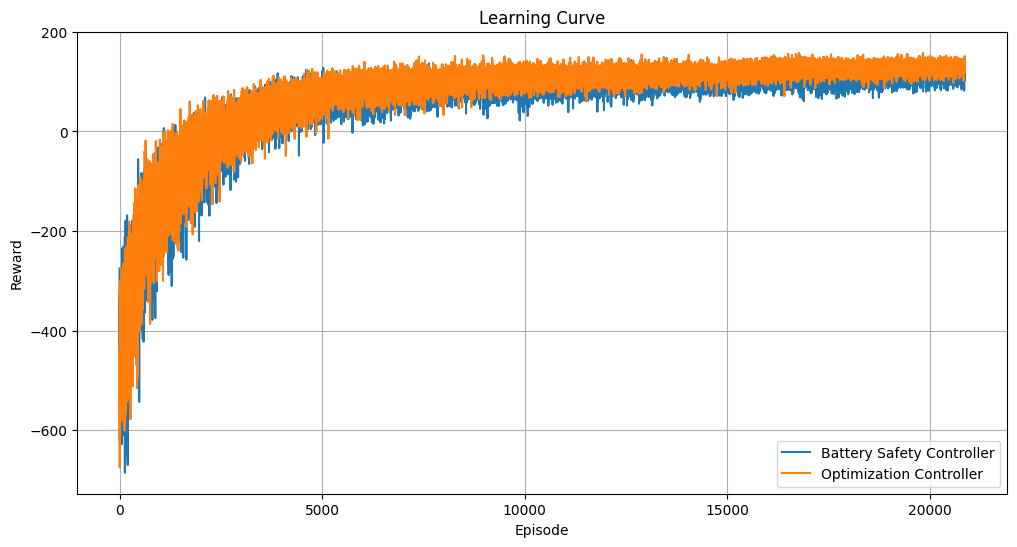

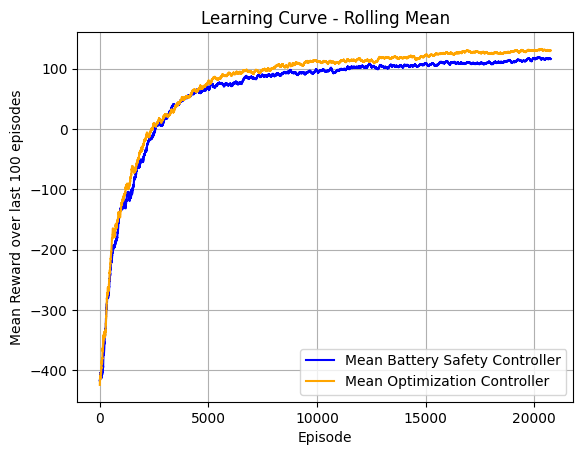

Mean reward for Battery Safety Controller: 62.24711969360034
Highest reward for Battery Safety Controller: 143.47590617835522
Mean reward for Optimization Controller: 75.15691489386192
Highest reward for Optimization Controller: 158.23869447410107
Total optimization time: 2821.9035651683807 seconds
Episode Reward: [-288.0205  -290.40457 -353.1846  -256.8858 ]
Episode Reward: [-300.67117 -297.20932 -344.03946 -268.36786]
Episode Reward: [-287.6467  -294.18622 -394.80353 -261.98712]
Episode Reward: [-285.3533  -299.06583 -328.3369  -258.10953]
Episode Reward: [-293.30838 -300.60074 -372.24997 -262.58514]
Episode Reward: [-288.94012 -300.26364 -390.56195 -261.79556]
Episode Reward: [-289.8718  -302.58167 -391.28317 -274.53592]
Episode Reward: [-292.7358  -293.45303 -339.08566 -257.93622]
Episode Reward: [-277.76532 -294.60736 -358.10217 -254.99644]
Episode Reward: [-290.28464 -297.23434 -364.87067 -266.70346]
Episode Reward: [-280.82767 -297.84442 -353.00305 -260.53375]
Episode Reward: [-

In [121]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import time
from stable_baselines3.common.callbacks import BaseCallback


start_time = time.time()




class BatterySafetyController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = PPO("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)
        
        
    def take_action(self, obs):
        obs_array = np.array(obs[0])  # Convert to NumPy array if it is not
        obs_array = obs_array.reshape(1, -1)  # Reshaping the array
        action, _ = self.model.predict(obs_array, deterministic=True)
        
        # Assuming `action` is a single value and creating a tuple with 4 elements
        # You will have to adjust the logic here to generate the correct four elements as per your requirement
        return (action[0], action[0], action[0], action[0])


class OptimizationController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = PPO("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)

    def take_action(self, obs):
        #print("Observation: ", obs)  # Print the observation to verify the fix
        obs_array = obs[0]  # Extracting the NumPy array from the tuple
        assert obs_array.shape[0] == 4, f"Invalid observation shape: {obs_array.shape}"
        action, _ = self.model.predict(obs_array, deterministic=True)
        return action
def ensure_battery_safety(env, battery_safety_controller, max_actions=10):
    total_reward = 0
    action_count = 0
    obs = env.reset()
    actions_taken = []  # Track actions taken during the episode
    while action_count < max_actions:
        action = battery_safety_controller.take_action(obs)
        actions_taken.append(action)  # Store action
        new_obs, reward, done, truncated, info = env.step(action)
        

        battery_penalty = - (env.alpha * np.maximum(0, 0.2 - obs[0][0]) + env.beta * np.maximum(0, obs[0][0] - 0.8))
        power_battery_penalty = - (env.gamma *np.maximum(0, 0.2 - obs[0][1]) + env.delta *np.maximum(0, obs[0][1] - 0.8))
        if battery_penalty == 0 and power_battery_penalty == 0:
            break

        total_reward += reward
        action_count += 1
        obs = new_obs

    return new_obs, total_reward, done, actions_taken  # return actions_taken

def rolling_mean(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1
    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    window_size = 100  # Change this to your preferred window size

    battery_safety_controller = BatterySafetyController(env)
    optimization_controller = OptimizationController(env)

    battery_safety_reward_tracker = RewardTracker()
    print("Training Battery Safety Controller...")
    battery_safety_controller.model.learn(total_timesteps=1000000, callback=battery_safety_reward_tracker)

    optimization_reward_tracker = RewardTracker()
    print("Training Optimization Controller...")
    optimization_controller.model.learn(total_timesteps=1000000, callback=optimization_reward_tracker)
    
        # Plotting the learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(battery_safety_reward_tracker.episode_rewards, label="Battery Safety Controller")
    plt.plot(optimization_reward_tracker.episode_rewards, label="Optimization Controller")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig("learning_curve.pdf", format="pdf")  # Saving the plot
    plt.show()
    
    
        # Plot rolling mean for Battery Safety Controller
    plt.plot(rolling_mean(battery_safety_reward_tracker.episode_rewards, window_size), label="Mean Battery Safety Controller", color='blue')
    
    # Plot rolling mean for Optimization Controller
    plt.plot(rolling_mean(optimization_reward_tracker.episode_rewards, window_size), label="Mean Optimization Controller", color='orange')

    plt.xlabel("Episode")
    plt.ylabel("Mean Reward over last {} episodes".format(window_size))
    plt.title("Learning Curve - Rolling Mean")
    plt.legend()
    plt.grid(True)
    plt.savefig("rolling_mean_curve.pdf", format="pdf")  # Saving the plot
    plt.show()
    

    # Print the mean rewards and their highest values:
    print(f"Mean reward for Battery Safety Controller: {np.mean(battery_safety_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Battery Safety Controller: {np.max(battery_safety_reward_tracker.episode_rewards)}")

    print(f"Mean reward for Optimization Controller: {np.mean(optimization_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Optimization Controller: {np.max(optimization_reward_tracker.episode_rewards)}")
    

    end_time = time.time()
    print(f"Total optimization time: {end_time - start_time} seconds")


    total_rewards = []

    action_tracker = []  # To store actions taken during evaluation

    final_episode_actions = []  # To store actions from the final episode

    for i in range(50):
        obs = env.reset()
        done = False
        episode_reward = 0

        action_tracker = []  # Reset action tracker at the start of every episode

        # Ensure battery safety
        obs, reward, done, actions_safety = ensure_battery_safety(env, battery_safety_controller)
        action_tracker.extend(actions_safety)  # Add actions from safety routine
        episode_reward += reward

        # Once battery is safe, optimize other parameters
        while not done:
            action = optimization_controller.take_action(obs)
            action_tracker.append(action)  # Track the action
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            #env.render()

        if i == 49:  # If it's the final episode
            final_episode_actions = action_tracker

        total_rewards.append(episode_reward)
        print(f"Episode Reward: {episode_reward}")
        best_actions_last_iter = final_episode_actions  # Using final episode actions as an example, modify accordingly.
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")


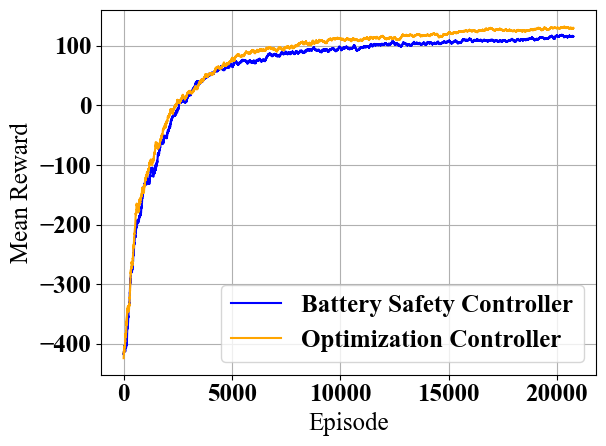

In [128]:
import matplotlib.pyplot as plt

# Define the font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 18}

# Apply the font settings
plt.rc('font', **font)

# Plot rolling mean for Battery Safety Controller
plt.plot(rolling_mean(battery_safety_reward_tracker.episode_rewards, window_size), label="Battery Safety Controller", color='blue')
    
# Plot rolling mean for Optimization Controller
plt.plot(rolling_mean(optimization_reward_tracker.episode_rewards, window_size), label="Optimization Controller", color='orange')

plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()  # This can ensure that the labels and titles fit within the figure boundaries
plt.savefig("rolling_mean_curve.pdf", format="pdf")  # Saving the plot
plt.show()


In [119]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
from stable_baselines3 import SAC, PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import time
from stable_baselines3.common.callbacks import BaseCallback


start_time = time.time()




class BatterySafetyController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = SAC("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)
        
        
    def take_action(self, obs):
        obs_array = np.array(obs[0])  # Convert to NumPy array if it is not
        obs_array = obs_array.reshape(1, -1)  # Reshaping the array
        action, _ = self.model.predict(obs_array, deterministic=True)
        
        # Assuming `action` is a single value and creating a tuple with 4 elements
        # You will have to adjust the logic here to generate the correct four elements as per your requirement
        return (action[0], action[0], action[0], action[0])


class OptimizationController:
    def __init__(self, env):
        self.env = DummyVecEnv([lambda: env])
        self.model = SAC("MlpPolicy", self.env, verbose=1)

    def train(self, timesteps):
        self.model.learn(total_timesteps=timesteps)

    def take_action(self, obs):
        #print("Observation: ", obs)  # Print the observation to verify the fix
        obs_array = obs[0]  # Extracting the NumPy array from the tuple
        assert obs_array.shape[0] == 4, f"Invalid observation shape: {obs_array.shape}"
        action, _ = self.model.predict(obs_array, deterministic=True)
        return action
def ensure_battery_safety(env, battery_safety_controller, max_actions=10):
    total_reward = 0
    action_count = 0
    obs = env.reset()
    actions_taken = []  # Track actions taken during the episode
    while action_count < max_actions:
        action = battery_safety_controller.take_action(obs)
        actions_taken.append(action)  # Store action
        new_obs, reward, done, truncated, info = env.step(action)
        

        battery_penalty = - (env.alpha * np.maximum(0, 0.2 - obs[0][0]) + env.beta * np.maximum(0, obs[0][0] - 0.8))
        power_battery_penalty = - (env.gamma *np.maximum(0, 0.2 - obs[0][1]) + env.delta *np.maximum(0, obs[0][1] - 0.8))
        if battery_penalty == 0 and power_battery_penalty == 0:
            break

        total_reward += reward
        action_count += 1
        obs = new_obs

    return new_obs, total_reward, done, actions_taken  # return actions_taken


if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1
    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    
    battery_safety_controller = BatterySafetyController(env)
    optimization_controller = OptimizationController(env)

    battery_safety_reward_tracker = RewardTracker()
    print("Training Battery Safety Controller...")
    battery_safety_controller.model.learn(total_timesteps=50000, callback=battery_safety_reward_tracker)

    optimization_reward_tracker = RewardTracker()
    print("Training Optimization Controller...")
    optimization_controller.model.learn(total_timesteps=50000, callback=optimization_reward_tracker)
    
        # Plotting the learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(battery_safety_reward_tracker.episode_rewards, label="Battery Safety Controller")
    plt.plot(optimization_reward_tracker.episode_rewards, label="Optimization Controller")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the mean rewards and their highest values:
    print(f"Mean reward for Battery Safety Controller: {np.mean(battery_safety_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Battery Safety Controller: {np.max(battery_safety_reward_tracker.episode_rewards)}")

    print(f"Mean reward for Optimization Controller: {np.mean(optimization_reward_tracker.episode_rewards)}")
    print(f"Highest reward for Optimization Controller: {np.max(optimization_reward_tracker.episode_rewards)}")
    

    end_time = time.time()
    print(f"Total optimization time: {end_time - start_time} seconds")


    total_rewards = []

    action_tracker = []  # To store actions taken during evaluation

    final_episode_actions = []  # To store actions from the final episode

    for i in range(50):
        obs = env.reset()
        done = False
        episode_reward = 0

        action_tracker = []  # Reset action tracker at the start of every episode

        # Ensure battery safety
        obs, reward, done, actions_safety = ensure_battery_safety(env, battery_safety_controller)
        action_tracker.extend(actions_safety)  # Add actions from safety routine
        episode_reward += reward

        # Once battery is safe, optimize other parameters
        while not done:
            action = optimization_controller.take_action(obs)
            action_tracker.append(action)  # Track the action
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            #env.render()

        if i == 49:  # If it's the final episode
            final_episode_actions = action_tracker

        total_rewards.append(episode_reward)
        print(f"Episode Reward: {episode_reward}")
        best_actions_last_iter = final_episode_actions  # Using final episode actions as an example, modify accordingly.
    
end_time = time.time()
print(f"Total optimization time: {end_time - start_time} seconds")


Using cpu device
Using cpu device
Training Battery Safety Controller...
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 99       |
|    time_elapsed    | 1        |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | 4.21     |
|    critic_loss     | 158      |
|    ent_coef        | 0.974    |
|    ent_coef_loss   | -0.165   |
|    learning_rate   | 0.0003   |
|    n_updates       | 91       |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 64       |
|    time_elapsed    | 5        |
|    total_timesteps | 384      |
| train/             |          |
|    actor_loss      | 5.68     |
|    critic_loss     | 134      |
|    ent_coef        | 0.926    |
|    ent_coef_loss   | -0.389   |
|    learning_rate   | 0.0003   |
|    n_updates       | 283      |
----------

---------------------------------
| time/              |          |
|    episodes        | 76       |
|    fps             | 43       |
|    time_elapsed    | 84       |
|    total_timesteps | 3648     |
| train/             |          |
|    actor_loss      | -3.02    |
|    critic_loss     | 24.7     |
|    ent_coef        | 0.442    |
|    ent_coef_loss   | -0.769   |
|    learning_rate   | 0.0003   |
|    n_updates       | 3547     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 80       |
|    fps             | 43       |
|    time_elapsed    | 88       |
|    total_timesteps | 3840     |
| train/             |          |
|    actor_loss      | -3.64    |
|    critic_loss     | 38       |
|    ent_coef        | 0.429    |
|    ent_coef_loss   | -0.774   |
|    learning_rate   | 0.0003   |
|    n_updates       | 3739     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 148      |
|    fps             | 42       |
|    time_elapsed    | 167      |
|    total_timesteps | 7104     |
| train/             |          |
|    actor_loss      | -14.5    |
|    critic_loss     | 40       |
|    ent_coef        | 0.29     |
|    ent_coef_loss   | -0.443   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7003     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 152      |
|    fps             | 42       |
|    time_elapsed    | 172      |
|    total_timesteps | 7296     |
| train/             |          |
|    actor_loss      | -16.7    |
|    critic_loss     | 29.5     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.185   |
|    learning_rate   | 0.0003   |
|    n_updates       | 7195     |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 220      |
|    fps             | 41       |
|    time_elapsed    | 252      |
|    total_timesteps | 10560    |
| train/             |          |
|    actor_loss      | -24.3    |
|    critic_loss     | 27.8     |
|    ent_coef        | 0.252    |
|    ent_coef_loss   | -0.336   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10459    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 224      |
|    fps             | 41       |
|    time_elapsed    | 256      |
|    total_timesteps | 10752    |
| train/             |          |
|    actor_loss      | -24.8    |
|    critic_loss     | 30.8     |
|    ent_coef        | 0.253    |
|    ent_coef_loss   | 0.0291   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10651    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 292      |
|    fps             | 41       |
|    time_elapsed    | 336      |
|    total_timesteps | 14016    |
| train/             |          |
|    actor_loss      | -28.7    |
|    critic_loss     | 39.3     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.644   |
|    learning_rate   | 0.0003   |
|    n_updates       | 13915    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 296      |
|    fps             | 41       |
|    time_elapsed    | 341      |
|    total_timesteps | 14208    |
| train/             |          |
|    actor_loss      | -29.2    |
|    critic_loss     | 40.4     |
|    ent_coef        | 0.268    |
|    ent_coef_loss   | -0.771   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14107    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 364      |
|    fps             | 41       |
|    time_elapsed    | 421      |
|    total_timesteps | 17472    |
| train/             |          |
|    actor_loss      | -30.6    |
|    critic_loss     | 58.8     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | -0.239   |
|    learning_rate   | 0.0003   |
|    n_updates       | 17371    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 368      |
|    fps             | 41       |
|    time_elapsed    | 426      |
|    total_timesteps | 17664    |
| train/             |          |
|    actor_loss      | -31.4    |
|    critic_loss     | 36.8     |
|    ent_coef        | 0.281    |
|    ent_coef_loss   | 0.293    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17563    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 436      |
|    fps             | 41       |
|    time_elapsed    | 507      |
|    total_timesteps | 20928    |
| train/             |          |
|    actor_loss      | -31.3    |
|    critic_loss     | 40.6     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | 0.224    |
|    learning_rate   | 0.0003   |
|    n_updates       | 20827    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 440      |
|    fps             | 41       |
|    time_elapsed    | 512      |
|    total_timesteps | 21120    |
| train/             |          |
|    actor_loss      | -31.6    |
|    critic_loss     | 68.2     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.353   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21019    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 508      |
|    fps             | 41       |
|    time_elapsed    | 594      |
|    total_timesteps | 24384    |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 61.7     |
|    ent_coef        | 0.25     |
|    ent_coef_loss   | -0.068   |
|    learning_rate   | 0.0003   |
|    n_updates       | 24283    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 512      |
|    fps             | 41       |
|    time_elapsed    | 599      |
|    total_timesteps | 24576    |
| train/             |          |
|    actor_loss      | -31.2    |
|    critic_loss     | 44.6     |
|    ent_coef        | 0.253    |
|    ent_coef_loss   | -0.06    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24475    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 580      |
|    fps             | 40       |
|    time_elapsed    | 682      |
|    total_timesteps | 27840    |
| train/             |          |
|    actor_loss      | -32.6    |
|    critic_loss     | 34.7     |
|    ent_coef        | 0.257    |
|    ent_coef_loss   | -0.18    |
|    learning_rate   | 0.0003   |
|    n_updates       | 27739    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 584      |
|    fps             | 40       |
|    time_elapsed    | 687      |
|    total_timesteps | 28032    |
| train/             |          |
|    actor_loss      | -32.5    |
|    critic_loss     | 44.4     |
|    ent_coef        | 0.256    |
|    ent_coef_loss   | -0.187   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27931    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 652      |
|    fps             | 40       |
|    time_elapsed    | 769      |
|    total_timesteps | 31296    |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 51.1     |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | -0.287   |
|    learning_rate   | 0.0003   |
|    n_updates       | 31195    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 656      |
|    fps             | 40       |
|    time_elapsed    | 774      |
|    total_timesteps | 31488    |
| train/             |          |
|    actor_loss      | -33.4    |
|    critic_loss     | 38.8     |
|    ent_coef        | 0.248    |
|    ent_coef_loss   | 0.234    |
|    learning_rate   | 0.0003   |
|    n_updates       | 31387    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 724      |
|    fps             | 40       |
|    time_elapsed    | 856      |
|    total_timesteps | 34752    |
| train/             |          |
|    actor_loss      | -34.1    |
|    critic_loss     | 53.4     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | 0.0938   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34651    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 728      |
|    fps             | 40       |
|    time_elapsed    | 860      |
|    total_timesteps | 34944    |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 33.3     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | 0.289    |
|    learning_rate   | 0.0003   |
|    n_updates       | 34843    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 796      |
|    fps             | 40       |
|    time_elapsed    | 943      |
|    total_timesteps | 38208    |
| train/             |          |
|    actor_loss      | -32.8    |
|    critic_loss     | 42.1     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | 0.243    |
|    learning_rate   | 0.0003   |
|    n_updates       | 38107    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 800      |
|    fps             | 40       |
|    time_elapsed    | 947      |
|    total_timesteps | 38400    |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 48.8     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.0154  |
|    learning_rate   | 0.0003   |
|    n_updates       | 38299    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 868      |
|    fps             | 40       |
|    time_elapsed    | 1030     |
|    total_timesteps | 41664    |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 14.9     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | -0.0294  |
|    learning_rate   | 0.0003   |
|    n_updates       | 41563    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 872      |
|    fps             | 40       |
|    time_elapsed    | 1035     |
|    total_timesteps | 41856    |
| train/             |          |
|    actor_loss      | -32.2    |
|    critic_loss     | 59.5     |
|    ent_coef        | 0.274    |
|    ent_coef_loss   | -0.104   |
|    learning_rate   | 0.0003   |
|    n_updates       | 41755    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 940      |
|    fps             | 40       |
|    time_elapsed    | 1117     |
|    total_timesteps | 45120    |
| train/             |          |
|    actor_loss      | -31.7    |
|    critic_loss     | 40.3     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | -0.0328  |
|    learning_rate   | 0.0003   |
|    n_updates       | 45019    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 944      |
|    fps             | 40       |
|    time_elapsed    | 1122     |
|    total_timesteps | 45312    |
| train/             |          |
|    actor_loss      | -32      |
|    critic_loss     | 31.5     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | 0.238    |
|    learning_rate   | 0.0003   |
|    n_updates       | 45211    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1012     |
|    fps             | 40       |
|    time_elapsed    | 1205     |
|    total_timesteps | 48576    |
| train/             |          |
|    actor_loss      | -31.8    |
|    critic_loss     | 32.3     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.168   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48475    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1016     |
|    fps             | 40       |
|    time_elapsed    | 1210     |
|    total_timesteps | 48768    |
| train/             |          |
|    actor_loss      | -31.6    |
|    critic_loss     | 45.6     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | -0.0813  |
|    learning_rate   | 0.0003   |
|    n_updates       | 48667    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1084     |
|    fps             | 40       |
|    time_elapsed    | 1294     |
|    total_timesteps | 52032    |
| train/             |          |
|    actor_loss      | -30.8    |
|    critic_loss     | 30.4     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | 0.27     |
|    learning_rate   | 0.0003   |
|    n_updates       | 51931    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1088     |
|    fps             | 40       |
|    time_elapsed    | 1299     |
|    total_timesteps | 52224    |
| train/             |          |
|    actor_loss      | -31.5    |
|    critic_loss     | 32.4     |
|    ent_coef        | 0.277    |
|    ent_coef_loss   | 0.0859   |
|    learning_rate   | 0.0003   |
|    n_updates       | 52123    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1156     |
|    fps             | 40       |
|    time_elapsed    | 1382     |
|    total_timesteps | 55488    |
| train/             |          |
|    actor_loss      | -31.1    |
|    critic_loss     | 34.8     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | -0.235   |
|    learning_rate   | 0.0003   |
|    n_updates       | 55387    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1160     |
|    fps             | 40       |
|    time_elapsed    | 1387     |
|    total_timesteps | 55680    |
| train/             |          |
|    actor_loss      | -31.7    |
|    critic_loss     | 32.3     |
|    ent_coef        | 0.278    |
|    ent_coef_loss   | 0.615    |
|    learning_rate   | 0.0003   |
|    n_updates       | 55579    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1228     |
|    fps             | 40       |
|    time_elapsed    | 1472     |
|    total_timesteps | 58944    |
| train/             |          |
|    actor_loss      | -31.8    |
|    critic_loss     | 57.1     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | -0.0149  |
|    learning_rate   | 0.0003   |
|    n_updates       | 58843    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1232     |
|    fps             | 40       |
|    time_elapsed    | 1477     |
|    total_timesteps | 59136    |
| train/             |          |
|    actor_loss      | -31.8    |
|    critic_loss     | 51       |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | 0.0854   |
|    learning_rate   | 0.0003   |
|    n_updates       | 59035    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1300     |
|    fps             | 39       |
|    time_elapsed    | 1564     |
|    total_timesteps | 62400    |
| train/             |          |
|    actor_loss      | -32      |
|    critic_loss     | 43       |
|    ent_coef        | 0.278    |
|    ent_coef_loss   | -0.18    |
|    learning_rate   | 0.0003   |
|    n_updates       | 62299    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1304     |
|    fps             | 39       |
|    time_elapsed    | 1569     |
|    total_timesteps | 62592    |
| train/             |          |
|    actor_loss      | -31.8    |
|    critic_loss     | 26.1     |
|    ent_coef        | 0.275    |
|    ent_coef_loss   | 0.178    |
|    learning_rate   | 0.0003   |
|    n_updates       | 62491    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1372     |
|    fps             | 39       |
|    time_elapsed    | 1655     |
|    total_timesteps | 65856    |
| train/             |          |
|    actor_loss      | -32.6    |
|    critic_loss     | 25.3     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | -0.0541  |
|    learning_rate   | 0.0003   |
|    n_updates       | 65755    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1376     |
|    fps             | 39       |
|    time_elapsed    | 1660     |
|    total_timesteps | 66048    |
| train/             |          |
|    actor_loss      | -31.9    |
|    critic_loss     | 41.3     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | -0.144   |
|    learning_rate   | 0.0003   |
|    n_updates       | 65947    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1444     |
|    fps             | 39       |
|    time_elapsed    | 1747     |
|    total_timesteps | 69312    |
| train/             |          |
|    actor_loss      | -32.6    |
|    critic_loss     | 46.7     |
|    ent_coef        | 0.335    |
|    ent_coef_loss   | -0.31    |
|    learning_rate   | 0.0003   |
|    n_updates       | 69211    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1448     |
|    fps             | 39       |
|    time_elapsed    | 1752     |
|    total_timesteps | 69504    |
| train/             |          |
|    actor_loss      | -33.1    |
|    critic_loss     | 65.8     |
|    ent_coef        | 0.334    |
|    ent_coef_loss   | 0.31     |
|    learning_rate   | 0.0003   |
|    n_updates       | 69403    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1516     |
|    fps             | 39       |
|    time_elapsed    | 1841     |
|    total_timesteps | 72768    |
| train/             |          |
|    actor_loss      | -33      |
|    critic_loss     | 42.2     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.201    |
|    learning_rate   | 0.0003   |
|    n_updates       | 72667    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1520     |
|    fps             | 39       |
|    time_elapsed    | 1846     |
|    total_timesteps | 72960    |
| train/             |          |
|    actor_loss      | -33.5    |
|    critic_loss     | 33.6     |
|    ent_coef        | 0.31     |
|    ent_coef_loss   | -0.222   |
|    learning_rate   | 0.0003   |
|    n_updates       | 72859    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1588     |
|    fps             | 39       |
|    time_elapsed    | 1935     |
|    total_timesteps | 76224    |
| train/             |          |
|    actor_loss      | -33.8    |
|    critic_loss     | 46.9     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | 0.129    |
|    learning_rate   | 0.0003   |
|    n_updates       | 76123    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1592     |
|    fps             | 39       |
|    time_elapsed    | 1940     |
|    total_timesteps | 76416    |
| train/             |          |
|    actor_loss      | -34.1    |
|    critic_loss     | 54.7     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.0318   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76315    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1660     |
|    fps             | 39       |
|    time_elapsed    | 2029     |
|    total_timesteps | 79680    |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 36.8     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | -0.227   |
|    learning_rate   | 0.0003   |
|    n_updates       | 79579    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1664     |
|    fps             | 39       |
|    time_elapsed    | 2035     |
|    total_timesteps | 79872    |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 35       |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | -0.338   |
|    learning_rate   | 0.0003   |
|    n_updates       | 79771    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1732     |
|    fps             | 39       |
|    time_elapsed    | 2124     |
|    total_timesteps | 83136    |
| train/             |          |
|    actor_loss      | -35.8    |
|    critic_loss     | 50.6     |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | -0.0755  |
|    learning_rate   | 0.0003   |
|    n_updates       | 83035    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1736     |
|    fps             | 39       |
|    time_elapsed    | 2129     |
|    total_timesteps | 83328    |
| train/             |          |
|    actor_loss      | -35.7    |
|    critic_loss     | 46       |
|    ent_coef        | 0.302    |
|    ent_coef_loss   | 0.075    |
|    learning_rate   | 0.0003   |
|    n_updates       | 83227    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1804     |
|    fps             | 39       |
|    time_elapsed    | 2218     |
|    total_timesteps | 86592    |
| train/             |          |
|    actor_loss      | -35.5    |
|    critic_loss     | 48.5     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | -0.00598 |
|    learning_rate   | 0.0003   |
|    n_updates       | 86491    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1808     |
|    fps             | 39       |
|    time_elapsed    | 2224     |
|    total_timesteps | 86784    |
| train/             |          |
|    actor_loss      | -35.9    |
|    critic_loss     | 51.8     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | -0.129   |
|    learning_rate   | 0.0003   |
|    n_updates       | 86683    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1876     |
|    fps             | 38       |
|    time_elapsed    | 2313     |
|    total_timesteps | 90048    |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 26.1     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.245   |
|    learning_rate   | 0.0003   |
|    n_updates       | 89947    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1880     |
|    fps             | 38       |
|    time_elapsed    | 2319     |
|    total_timesteps | 90240    |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 38.7     |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | 0.243    |
|    learning_rate   | 0.0003   |
|    n_updates       | 90139    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 1948     |
|    fps             | 38       |
|    time_elapsed    | 2410     |
|    total_timesteps | 93504    |
| train/             |          |
|    actor_loss      | -36.8    |
|    critic_loss     | 45       |
|    ent_coef        | 0.288    |
|    ent_coef_loss   | 0.13     |
|    learning_rate   | 0.0003   |
|    n_updates       | 93403    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 1952     |
|    fps             | 38       |
|    time_elapsed    | 2415     |
|    total_timesteps | 93696    |
| train/             |          |
|    actor_loss      | -35.4    |
|    critic_loss     | 36.2     |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.362   |
|    learning_rate   | 0.0003   |
|    n_updates       | 93595    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2020     |
|    fps             | 38       |
|    time_elapsed    | 2507     |
|    total_timesteps | 96960    |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 50.8     |
|    ent_coef        | 0.29     |
|    ent_coef_loss   | 0.0533   |
|    learning_rate   | 0.0003   |
|    n_updates       | 96859    |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2024     |
|    fps             | 38       |
|    time_elapsed    | 2512     |
|    total_timesteps | 97152    |
| train/             |          |
|    actor_loss      | -37.8    |
|    critic_loss     | 74.6     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | 0.0993   |
|    learning_rate   | 0.0003   |
|    n_updates       | 97051    |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2092     |
|    fps             | 38       |
|    time_elapsed    | 2605     |
|    total_timesteps | 100416   |
| train/             |          |
|    actor_loss      | -38.2    |
|    critic_loss     | 35.1     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.0424  |
|    learning_rate   | 0.0003   |
|    n_updates       | 100315   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2096     |
|    fps             | 38       |
|    time_elapsed    | 2610     |
|    total_timesteps | 100608   |
| train/             |          |
|    actor_loss      | -37.3    |
|    critic_loss     | 79.4     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.328   |
|    learning_rate   | 0.0003   |
|    n_updates       | 100507   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2164     |
|    fps             | 38       |
|    time_elapsed    | 2702     |
|    total_timesteps | 103872   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 20.8     |
|    ent_coef        | 0.273    |
|    ent_coef_loss   | 0.0861   |
|    learning_rate   | 0.0003   |
|    n_updates       | 103771   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2168     |
|    fps             | 38       |
|    time_elapsed    | 2708     |
|    total_timesteps | 104064   |
| train/             |          |
|    actor_loss      | -38      |
|    critic_loss     | 38.7     |
|    ent_coef        | 0.274    |
|    ent_coef_loss   | -0.074   |
|    learning_rate   | 0.0003   |
|    n_updates       | 103963   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2236     |
|    fps             | 38       |
|    time_elapsed    | 2800     |
|    total_timesteps | 107328   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 49.6     |
|    ent_coef        | 0.281    |
|    ent_coef_loss   | 0.0785   |
|    learning_rate   | 0.0003   |
|    n_updates       | 107227   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2240     |
|    fps             | 38       |
|    time_elapsed    | 2806     |
|    total_timesteps | 107520   |
| train/             |          |
|    actor_loss      | -38.6    |
|    critic_loss     | 31.1     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | 0.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 107419   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2308     |
|    fps             | 38       |
|    time_elapsed    | 2897     |
|    total_timesteps | 110784   |
| train/             |          |
|    actor_loss      | -37.6    |
|    critic_loss     | 36.8     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | -0.562   |
|    learning_rate   | 0.0003   |
|    n_updates       | 110683   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2312     |
|    fps             | 38       |
|    time_elapsed    | 2903     |
|    total_timesteps | 110976   |
| train/             |          |
|    actor_loss      | -38.9    |
|    critic_loss     | 60.4     |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | 0.156    |
|    learning_rate   | 0.0003   |
|    n_updates       | 110875   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2380     |
|    fps             | 38       |
|    time_elapsed    | 2994     |
|    total_timesteps | 114240   |
| train/             |          |
|    actor_loss      | -37.9    |
|    critic_loss     | 46.7     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | -0.0169  |
|    learning_rate   | 0.0003   |
|    n_updates       | 114139   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2384     |
|    fps             | 38       |
|    time_elapsed    | 3000     |
|    total_timesteps | 114432   |
| train/             |          |
|    actor_loss      | -38.1    |
|    critic_loss     | 35.5     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | -0.113   |
|    learning_rate   | 0.0003   |
|    n_updates       | 114331   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2452     |
|    fps             | 38       |
|    time_elapsed    | 3091     |
|    total_timesteps | 117696   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 39.7     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.0946   |
|    learning_rate   | 0.0003   |
|    n_updates       | 117595   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2456     |
|    fps             | 38       |
|    time_elapsed    | 3097     |
|    total_timesteps | 117888   |
| train/             |          |
|    actor_loss      | -37.8    |
|    critic_loss     | 40.3     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | 0.494    |
|    learning_rate   | 0.0003   |
|    n_updates       | 117787   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2524     |
|    fps             | 37       |
|    time_elapsed    | 3189     |
|    total_timesteps | 121152   |
| train/             |          |
|    actor_loss      | -39.1    |
|    critic_loss     | 30.9     |
|    ent_coef        | 0.29     |
|    ent_coef_loss   | 0.0867   |
|    learning_rate   | 0.0003   |
|    n_updates       | 121051   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2528     |
|    fps             | 37       |
|    time_elapsed    | 3194     |
|    total_timesteps | 121344   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 43.3     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | -0.0115  |
|    learning_rate   | 0.0003   |
|    n_updates       | 121243   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2596     |
|    fps             | 37       |
|    time_elapsed    | 3287     |
|    total_timesteps | 124608   |
| train/             |          |
|    actor_loss      | -37.4    |
|    critic_loss     | 44.5     |
|    ent_coef        | 0.292    |
|    ent_coef_loss   | -0.169   |
|    learning_rate   | 0.0003   |
|    n_updates       | 124507   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2600     |
|    fps             | 37       |
|    time_elapsed    | 3293     |
|    total_timesteps | 124800   |
| train/             |          |
|    actor_loss      | -38      |
|    critic_loss     | 41.1     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | -0.131   |
|    learning_rate   | 0.0003   |
|    n_updates       | 124699   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2668     |
|    fps             | 37       |
|    time_elapsed    | 3385     |
|    total_timesteps | 128064   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 72.1     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | 0.249    |
|    learning_rate   | 0.0003   |
|    n_updates       | 127963   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2672     |
|    fps             | 37       |
|    time_elapsed    | 3391     |
|    total_timesteps | 128256   |
| train/             |          |
|    actor_loss      | -38.8    |
|    critic_loss     | 61.9     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | 0.181    |
|    learning_rate   | 0.0003   |
|    n_updates       | 128155   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2740     |
|    fps             | 37       |
|    time_elapsed    | 3483     |
|    total_timesteps | 131520   |
| train/             |          |
|    actor_loss      | -37.6    |
|    critic_loss     | 52.8     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | -0.0231  |
|    learning_rate   | 0.0003   |
|    n_updates       | 131419   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2744     |
|    fps             | 37       |
|    time_elapsed    | 3489     |
|    total_timesteps | 131712   |
| train/             |          |
|    actor_loss      | -37.8    |
|    critic_loss     | 36.2     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | 0.242    |
|    learning_rate   | 0.0003   |
|    n_updates       | 131611   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2812     |
|    fps             | 37       |
|    time_elapsed    | 3581     |
|    total_timesteps | 134976   |
| train/             |          |
|    actor_loss      | -37.5    |
|    critic_loss     | 57       |
|    ent_coef        | 0.282    |
|    ent_coef_loss   | -0.497   |
|    learning_rate   | 0.0003   |
|    n_updates       | 134875   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2816     |
|    fps             | 37       |
|    time_elapsed    | 3587     |
|    total_timesteps | 135168   |
| train/             |          |
|    actor_loss      | -37.6    |
|    critic_loss     | 47.9     |
|    ent_coef        | 0.284    |
|    ent_coef_loss   | 0.0862   |
|    learning_rate   | 0.0003   |
|    n_updates       | 135067   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2884     |
|    fps             | 37       |
|    time_elapsed    | 3680     |
|    total_timesteps | 138432   |
| train/             |          |
|    actor_loss      | -38.2    |
|    critic_loss     | 43.1     |
|    ent_coef        | 0.288    |
|    ent_coef_loss   | -0.249   |
|    learning_rate   | 0.0003   |
|    n_updates       | 138331   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2888     |
|    fps             | 37       |
|    time_elapsed    | 3685     |
|    total_timesteps | 138624   |
| train/             |          |
|    actor_loss      | -38.4    |
|    critic_loss     | 51.9     |
|    ent_coef        | 0.285    |
|    ent_coef_loss   | -0.0833  |
|    learning_rate   | 0.0003   |
|    n_updates       | 138523   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 2956     |
|    fps             | 37       |
|    time_elapsed    | 3778     |
|    total_timesteps | 141888   |
| train/             |          |
|    actor_loss      | -38      |
|    critic_loss     | 40.6     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | -0.309   |
|    learning_rate   | 0.0003   |
|    n_updates       | 141787   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 2960     |
|    fps             | 37       |
|    time_elapsed    | 3783     |
|    total_timesteps | 142080   |
| train/             |          |
|    actor_loss      | -39.2    |
|    critic_loss     | 54.9     |
|    ent_coef        | 0.288    |
|    ent_coef_loss   | 0.094    |
|    learning_rate   | 0.0003   |
|    n_updates       | 141979   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3028     |
|    fps             | 37       |
|    time_elapsed    | 3875     |
|    total_timesteps | 145344   |
| train/             |          |
|    actor_loss      | -39.3    |
|    critic_loss     | 40.4     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | 0.058    |
|    learning_rate   | 0.0003   |
|    n_updates       | 145243   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3032     |
|    fps             | 37       |
|    time_elapsed    | 3880     |
|    total_timesteps | 145536   |
| train/             |          |
|    actor_loss      | -38.1    |
|    critic_loss     | 38.9     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | -0.669   |
|    learning_rate   | 0.0003   |
|    n_updates       | 145435   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3100     |
|    fps             | 37       |
|    time_elapsed    | 3972     |
|    total_timesteps | 148800   |
| train/             |          |
|    actor_loss      | -38.9    |
|    critic_loss     | 40.3     |
|    ent_coef        | 0.289    |
|    ent_coef_loss   | 0.202    |
|    learning_rate   | 0.0003   |
|    n_updates       | 148699   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3104     |
|    fps             | 37       |
|    time_elapsed    | 3977     |
|    total_timesteps | 148992   |
| train/             |          |
|    actor_loss      | -38.1    |
|    critic_loss     | 51.5     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.283   |
|    learning_rate   | 0.0003   |
|    n_updates       | 148891   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3172     |
|    fps             | 37       |
|    time_elapsed    | 4068     |
|    total_timesteps | 152256   |
| train/             |          |
|    actor_loss      | -39.3    |
|    critic_loss     | 28.6     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | -0.224   |
|    learning_rate   | 0.0003   |
|    n_updates       | 152155   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3176     |
|    fps             | 37       |
|    time_elapsed    | 4074     |
|    total_timesteps | 152448   |
| train/             |          |
|    actor_loss      | -38.7    |
|    critic_loss     | 54.4     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | 0.0934   |
|    learning_rate   | 0.0003   |
|    n_updates       | 152347   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3244     |
|    fps             | 37       |
|    time_elapsed    | 4165     |
|    total_timesteps | 155712   |
| train/             |          |
|    actor_loss      | -39.1    |
|    critic_loss     | 56.7     |
|    ent_coef        | 0.287    |
|    ent_coef_loss   | -0.0837  |
|    learning_rate   | 0.0003   |
|    n_updates       | 155611   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3248     |
|    fps             | 37       |
|    time_elapsed    | 4171     |
|    total_timesteps | 155904   |
| train/             |          |
|    actor_loss      | -39.6    |
|    critic_loss     | 40.9     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | 0.00679  |
|    learning_rate   | 0.0003   |
|    n_updates       | 155803   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3316     |
|    fps             | 37       |
|    time_elapsed    | 4263     |
|    total_timesteps | 159168   |
| train/             |          |
|    actor_loss      | -38.9    |
|    critic_loss     | 46.8     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | -0.0104  |
|    learning_rate   | 0.0003   |
|    n_updates       | 159067   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3320     |
|    fps             | 37       |
|    time_elapsed    | 4268     |
|    total_timesteps | 159360   |
| train/             |          |
|    actor_loss      | -39.5    |
|    critic_loss     | 58.1     |
|    ent_coef        | 0.287    |
|    ent_coef_loss   | -0.00101 |
|    learning_rate   | 0.0003   |
|    n_updates       | 159259   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3388     |
|    fps             | 37       |
|    time_elapsed    | 4360     |
|    total_timesteps | 162624   |
| train/             |          |
|    actor_loss      | -38.7    |
|    critic_loss     | 32       |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.335   |
|    learning_rate   | 0.0003   |
|    n_updates       | 162523   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3392     |
|    fps             | 37       |
|    time_elapsed    | 4365     |
|    total_timesteps | 162816   |
| train/             |          |
|    actor_loss      | -39.1    |
|    critic_loss     | 30.9     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | 0.146    |
|    learning_rate   | 0.0003   |
|    n_updates       | 162715   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3460     |
|    fps             | 37       |
|    time_elapsed    | 4458     |
|    total_timesteps | 166080   |
| train/             |          |
|    actor_loss      | -38.8    |
|    critic_loss     | 42.4     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | 0.0911   |
|    learning_rate   | 0.0003   |
|    n_updates       | 165979   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3464     |
|    fps             | 37       |
|    time_elapsed    | 4463     |
|    total_timesteps | 166272   |
| train/             |          |
|    actor_loss      | -39.3    |
|    critic_loss     | 45.3     |
|    ent_coef        | 0.287    |
|    ent_coef_loss   | 0.336    |
|    learning_rate   | 0.0003   |
|    n_updates       | 166171   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3532     |
|    fps             | 37       |
|    time_elapsed    | 4555     |
|    total_timesteps | 169536   |
| train/             |          |
|    actor_loss      | -40.7    |
|    critic_loss     | 41.5     |
|    ent_coef        | 0.277    |
|    ent_coef_loss   | -0.0145  |
|    learning_rate   | 0.0003   |
|    n_updates       | 169435   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3536     |
|    fps             | 37       |
|    time_elapsed    | 4560     |
|    total_timesteps | 169728   |
| train/             |          |
|    actor_loss      | -40.8    |
|    critic_loss     | 59.9     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | 0.105    |
|    learning_rate   | 0.0003   |
|    n_updates       | 169627   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3604     |
|    fps             | 37       |
|    time_elapsed    | 4652     |
|    total_timesteps | 172992   |
| train/             |          |
|    actor_loss      | -39.3    |
|    critic_loss     | 57       |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | -0.0614  |
|    learning_rate   | 0.0003   |
|    n_updates       | 172891   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3608     |
|    fps             | 37       |
|    time_elapsed    | 4657     |
|    total_timesteps | 173184   |
| train/             |          |
|    actor_loss      | -39.3    |
|    critic_loss     | 34.1     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.0199  |
|    learning_rate   | 0.0003   |
|    n_updates       | 173083   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3676     |
|    fps             | 37       |
|    time_elapsed    | 4749     |
|    total_timesteps | 176448   |
| train/             |          |
|    actor_loss      | -39.1    |
|    critic_loss     | 36.1     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | 0.221    |
|    learning_rate   | 0.0003   |
|    n_updates       | 176347   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3680     |
|    fps             | 37       |
|    time_elapsed    | 4755     |
|    total_timesteps | 176640   |
| train/             |          |
|    actor_loss      | -38.9    |
|    critic_loss     | 40.6     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | -0.102   |
|    learning_rate   | 0.0003   |
|    n_updates       | 176539   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3748     |
|    fps             | 37       |
|    time_elapsed    | 4846     |
|    total_timesteps | 179904   |
| train/             |          |
|    actor_loss      | -39      |
|    critic_loss     | 26.1     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | 0.0675   |
|    learning_rate   | 0.0003   |
|    n_updates       | 179803   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3752     |
|    fps             | 37       |
|    time_elapsed    | 4852     |
|    total_timesteps | 180096   |
| train/             |          |
|    actor_loss      | -39      |
|    critic_loss     | 51.2     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.239    |
|    learning_rate   | 0.0003   |
|    n_updates       | 179995   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3820     |
|    fps             | 37       |
|    time_elapsed    | 4944     |
|    total_timesteps | 183360   |
| train/             |          |
|    actor_loss      | -37.3    |
|    critic_loss     | 83.4     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.139   |
|    learning_rate   | 0.0003   |
|    n_updates       | 183259   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3824     |
|    fps             | 37       |
|    time_elapsed    | 4950     |
|    total_timesteps | 183552   |
| train/             |          |
|    actor_loss      | -38      |
|    critic_loss     | 50.7     |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | -0.132   |
|    learning_rate   | 0.0003   |
|    n_updates       | 183451   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3892     |
|    fps             | 37       |
|    time_elapsed    | 5044     |
|    total_timesteps | 186816   |
| train/             |          |
|    actor_loss      | -38.4    |
|    critic_loss     | 47.2     |
|    ent_coef        | 0.292    |
|    ent_coef_loss   | -0.319   |
|    learning_rate   | 0.0003   |
|    n_updates       | 186715   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3896     |
|    fps             | 37       |
|    time_elapsed    | 5049     |
|    total_timesteps | 187008   |
| train/             |          |
|    actor_loss      | -37.5    |
|    critic_loss     | 50.9     |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | 0.18     |
|    learning_rate   | 0.0003   |
|    n_updates       | 186907   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 3964     |
|    fps             | 36       |
|    time_elapsed    | 5143     |
|    total_timesteps | 190272   |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 63.9     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | 0.18     |
|    learning_rate   | 0.0003   |
|    n_updates       | 190171   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 3968     |
|    fps             | 36       |
|    time_elapsed    | 5148     |
|    total_timesteps | 190464   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 43.2     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | -0.00869 |
|    learning_rate   | 0.0003   |
|    n_updates       | 190363   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4036     |
|    fps             | 36       |
|    time_elapsed    | 5242     |
|    total_timesteps | 193728   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 35       |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.0931  |
|    learning_rate   | 0.0003   |
|    n_updates       | 193627   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4040     |
|    fps             | 36       |
|    time_elapsed    | 5247     |
|    total_timesteps | 193920   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 43.4     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | -0.0123  |
|    learning_rate   | 0.0003   |
|    n_updates       | 193819   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4108     |
|    fps             | 36       |
|    time_elapsed    | 5341     |
|    total_timesteps | 197184   |
| train/             |          |
|    actor_loss      | -36.4    |
|    critic_loss     | 38.6     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.0451  |
|    learning_rate   | 0.0003   |
|    n_updates       | 197083   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4112     |
|    fps             | 36       |
|    time_elapsed    | 5347     |
|    total_timesteps | 197376   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 34.4     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | 0.221    |
|    learning_rate   | 0.0003   |
|    n_updates       | 197275   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4180     |
|    fps             | 36       |
|    time_elapsed    | 5441     |
|    total_timesteps | 200640   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 42.4     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | -0.0254  |
|    learning_rate   | 0.0003   |
|    n_updates       | 200539   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4184     |
|    fps             | 36       |
|    time_elapsed    | 5446     |
|    total_timesteps | 200832   |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 19       |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | 0.0943   |
|    learning_rate   | 0.0003   |
|    n_updates       | 200731   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4252     |
|    fps             | 36       |
|    time_elapsed    | 5540     |
|    total_timesteps | 204096   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 31.1     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | 0.0241   |
|    learning_rate   | 0.0003   |
|    n_updates       | 203995   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4256     |
|    fps             | 36       |
|    time_elapsed    | 5545     |
|    total_timesteps | 204288   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 43.3     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.403   |
|    learning_rate   | 0.0003   |
|    n_updates       | 204187   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4324     |
|    fps             | 36       |
|    time_elapsed    | 5639     |
|    total_timesteps | 207552   |
| train/             |          |
|    actor_loss      | -35.7    |
|    critic_loss     | 36.7     |
|    ent_coef        | 0.302    |
|    ent_coef_loss   | -0.234   |
|    learning_rate   | 0.0003   |
|    n_updates       | 207451   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4328     |
|    fps             | 36       |
|    time_elapsed    | 5644     |
|    total_timesteps | 207744   |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 49.7     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.0765  |
|    learning_rate   | 0.0003   |
|    n_updates       | 207643   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4396     |
|    fps             | 36       |
|    time_elapsed    | 5736     |
|    total_timesteps | 211008   |
| train/             |          |
|    actor_loss      | -35.4    |
|    critic_loss     | 44.3     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.116    |
|    learning_rate   | 0.0003   |
|    n_updates       | 210907   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4400     |
|    fps             | 36       |
|    time_elapsed    | 5742     |
|    total_timesteps | 211200   |
| train/             |          |
|    actor_loss      | -36.4    |
|    critic_loss     | 31.5     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | -0.0304  |
|    learning_rate   | 0.0003   |
|    n_updates       | 211099   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4468     |
|    fps             | 36       |
|    time_elapsed    | 5834     |
|    total_timesteps | 214464   |
| train/             |          |
|    actor_loss      | -35.3    |
|    critic_loss     | 49.3     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.263    |
|    learning_rate   | 0.0003   |
|    n_updates       | 214363   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4472     |
|    fps             | 36       |
|    time_elapsed    | 5840     |
|    total_timesteps | 214656   |
| train/             |          |
|    actor_loss      | -35.5    |
|    critic_loss     | 68.1     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -0.142   |
|    learning_rate   | 0.0003   |
|    n_updates       | 214555   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4540     |
|    fps             | 36       |
|    time_elapsed    | 5932     |
|    total_timesteps | 217920   |
| train/             |          |
|    actor_loss      | -35.8    |
|    critic_loss     | 44.8     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | 0.0812   |
|    learning_rate   | 0.0003   |
|    n_updates       | 217819   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4544     |
|    fps             | 36       |
|    time_elapsed    | 5937     |
|    total_timesteps | 218112   |
| train/             |          |
|    actor_loss      | -35.5    |
|    critic_loss     | 36.3     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -0.334   |
|    learning_rate   | 0.0003   |
|    n_updates       | 218011   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4612     |
|    fps             | 36       |
|    time_elapsed    | 6030     |
|    total_timesteps | 221376   |
| train/             |          |
|    actor_loss      | -35.3    |
|    critic_loss     | 27.2     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.21    |
|    learning_rate   | 0.0003   |
|    n_updates       | 221275   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4616     |
|    fps             | 36       |
|    time_elapsed    | 6036     |
|    total_timesteps | 221568   |
| train/             |          |
|    actor_loss      | -35.2    |
|    critic_loss     | 43       |
|    ent_coef        | 0.31     |
|    ent_coef_loss   | -0.131   |
|    learning_rate   | 0.0003   |
|    n_updates       | 221467   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4684     |
|    fps             | 36       |
|    time_elapsed    | 6130     |
|    total_timesteps | 224832   |
| train/             |          |
|    actor_loss      | -34.7    |
|    critic_loss     | 53.1     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0535   |
|    learning_rate   | 0.0003   |
|    n_updates       | 224731   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4688     |
|    fps             | 36       |
|    time_elapsed    | 6136     |
|    total_timesteps | 225024   |
| train/             |          |
|    actor_loss      | -35.2    |
|    critic_loss     | 25.6     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -0.15    |
|    learning_rate   | 0.0003   |
|    n_updates       | 224923   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4756     |
|    fps             | 36       |
|    time_elapsed    | 6230     |
|    total_timesteps | 228288   |
| train/             |          |
|    actor_loss      | -34.9    |
|    critic_loss     | 32       |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | -0.115   |
|    learning_rate   | 0.0003   |
|    n_updates       | 228187   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4760     |
|    fps             | 36       |
|    time_elapsed    | 6236     |
|    total_timesteps | 228480   |
| train/             |          |
|    actor_loss      | -35.1    |
|    critic_loss     | 58.5     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | -0.227   |
|    learning_rate   | 0.0003   |
|    n_updates       | 228379   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4828     |
|    fps             | 36       |
|    time_elapsed    | 6331     |
|    total_timesteps | 231744   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 28.5     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -0.0104  |
|    learning_rate   | 0.0003   |
|    n_updates       | 231643   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4832     |
|    fps             | 36       |
|    time_elapsed    | 6336     |
|    total_timesteps | 231936   |
| train/             |          |
|    actor_loss      | -34.2    |
|    critic_loss     | 38.5     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.0926   |
|    learning_rate   | 0.0003   |
|    n_updates       | 231835   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4900     |
|    fps             | 36       |
|    time_elapsed    | 6431     |
|    total_timesteps | 235200   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 27.9     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -0.17    |
|    learning_rate   | 0.0003   |
|    n_updates       | 235099   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4904     |
|    fps             | 36       |
|    time_elapsed    | 6436     |
|    total_timesteps | 235392   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 51.8     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | 0.0448   |
|    learning_rate   | 0.0003   |
|    n_updates       | 235291   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 4972     |
|    fps             | 36       |
|    time_elapsed    | 6531     |
|    total_timesteps | 238656   |
| train/             |          |
|    actor_loss      | -33.7    |
|    critic_loss     | 67.1     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0967   |
|    learning_rate   | 0.0003   |
|    n_updates       | 238555   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 4976     |
|    fps             | 36       |
|    time_elapsed    | 6536     |
|    total_timesteps | 238848   |
| train/             |          |
|    actor_loss      | -33.8    |
|    critic_loss     | 43.5     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.259    |
|    learning_rate   | 0.0003   |
|    n_updates       | 238747   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5044     |
|    fps             | 36       |
|    time_elapsed    | 6631     |
|    total_timesteps | 242112   |
| train/             |          |
|    actor_loss      | -34.2    |
|    critic_loss     | 44.9     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -0.306   |
|    learning_rate   | 0.0003   |
|    n_updates       | 242011   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5048     |
|    fps             | 36       |
|    time_elapsed    | 6637     |
|    total_timesteps | 242304   |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 42.9     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | -0.378   |
|    learning_rate   | 0.0003   |
|    n_updates       | 242203   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5116     |
|    fps             | 36       |
|    time_elapsed    | 6732     |
|    total_timesteps | 245568   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 60.2     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.0003   |
|    n_updates       | 245467   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5120     |
|    fps             | 36       |
|    time_elapsed    | 6737     |
|    total_timesteps | 245760   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 29       |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | -0.283   |
|    learning_rate   | 0.0003   |
|    n_updates       | 245659   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5188     |
|    fps             | 36       |
|    time_elapsed    | 6832     |
|    total_timesteps | 249024   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 34.1     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | 0.0729   |
|    learning_rate   | 0.0003   |
|    n_updates       | 248923   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5192     |
|    fps             | 36       |
|    time_elapsed    | 6838     |
|    total_timesteps | 249216   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 35.4     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | 0.0262   |
|    learning_rate   | 0.0003   |
|    n_updates       | 249115   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5260     |
|    fps             | 36       |
|    time_elapsed    | 6931     |
|    total_timesteps | 252480   |
| train/             |          |
|    actor_loss      | -33.7    |
|    critic_loss     | 42.5     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | 0.0217   |
|    learning_rate   | 0.0003   |
|    n_updates       | 252379   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5264     |
|    fps             | 36       |
|    time_elapsed    | 6936     |
|    total_timesteps | 252672   |
| train/             |          |
|    actor_loss      | -34.2    |
|    critic_loss     | 66.5     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | 0.185    |
|    learning_rate   | 0.0003   |
|    n_updates       | 252571   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5332     |
|    fps             | 36       |
|    time_elapsed    | 7029     |
|    total_timesteps | 255936   |
| train/             |          |
|    actor_loss      | -34.7    |
|    critic_loss     | 31.5     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | 0.071    |
|    learning_rate   | 0.0003   |
|    n_updates       | 255835   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5336     |
|    fps             | 36       |
|    time_elapsed    | 7035     |
|    total_timesteps | 256128   |
| train/             |          |
|    actor_loss      | -34      |
|    critic_loss     | 32.7     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | 0.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 256027   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5404     |
|    fps             | 36       |
|    time_elapsed    | 7138     |
|    total_timesteps | 259392   |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 49       |
|    ent_coef        | 0.323    |
|    ent_coef_loss   | 0.114    |
|    learning_rate   | 0.0003   |
|    n_updates       | 259291   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5408     |
|    fps             | 36       |
|    time_elapsed    | 7144     |
|    total_timesteps | 259584   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 51.8     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -0.207   |
|    learning_rate   | 0.0003   |
|    n_updates       | 259483   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5476     |
|    fps             | 36       |
|    time_elapsed    | 7238     |
|    total_timesteps | 262848   |
| train/             |          |
|    actor_loss      | -34.6    |
|    critic_loss     | 29.4     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.22    |
|    learning_rate   | 0.0003   |
|    n_updates       | 262747   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5480     |
|    fps             | 36       |
|    time_elapsed    | 7243     |
|    total_timesteps | 263040   |
| train/             |          |
|    actor_loss      | -34.1    |
|    critic_loss     | 40.5     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | 0.158    |
|    learning_rate   | 0.0003   |
|    n_updates       | 262939   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5548     |
|    fps             | 36       |
|    time_elapsed    | 7337     |
|    total_timesteps | 266304   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 24.7     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | 0.119    |
|    learning_rate   | 0.0003   |
|    n_updates       | 266203   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5552     |
|    fps             | 36       |
|    time_elapsed    | 7342     |
|    total_timesteps | 266496   |
| train/             |          |
|    actor_loss      | -34.7    |
|    critic_loss     | 45.1     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | 0.066    |
|    learning_rate   | 0.0003   |
|    n_updates       | 266395   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5620     |
|    fps             | 36       |
|    time_elapsed    | 7435     |
|    total_timesteps | 269760   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 36.9     |
|    ent_coef        | 0.325    |
|    ent_coef_loss   | 0.0658   |
|    learning_rate   | 0.0003   |
|    n_updates       | 269659   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5624     |
|    fps             | 36       |
|    time_elapsed    | 7441     |
|    total_timesteps | 269952   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 31.6     |
|    ent_coef        | 0.331    |
|    ent_coef_loss   | 0.153    |
|    learning_rate   | 0.0003   |
|    n_updates       | 269851   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5692     |
|    fps             | 36       |
|    time_elapsed    | 7534     |
|    total_timesteps | 273216   |
| train/             |          |
|    actor_loss      | -33.8    |
|    critic_loss     | 57.6     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -0.253   |
|    learning_rate   | 0.0003   |
|    n_updates       | 273115   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5696     |
|    fps             | 36       |
|    time_elapsed    | 7539     |
|    total_timesteps | 273408   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 52.5     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.211   |
|    learning_rate   | 0.0003   |
|    n_updates       | 273307   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5764     |
|    fps             | 36       |
|    time_elapsed    | 7632     |
|    total_timesteps | 276672   |
| train/             |          |
|    actor_loss      | -34.9    |
|    critic_loss     | 53.4     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | 0.243    |
|    learning_rate   | 0.0003   |
|    n_updates       | 276571   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5768     |
|    fps             | 36       |
|    time_elapsed    | 7638     |
|    total_timesteps | 276864   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 17.4     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | 0.115    |
|    learning_rate   | 0.0003   |
|    n_updates       | 276763   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5836     |
|    fps             | 36       |
|    time_elapsed    | 7731     |
|    total_timesteps | 280128   |
| train/             |          |
|    actor_loss      | -33.7    |
|    critic_loss     | 49.7     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | -0.22    |
|    learning_rate   | 0.0003   |
|    n_updates       | 280027   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5840     |
|    fps             | 36       |
|    time_elapsed    | 7737     |
|    total_timesteps | 280320   |
| train/             |          |
|    actor_loss      | -33.6    |
|    critic_loss     | 53.3     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | -0.131   |
|    learning_rate   | 0.0003   |
|    n_updates       | 280219   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5908     |
|    fps             | 36       |
|    time_elapsed    | 7830     |
|    total_timesteps | 283584   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 24.4     |
|    ent_coef        | 0.302    |
|    ent_coef_loss   | -0.0607  |
|    learning_rate   | 0.0003   |
|    n_updates       | 283483   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5912     |
|    fps             | 36       |
|    time_elapsed    | 7835     |
|    total_timesteps | 283776   |
| train/             |          |
|    actor_loss      | -34.1    |
|    critic_loss     | 45.4     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | 0.181    |
|    learning_rate   | 0.0003   |
|    n_updates       | 283675   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 5980     |
|    fps             | 36       |
|    time_elapsed    | 7929     |
|    total_timesteps | 287040   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 33.5     |
|    ent_coef        | 0.31     |
|    ent_coef_loss   | 0.131    |
|    learning_rate   | 0.0003   |
|    n_updates       | 286939   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 5984     |
|    fps             | 36       |
|    time_elapsed    | 7934     |
|    total_timesteps | 287232   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 42.8     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 287131   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6052     |
|    fps             | 36       |
|    time_elapsed    | 8027     |
|    total_timesteps | 290496   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 55.1     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | -0.416   |
|    learning_rate   | 0.0003   |
|    n_updates       | 290395   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6056     |
|    fps             | 36       |
|    time_elapsed    | 8033     |
|    total_timesteps | 290688   |
| train/             |          |
|    actor_loss      | -34      |
|    critic_loss     | 36       |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | 0.0725   |
|    learning_rate   | 0.0003   |
|    n_updates       | 290587   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6124     |
|    fps             | 36       |
|    time_elapsed    | 8126     |
|    total_timesteps | 293952   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 32.2     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.148    |
|    learning_rate   | 0.0003   |
|    n_updates       | 293851   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6128     |
|    fps             | 36       |
|    time_elapsed    | 8132     |
|    total_timesteps | 294144   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 31.9     |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | -0.108   |
|    learning_rate   | 0.0003   |
|    n_updates       | 294043   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6196     |
|    fps             | 36       |
|    time_elapsed    | 8225     |
|    total_timesteps | 297408   |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 59       |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -0.0146  |
|    learning_rate   | 0.0003   |
|    n_updates       | 297307   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6200     |
|    fps             | 36       |
|    time_elapsed    | 8230     |
|    total_timesteps | 297600   |
| train/             |          |
|    actor_loss      | -34.7    |
|    critic_loss     | 33.1     |
|    ent_coef        | 0.315    |
|    ent_coef_loss   | 0.0257   |
|    learning_rate   | 0.0003   |
|    n_updates       | 297499   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6268     |
|    fps             | 36       |
|    time_elapsed    | 8323     |
|    total_timesteps | 300864   |
| train/             |          |
|    actor_loss      | -33.9    |
|    critic_loss     | 45.3     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 0.0003   |
|    n_updates       | 300763   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6272     |
|    fps             | 36       |
|    time_elapsed    | 8329     |
|    total_timesteps | 301056   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 50.1     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | -0.287   |
|    learning_rate   | 0.0003   |
|    n_updates       | 300955   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6340     |
|    fps             | 36       |
|    time_elapsed    | 8422     |
|    total_timesteps | 304320   |
| train/             |          |
|    actor_loss      | -33.9    |
|    critic_loss     | 31.2     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.0961   |
|    learning_rate   | 0.0003   |
|    n_updates       | 304219   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6344     |
|    fps             | 36       |
|    time_elapsed    | 8427     |
|    total_timesteps | 304512   |
| train/             |          |
|    actor_loss      | -33.9    |
|    critic_loss     | 35.2     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.00494 |
|    learning_rate   | 0.0003   |
|    n_updates       | 304411   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6412     |
|    fps             | 36       |
|    time_elapsed    | 8521     |
|    total_timesteps | 307776   |
| train/             |          |
|    actor_loss      | -33.5    |
|    critic_loss     | 35.6     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | 0.157    |
|    learning_rate   | 0.0003   |
|    n_updates       | 307675   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6416     |
|    fps             | 36       |
|    time_elapsed    | 8526     |
|    total_timesteps | 307968   |
| train/             |          |
|    actor_loss      | -34.2    |
|    critic_loss     | 50.8     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | 0.038    |
|    learning_rate   | 0.0003   |
|    n_updates       | 307867   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6484     |
|    fps             | 36       |
|    time_elapsed    | 8619     |
|    total_timesteps | 311232   |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 47.3     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.0329   |
|    learning_rate   | 0.0003   |
|    n_updates       | 311131   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6488     |
|    fps             | 36       |
|    time_elapsed    | 8625     |
|    total_timesteps | 311424   |
| train/             |          |
|    actor_loss      | -33.9    |
|    critic_loss     | 26.2     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | 0.123    |
|    learning_rate   | 0.0003   |
|    n_updates       | 311323   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6556     |
|    fps             | 36       |
|    time_elapsed    | 8718     |
|    total_timesteps | 314688   |
| train/             |          |
|    actor_loss      | -33.9    |
|    critic_loss     | 33.4     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0318   |
|    learning_rate   | 0.0003   |
|    n_updates       | 314587   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6560     |
|    fps             | 36       |
|    time_elapsed    | 8724     |
|    total_timesteps | 314880   |
| train/             |          |
|    actor_loss      | -34.3    |
|    critic_loss     | 29.9     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | 0.0648   |
|    learning_rate   | 0.0003   |
|    n_updates       | 314779   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6628     |
|    fps             | 36       |
|    time_elapsed    | 8821     |
|    total_timesteps | 318144   |
| train/             |          |
|    actor_loss      | -33.8    |
|    critic_loss     | 41.7     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | 0.248    |
|    learning_rate   | 0.0003   |
|    n_updates       | 318043   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6632     |
|    fps             | 36       |
|    time_elapsed    | 8827     |
|    total_timesteps | 318336   |
| train/             |          |
|    actor_loss      | -34.9    |
|    critic_loss     | 53       |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.128   |
|    learning_rate   | 0.0003   |
|    n_updates       | 318235   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6700     |
|    fps             | 36       |
|    time_elapsed    | 8928     |
|    total_timesteps | 321600   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 42.7     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | 0.0713   |
|    learning_rate   | 0.0003   |
|    n_updates       | 321499   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6704     |
|    fps             | 36       |
|    time_elapsed    | 8934     |
|    total_timesteps | 321792   |
| train/             |          |
|    actor_loss      | -34.9    |
|    critic_loss     | 49.5     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.0685  |
|    learning_rate   | 0.0003   |
|    n_updates       | 321691   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6772     |
|    fps             | 35       |
|    time_elapsed    | 9035     |
|    total_timesteps | 325056   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 39.3     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.168    |
|    learning_rate   | 0.0003   |
|    n_updates       | 324955   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6776     |
|    fps             | 35       |
|    time_elapsed    | 9040     |
|    total_timesteps | 325248   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 61.8     |
|    ent_coef        | 0.302    |
|    ent_coef_loss   | -0.251   |
|    learning_rate   | 0.0003   |
|    n_updates       | 325147   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6844     |
|    fps             | 35       |
|    time_elapsed    | 9142     |
|    total_timesteps | 328512   |
| train/             |          |
|    actor_loss      | -35      |
|    critic_loss     | 28.3     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.34     |
|    learning_rate   | 0.0003   |
|    n_updates       | 328411   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6848     |
|    fps             | 35       |
|    time_elapsed    | 9147     |
|    total_timesteps | 328704   |
| train/             |          |
|    actor_loss      | -35.1    |
|    critic_loss     | 39.8     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.172    |
|    learning_rate   | 0.0003   |
|    n_updates       | 328603   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6916     |
|    fps             | 35       |
|    time_elapsed    | 9250     |
|    total_timesteps | 331968   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 52.9     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | -0.215   |
|    learning_rate   | 0.0003   |
|    n_updates       | 331867   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6920     |
|    fps             | 35       |
|    time_elapsed    | 9256     |
|    total_timesteps | 332160   |
| train/             |          |
|    actor_loss      | -35      |
|    critic_loss     | 38       |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | -0.0235  |
|    learning_rate   | 0.0003   |
|    n_updates       | 332059   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 6988     |
|    fps             | 35       |
|    time_elapsed    | 9357     |
|    total_timesteps | 335424   |
| train/             |          |
|    actor_loss      | -35.3    |
|    critic_loss     | 38.8     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | -0.0709  |
|    learning_rate   | 0.0003   |
|    n_updates       | 335323   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 6992     |
|    fps             | 35       |
|    time_elapsed    | 9363     |
|    total_timesteps | 335616   |
| train/             |          |
|    actor_loss      | -35.1    |
|    critic_loss     | 41.3     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.295    |
|    learning_rate   | 0.0003   |
|    n_updates       | 335515   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7060     |
|    fps             | 35       |
|    time_elapsed    | 9463     |
|    total_timesteps | 338880   |
| train/             |          |
|    actor_loss      | -34.4    |
|    critic_loss     | 23       |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.186    |
|    learning_rate   | 0.0003   |
|    n_updates       | 338779   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7064     |
|    fps             | 35       |
|    time_elapsed    | 9469     |
|    total_timesteps | 339072   |
| train/             |          |
|    actor_loss      | -34.2    |
|    critic_loss     | 52.2     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | 0.108    |
|    learning_rate   | 0.0003   |
|    n_updates       | 338971   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7132     |
|    fps             | 35       |
|    time_elapsed    | 9570     |
|    total_timesteps | 342336   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 49.4     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.108    |
|    learning_rate   | 0.0003   |
|    n_updates       | 342235   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7136     |
|    fps             | 35       |
|    time_elapsed    | 9576     |
|    total_timesteps | 342528   |
| train/             |          |
|    actor_loss      | -34.6    |
|    critic_loss     | 37.8     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | 0.229    |
|    learning_rate   | 0.0003   |
|    n_updates       | 342427   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7204     |
|    fps             | 35       |
|    time_elapsed    | 9677     |
|    total_timesteps | 345792   |
| train/             |          |
|    actor_loss      | -34.5    |
|    critic_loss     | 51       |
|    ent_coef        | 0.299    |
|    ent_coef_loss   | -0.0976  |
|    learning_rate   | 0.0003   |
|    n_updates       | 345691   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7208     |
|    fps             | 35       |
|    time_elapsed    | 9683     |
|    total_timesteps | 345984   |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 35.7     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | -0.0313  |
|    learning_rate   | 0.0003   |
|    n_updates       | 345883   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7276     |
|    fps             | 35       |
|    time_elapsed    | 9784     |
|    total_timesteps | 349248   |
| train/             |          |
|    actor_loss      | -34.6    |
|    critic_loss     | 47.8     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | -0.0172  |
|    learning_rate   | 0.0003   |
|    n_updates       | 349147   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7280     |
|    fps             | 35       |
|    time_elapsed    | 9790     |
|    total_timesteps | 349440   |
| train/             |          |
|    actor_loss      | -35      |
|    critic_loss     | 46.8     |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | -0.124   |
|    learning_rate   | 0.0003   |
|    n_updates       | 349339   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7348     |
|    fps             | 35       |
|    time_elapsed    | 9891     |
|    total_timesteps | 352704   |
| train/             |          |
|    actor_loss      | -34.9    |
|    critic_loss     | 48.7     |
|    ent_coef        | 0.288    |
|    ent_coef_loss   | -0.0679  |
|    learning_rate   | 0.0003   |
|    n_updates       | 352603   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7352     |
|    fps             | 35       |
|    time_elapsed    | 9897     |
|    total_timesteps | 352896   |
| train/             |          |
|    actor_loss      | -35      |
|    critic_loss     | 41.1     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | -0.121   |
|    learning_rate   | 0.0003   |
|    n_updates       | 352795   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7420     |
|    fps             | 35       |
|    time_elapsed    | 9998     |
|    total_timesteps | 356160   |
| train/             |          |
|    actor_loss      | -35.6    |
|    critic_loss     | 37       |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | -0.204   |
|    learning_rate   | 0.0003   |
|    n_updates       | 356059   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7424     |
|    fps             | 35       |
|    time_elapsed    | 10003    |
|    total_timesteps | 356352   |
| train/             |          |
|    actor_loss      | -35.3    |
|    critic_loss     | 34.6     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | 0.0653   |
|    learning_rate   | 0.0003   |
|    n_updates       | 356251   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7492     |
|    fps             | 35       |
|    time_elapsed    | 10104    |
|    total_timesteps | 359616   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 41.2     |
|    ent_coef        | 0.287    |
|    ent_coef_loss   | 0.117    |
|    learning_rate   | 0.0003   |
|    n_updates       | 359515   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7496     |
|    fps             | 35       |
|    time_elapsed    | 10110    |
|    total_timesteps | 359808   |
| train/             |          |
|    actor_loss      | -35.4    |
|    critic_loss     | 48.5     |
|    ent_coef        | 0.286    |
|    ent_coef_loss   | 0.0306   |
|    learning_rate   | 0.0003   |
|    n_updates       | 359707   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7564     |
|    fps             | 35       |
|    time_elapsed    | 10211    |
|    total_timesteps | 363072   |
| train/             |          |
|    actor_loss      | -36.5    |
|    critic_loss     | 53.9     |
|    ent_coef        | 0.319    |
|    ent_coef_loss   | -0.028   |
|    learning_rate   | 0.0003   |
|    n_updates       | 362971   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7568     |
|    fps             | 35       |
|    time_elapsed    | 10217    |
|    total_timesteps | 363264   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 26.2     |
|    ent_coef        | 0.318    |
|    ent_coef_loss   | -0.0686  |
|    learning_rate   | 0.0003   |
|    n_updates       | 363163   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7636     |
|    fps             | 35       |
|    time_elapsed    | 10317    |
|    total_timesteps | 366528   |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 67.4     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.0992   |
|    learning_rate   | 0.0003   |
|    n_updates       | 366427   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7640     |
|    fps             | 35       |
|    time_elapsed    | 10323    |
|    total_timesteps | 366720   |
| train/             |          |
|    actor_loss      | -36.4    |
|    critic_loss     | 43.7     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | -0.339   |
|    learning_rate   | 0.0003   |
|    n_updates       | 366619   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7708     |
|    fps             | 35       |
|    time_elapsed    | 10424    |
|    total_timesteps | 369984   |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 50       |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | 0.0294   |
|    learning_rate   | 0.0003   |
|    n_updates       | 369883   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7712     |
|    fps             | 35       |
|    time_elapsed    | 10430    |
|    total_timesteps | 370176   |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 28.8     |
|    ent_coef        | 0.296    |
|    ent_coef_loss   | -0.449   |
|    learning_rate   | 0.0003   |
|    n_updates       | 370075   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7780     |
|    fps             | 35       |
|    time_elapsed    | 10532    |
|    total_timesteps | 373440   |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 45.3     |
|    ent_coef        | 0.31     |
|    ent_coef_loss   | 0.221    |
|    learning_rate   | 0.0003   |
|    n_updates       | 373339   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7784     |
|    fps             | 35       |
|    time_elapsed    | 10537    |
|    total_timesteps | 373632   |
| train/             |          |
|    actor_loss      | -36.7    |
|    critic_loss     | 46.7     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.0303   |
|    learning_rate   | 0.0003   |
|    n_updates       | 373531   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7852     |
|    fps             | 35       |
|    time_elapsed    | 10638    |
|    total_timesteps | 376896   |
| train/             |          |
|    actor_loss      | -36.7    |
|    critic_loss     | 24       |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | -0.408   |
|    learning_rate   | 0.0003   |
|    n_updates       | 376795   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7856     |
|    fps             | 35       |
|    time_elapsed    | 10644    |
|    total_timesteps | 377088   |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 57.5     |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -0.242   |
|    learning_rate   | 0.0003   |
|    n_updates       | 376987   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7924     |
|    fps             | 35       |
|    time_elapsed    | 10745    |
|    total_timesteps | 380352   |
| train/             |          |
|    actor_loss      | -36.5    |
|    critic_loss     | 69.3     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | -0.132   |
|    learning_rate   | 0.0003   |
|    n_updates       | 380251   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 7928     |
|    fps             | 35       |
|    time_elapsed    | 10751    |
|    total_timesteps | 380544   |
| train/             |          |
|    actor_loss      | -36.5    |
|    critic_loss     | 53.5     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 0.217    |
|    learning_rate   | 0.0003   |
|    n_updates       | 380443   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 7996     |
|    fps             | 35       |
|    time_elapsed    | 10852    |
|    total_timesteps | 383808   |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 56.7     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.146    |
|    learning_rate   | 0.0003   |
|    n_updates       | 383707   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8000     |
|    fps             | 35       |
|    time_elapsed    | 10858    |
|    total_timesteps | 384000   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 18.3     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | 0.143    |
|    learning_rate   | 0.0003   |
|    n_updates       | 383899   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8068     |
|    fps             | 35       |
|    time_elapsed    | 10963    |
|    total_timesteps | 387264   |
| train/             |          |
|    actor_loss      | -36.4    |
|    critic_loss     | 30.7     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | 0.207    |
|    learning_rate   | 0.0003   |
|    n_updates       | 387163   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8072     |
|    fps             | 35       |
|    time_elapsed    | 10969    |
|    total_timesteps | 387456   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 66.9     |
|    ent_coef        | 0.321    |
|    ent_coef_loss   | -0.209   |
|    learning_rate   | 0.0003   |
|    n_updates       | 387355   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8140     |
|    fps             | 35       |
|    time_elapsed    | 11074    |
|    total_timesteps | 390720   |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 53.8     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.0987  |
|    learning_rate   | 0.0003   |
|    n_updates       | 390619   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8144     |
|    fps             | 35       |
|    time_elapsed    | 11080    |
|    total_timesteps | 390912   |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 42.4     |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | 0.177    |
|    learning_rate   | 0.0003   |
|    n_updates       | 390811   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8212     |
|    fps             | 35       |
|    time_elapsed    | 11181    |
|    total_timesteps | 394176   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 27.8     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | 0.0382   |
|    learning_rate   | 0.0003   |
|    n_updates       | 394075   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8216     |
|    fps             | 35       |
|    time_elapsed    | 11187    |
|    total_timesteps | 394368   |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 33.7     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.301   |
|    learning_rate   | 0.0003   |
|    n_updates       | 394267   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8284     |
|    fps             | 35       |
|    time_elapsed    | 11289    |
|    total_timesteps | 397632   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 66.2     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | 0.321    |
|    learning_rate   | 0.0003   |
|    n_updates       | 397531   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8288     |
|    fps             | 35       |
|    time_elapsed    | 11295    |
|    total_timesteps | 397824   |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 24.5     |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | 0.111    |
|    learning_rate   | 0.0003   |
|    n_updates       | 397723   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8356     |
|    fps             | 35       |
|    time_elapsed    | 11399    |
|    total_timesteps | 401088   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 41       |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | -0.424   |
|    learning_rate   | 0.0003   |
|    n_updates       | 400987   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8360     |
|    fps             | 35       |
|    time_elapsed    | 11404    |
|    total_timesteps | 401280   |
| train/             |          |
|    actor_loss      | -36.1    |
|    critic_loss     | 35.2     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | 0.0446   |
|    learning_rate   | 0.0003   |
|    n_updates       | 401179   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8428     |
|    fps             | 35       |
|    time_elapsed    | 11500    |
|    total_timesteps | 404544   |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 41.5     |
|    ent_coef        | 0.304    |
|    ent_coef_loss   | -0.0407  |
|    learning_rate   | 0.0003   |
|    n_updates       | 404443   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8432     |
|    fps             | 35       |
|    time_elapsed    | 11506    |
|    total_timesteps | 404736   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 40.5     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.0832   |
|    learning_rate   | 0.0003   |
|    n_updates       | 404635   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8500     |
|    fps             | 35       |
|    time_elapsed    | 11602    |
|    total_timesteps | 408000   |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 41.2     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | 0.178    |
|    learning_rate   | 0.0003   |
|    n_updates       | 407899   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8504     |
|    fps             | 35       |
|    time_elapsed    | 11608    |
|    total_timesteps | 408192   |
| train/             |          |
|    actor_loss      | -36.8    |
|    critic_loss     | 57       |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | 0.0879   |
|    learning_rate   | 0.0003   |
|    n_updates       | 408091   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8572     |
|    fps             | 35       |
|    time_elapsed    | 11706    |
|    total_timesteps | 411456   |
| train/             |          |
|    actor_loss      | -36      |
|    critic_loss     | 47.8     |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | -0.0247  |
|    learning_rate   | 0.0003   |
|    n_updates       | 411355   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8576     |
|    fps             | 35       |
|    time_elapsed    | 11712    |
|    total_timesteps | 411648   |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 29.8     |
|    ent_coef        | 0.298    |
|    ent_coef_loss   | 0.379    |
|    learning_rate   | 0.0003   |
|    n_updates       | 411547   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8644     |
|    fps             | 35       |
|    time_elapsed    | 11808    |
|    total_timesteps | 414912   |
| train/             |          |
|    actor_loss      | -36.9    |
|    critic_loss     | 29.9     |
|    ent_coef        | 0.294    |
|    ent_coef_loss   | 0.0342   |
|    learning_rate   | 0.0003   |
|    n_updates       | 414811   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8648     |
|    fps             | 35       |
|    time_elapsed    | 11814    |
|    total_timesteps | 415104   |
| train/             |          |
|    actor_loss      | -36.8    |
|    critic_loss     | 35.6     |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | -0.287   |
|    learning_rate   | 0.0003   |
|    n_updates       | 415003   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8716     |
|    fps             | 35       |
|    time_elapsed    | 11913    |
|    total_timesteps | 418368   |
| train/             |          |
|    actor_loss      | -36.2    |
|    critic_loss     | 50.6     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.0133  |
|    learning_rate   | 0.0003   |
|    n_updates       | 418267   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8720     |
|    fps             | 35       |
|    time_elapsed    | 11919    |
|    total_timesteps | 418560   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 38.5     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | 0.0933   |
|    learning_rate   | 0.0003   |
|    n_updates       | 418459   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8788     |
|    fps             | 35       |
|    time_elapsed    | 12019    |
|    total_timesteps | 421824   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 45.9     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | -0.352   |
|    learning_rate   | 0.0003   |
|    n_updates       | 421723   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8792     |
|    fps             | 35       |
|    time_elapsed    | 12025    |
|    total_timesteps | 422016   |
| train/             |          |
|    actor_loss      | -36.9    |
|    critic_loss     | 39.1     |
|    ent_coef        | 0.28     |
|    ent_coef_loss   | -0.134   |
|    learning_rate   | 0.0003   |
|    n_updates       | 421915   |
---------------------------------
----------------------------------
| time/      

---------------------------------
| time/              |          |
|    episodes        | 8860     |
|    fps             | 35       |
|    time_elapsed    | 12127    |
|    total_timesteps | 425280   |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 39.1     |
|    ent_coef        | 0.297    |
|    ent_coef_loss   | 0.243    |
|    learning_rate   | 0.0003   |
|    n_updates       | 425179   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8864     |
|    fps             | 35       |
|    time_elapsed    | 12133    |
|    total_timesteps | 425472   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 31.9     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | 0.0557   |
|    learning_rate   | 0.0003   |
|    n_updates       | 425371   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 8932     |
|    fps             | 35       |
|    time_elapsed    | 12238    |
|    total_timesteps | 428736   |
| train/             |          |
|    actor_loss      | -38.7    |
|    critic_loss     | 47.4     |
|    ent_coef        | 0.326    |
|    ent_coef_loss   | 0.286    |
|    learning_rate   | 0.0003   |
|    n_updates       | 428635   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8936     |
|    fps             | 35       |
|    time_elapsed    | 12244    |
|    total_timesteps | 428928   |
| train/             |          |
|    actor_loss      | -38.8    |
|    critic_loss     | 60.6     |
|    ent_coef        | 0.326    |
|    ent_coef_loss   | -0.129   |
|    learning_rate   | 0.0003   |
|    n_updates       | 428827   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9004     |
|    fps             | 34       |
|    time_elapsed    | 12349    |
|    total_timesteps | 432192   |
| train/             |          |
|    actor_loss      | -37.9    |
|    critic_loss     | 38.8     |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -0.0869  |
|    learning_rate   | 0.0003   |
|    n_updates       | 432091   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9008     |
|    fps             | 34       |
|    time_elapsed    | 12356    |
|    total_timesteps | 432384   |
| train/             |          |
|    actor_loss      | -37.7    |
|    critic_loss     | 46.5     |
|    ent_coef        | 0.324    |
|    ent_coef_loss   | -0.0918  |
|    learning_rate   | 0.0003   |
|    n_updates       | 432283   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9076     |
|    fps             | 34       |
|    time_elapsed    | 12463    |
|    total_timesteps | 435648   |
| train/             |          |
|    actor_loss      | -37.6    |
|    critic_loss     | 29.4     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | -0.103   |
|    learning_rate   | 0.0003   |
|    n_updates       | 435547   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9080     |
|    fps             | 34       |
|    time_elapsed    | 12470    |
|    total_timesteps | 435840   |
| train/             |          |
|    actor_loss      | -38.3    |
|    critic_loss     | 66.9     |
|    ent_coef        | 0.295    |
|    ent_coef_loss   | 0.0191   |
|    learning_rate   | 0.0003   |
|    n_updates       | 435739   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9148     |
|    fps             | 34       |
|    time_elapsed    | 12576    |
|    total_timesteps | 439104   |
| train/             |          |
|    actor_loss      | -37.5    |
|    critic_loss     | 43.5     |
|    ent_coef        | 0.302    |
|    ent_coef_loss   | -0.397   |
|    learning_rate   | 0.0003   |
|    n_updates       | 439003   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9152     |
|    fps             | 34       |
|    time_elapsed    | 12583    |
|    total_timesteps | 439296   |
| train/             |          |
|    actor_loss      | -37.2    |
|    critic_loss     | 32.8     |
|    ent_coef        | 0.305    |
|    ent_coef_loss   | 0.0976   |
|    learning_rate   | 0.0003   |
|    n_updates       | 439195   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9220     |
|    fps             | 34       |
|    time_elapsed    | 12688    |
|    total_timesteps | 442560   |
| train/             |          |
|    actor_loss      | -37.4    |
|    critic_loss     | 35.6     |
|    ent_coef        | 0.313    |
|    ent_coef_loss   | -0.0541  |
|    learning_rate   | 0.0003   |
|    n_updates       | 442459   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9224     |
|    fps             | 34       |
|    time_elapsed    | 12695    |
|    total_timesteps | 442752   |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 35.5     |
|    ent_coef        | 0.303    |
|    ent_coef_loss   | -0.315   |
|    learning_rate   | 0.0003   |
|    n_updates       | 442651   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9292     |
|    fps             | 34       |
|    time_elapsed    | 12800    |
|    total_timesteps | 446016   |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 41.3     |
|    ent_coef        | 0.312    |
|    ent_coef_loss   | 0.0212   |
|    learning_rate   | 0.0003   |
|    n_updates       | 445915   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9296     |
|    fps             | 34       |
|    time_elapsed    | 12807    |
|    total_timesteps | 446208   |
| train/             |          |
|    actor_loss      | -37.3    |
|    critic_loss     | 35.2     |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | 0.0185   |
|    learning_rate   | 0.0003   |
|    n_updates       | 446107   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9364     |
|    fps             | 34       |
|    time_elapsed    | 12914    |
|    total_timesteps | 449472   |
| train/             |          |
|    actor_loss      | -37.1    |
|    critic_loss     | 28.5     |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 0.14     |
|    learning_rate   | 0.0003   |
|    n_updates       | 449371   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9368     |
|    fps             | 34       |
|    time_elapsed    | 12920    |
|    total_timesteps | 449664   |
| train/             |          |
|    actor_loss      | -37      |
|    critic_loss     | 47.9     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | -0.018   |
|    learning_rate   | 0.0003   |
|    n_updates       | 449563   |
---------------------------------
---------------------------------
| time/       

---------------------------------
| time/              |          |
|    episodes        | 9436     |
|    fps             | 34       |
|    time_elapsed    | 13025    |
|    total_timesteps | 452928   |
| train/             |          |
|    actor_loss      | -36.9    |
|    critic_loss     | 28.2     |
|    ent_coef        | 0.306    |
|    ent_coef_loss   | -0.229   |
|    learning_rate   | 0.0003   |
|    n_updates       | 452827   |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 9440     |
|    fps             | 34       |
|    time_elapsed    | 13032    |
|    total_timesteps | 453120   |
| train/             |          |
|    actor_loss      | -36.4    |
|    critic_loss     | 64.9     |
|    ent_coef        | 0.301    |
|    ent_coef_loss   | -0.141   |
|    learning_rate   | 0.0003   |
|    n_updates       | 453019   |
---------------------------------
---------------------------------
| time/       

KeyboardInterrupt: 

In [ ]:
def evaluate(agent, num_timesteps=48):
    """
    Evaluate a trained agent.
    """
    env = BatteryManagementEnv(alpha=1, beta=1, gamma=1, delta=1, epsilon=1)
    state, _ = env.reset()
    state = np.array(state).reshape(1, -1)  # Ensure state is a 2D array
  


    battery_states = []
    power_battery_states = []
    grid_actions = []
    tariffs = []
    load_demands = []
    load_deferrals = []
    power_balances = []



    for _ in range(num_timesteps):
        action, _states = agent.predict(state, deterministic=True)
        action = action.flatten()  # Flatten the action array right after prediction

        B_action, P_B_action, grid_action, load_deferral = action

        state, _, _, _, _ = env.step(action)
        state_flat = np.array(state).flatten()

        battery_states.append(state_flat[0])
        power_battery_states.append(state_flat[1])
        tariffs.append(state_flat[3])
        load_demands.append(env.P_d[env.time_step-1])
        load_deferrals.append(load_deferral)  # capture load deferral

        # Calculate the power balance
        power_balance = env.P_d[env.time_step-1] - B_action - P_B_action - load_deferral*env.P_d[env.time_step-1] - grid_action 
        power_balances.append(power_balance)
        
        grid_actions.append(grid_action)

    return battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances 

def plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals,power_balances):
    """
    Plot the evaluation results.
    """
    t = np.arange(48)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(t, battery_states, label="Energy Battery State")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title("Energy Battery State over Time")

    plt.subplot(2, 3, 2)
    plt.plot(t, power_battery_states, label="Power Battery State")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("State")
    plt.title("Power Battery State over Time")

    plt.subplot(2, 3, 3)
    plt.plot(t, grid_actions, label="Grid Action")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Action")
    plt.title("Grid Action over Time")

    plt.subplot(2, 3, 4)
    plt.plot(t, tariffs, label="Tariff")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Tariff")
    plt.title("Grid Tariff over Time")

    plt.subplot(2, 3, 5)
    plt.plot(t, load_demands, label="Load Demand $P_d$")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Load Demand")
    plt.title("Load Demand over Time")

    #plt.subplot(2, 3, 6)
    #plt.plot(t, load_deferrals, label="Load Deferral")
    #plt.legend()
    #plt.xlabel("Time Step")
    #plt.ylabel("Deferral Amount")
    #plt.title("Load Deferral over Time")
    
    
    plt.subplot(2, 3, 6)
    plt.plot(t, load_deferrals, label="load deferrals")
    plt.legend()
    plt.xlabel("Time Step")
    plt.ylabel("Power (Normalized)")
    plt.title("Power Balance over Time")


    plt.tight_layout()
    plt.show()

# Assuming you've trained your SAC model and it's stored in the variable 'model'
battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances = evaluate(agents['PPO'])
plot_evaluation(battery_states, power_battery_states, grid_actions, tariffs, load_demands, load_deferrals, power_balances)


In [28]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 1  # Rate of battery charge
        self.B_discharge_rate = -1  # Rate of battery discharge
        self.P_B_charge_rate = 2  # Rate of power battery charge
        self.P_B_discharge_rate = -2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, 0, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 1, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step])

        absolute_grid_power_required = np.abs(grid_power_required)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.01, absolute_grid_power_required + 0.01)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        emission_penalty = - (grid_power_required**2)*100
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (grid_action - grid_power_required)**2 
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha * max(0, 0.2 - self.state[0]) + self.beta * max(0, self.state[0] - 0.8))
        power_battery_penalty = - (self.gamma * max(0, 0.2 - self.state[1]) + self.delta * max(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral)
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        


        total_reward = emission_penalty  + battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


In [29]:
pip install hyperopt

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.6 MB 1.9 MB/s eta 0:00:01
     ------ --------------------------------- 0.3/1.6 MB 4.2 MB/s eta 0:00:01
     -------------- ------------------------- 0.6/1.6 MB 6.0 MB/s eta 0:00:01
     ------------------------ --------------- 1.0/1.6 MB 7.8 MB/s eta 0:00:01
     -------------------------------------- - 1.5/1.6 MB 8.8 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/840.9 kB ? eta -:--:--
     ------------------------------- ----- 706.6/840.9 kB 22.5 MB/s eta 0:00:01
     ------------------------------------- 840.9/840.9 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d

In [31]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# 1. Define the search space for the hyperparameters
space = {
    'alpha': hp.uniform('alpha', 0, 100),  # Modify ranges accordingly
    'beta': hp.uniform('beta', 0, 100),
    'gamma': hp.uniform('gamma', 0, 100),
    'delta': hp.uniform('delta', 0, 100),
    'epsilon': hp.uniform('epsilon', 0, 100)
}

# 2. Define the objective function
def objective(params):
    alpha, beta, gamma, delta, epsilon = params['alpha'], params['beta'], params['gamma'], params['delta'], params['epsilon']
    env = BatteryManagementEnv(alpha, beta, gamma, delta, epsilon)
    total_reward = 0
    num_trials = 500  # You can change this based on your needs
    for _ in range(num_trials):
        state = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()  # Randomly sample an action

            state, reward, done, _, _ = env.step(action)
            total_reward += reward
    avg_reward = total_reward / num_trials
    
    return {'loss': -avg_reward, 'status': STATUS_OK}

# 3. Use hyperopt to optimize the objective function
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=1000,  # Set this based on how many evaluations you want to run
            trials=trials)

print(best)


100%|█████████████████████████████████████████████| 1000/1000 [44:48<00:00,  2.69s/trial, best loss: 8327.578692505887]
{'alpha': 13.187450933294553, 'beta': 1.7626319708983262, 'delta': 6.968829888812742, 'epsilon': 52.86006695814033, 'gamma': 11.621470334909596}


In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Constants
NUM_STATES = 4
NUM_OPTIONS = 4
NUM_ACTIONS = 4
TERMINATION_REG = 0.01

class OptionCriticNetwork(nn.Module):
    def __init__(self):
        super(OptionCriticNetwork, self).__init__()
        # for π_ω
        self.options_W = nn.Linear(NUM_STATES, NUM_OPTIONS*NUM_ACTIONS)
        
        # for β
        self.termination_W = nn.Linear(NUM_STATES, NUM_OPTIONS)
        
        # for Q_Ω
        self.options_Q = nn.Linear(NUM_STATES, NUM_OPTIONS)
        
        # for intra-option policies π_o
        self.intra_option_policies = nn.ModuleList([nn.Linear(NUM_STATES, NUM_ACTIONS) for _ in range(NUM_OPTIONS)])
    
    def forward(self, state):
        state = torch.Tensor(state)
        
        # option policies π_ω
        option_logits = self.options_W(state)
        option_probs = F.softmax(option_logits.view(-1, NUM_ACTIONS), dim=1)
        
        # termination probs β
        termination_probs = torch.sigmoid(self.termination_W(state))
        
        # Q-values Q_Ω
        q_values = self.options_Q(state)
        
        # intra-option policies π_o
        intra_option_policies = [F.softmax(layer(state), dim=0) for layer in self.intra_option_policies]
        
        return option_probs, termination_probs, q_values, intra_option_policies


class OptionCriticAgent:
    def __init__(self, learning_rate=0.01):
        self.network = OptionCriticNetwork()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.option = np.random.choice(NUM_OPTIONS)
    
    def select_action(self, state):
        _, _, _, intra_option_policies = self.network(state)
        action_probs = intra_option_policies[self.option].detach().numpy()
        return np.random.choice(NUM_ACTIONS, p=action_probs)
    
    def train(self, state, reward, next_state, done):
        option_probs, termination_probs, q_values, intra_option_policies = self.network(state)
        
        # Get Q-values for next state
        _, _, next_q_values, _ = self.network(next_state)
        
        # Q-learning target
        if done:
            target = reward
        else:
            target = reward + np.max(next_q_values.detach().numpy())
        
        # Q-value loss
        q_value_loss = F.mse_loss(q_values[self.option], torch.Tensor([target]))
        
        # Termination loss
        termination_loss = -TERMINATION_REG * termination_probs[self.option] * (target - q_values[self.option].detach())
        
        # Intra-option policy loss
        log_probs = torch.log(intra_option_policies[self.option])
        policy_loss = -log_probs * (target - q_values[self.option].detach())
        
        # Total loss
        loss = q_value_loss + termination_loss + policy_loss.sum()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update option
        if np.random.uniform() < termination_probs[self.option].item():
            self.option = np.random.choice(NUM_OPTIONS, p=option_probs.detach().numpy())

# Test the environment
if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    agent = OptionCriticAgent()
    
    num_episodes = 500
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.train(state, reward, next_state, done)
            state = next_state
            episode_reward += reward
        print(f"Episode {episode + 1} - Reward: {episode_reward}")


TypeError: cannot unpack non-iterable int object

In [74]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Constants
NUM_STATES = 4
NUM_OPTIONS = 4
TERMINATION_REG = 0.01

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 4)  # Four outputs for four action components

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class OptionCriticNetwork(nn.Module):
    def __init__(self):
        super(OptionCriticNetwork, self).__init__()
        self.options_W = nn.Linear(NUM_STATES, NUM_OPTIONS*4)
        self.termination_W = nn.Linear(NUM_STATES, NUM_OPTIONS)
        self.options_Q = nn.Linear(NUM_STATES, NUM_OPTIONS)
        self.intra_option_policies = nn.ModuleList([PolicyNetwork(NUM_STATES) for _ in range(NUM_OPTIONS)])
    
    def forward(self, state):
        state = torch.Tensor(state)
        option_logits = self.options_W(state)
        option_probs = F.softmax(option_logits.view(-1, 4), dim=1)
        termination_probs = torch.sigmoid(self.termination_W(state))
        q_values = self.options_Q(state)
        intra_option_policies = [layer(state) for layer in self.intra_option_policies]
        return option_probs, termination_probs, q_values, intra_option_policies

class OptionCriticAgent:
    def __init__(self, learning_rate=0.01):
        self.network = OptionCriticNetwork()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.option = np.random.choice(NUM_OPTIONS)
    
    def select_action(self, state):
        _, _, _, intra_option_policies = self.network(state)
        action_probs = intra_option_policies[self.option].detach().numpy()
        B_action = 1 if np.random.random() < action_probs[0] else 0
        P_B_action = 1 if np.random.random() < action_probs[1] else 0
        grid_action = 1 if np.random.random() < action_probs[2] else 0
        load_deferral = 1 if np.random.random() < action_probs[3] else 0
        return (B_action, P_B_action, grid_action, load_deferral)
    
    def train(self, state, reward, next_state, done):
        option_probs, termination_probs, q_values, intra_option_policies = self.network(state)
        _, _, next_q_values, _ = self.network(next_state)

        if done:
            target = reward
        else:
            target = reward + np.max(next_q_values.detach().numpy())

        # Adjusting tensor size
        q_value_loss = F.mse_loss(q_values[self.option].unsqueeze(0), torch.Tensor([target]))
        termination_loss = -TERMINATION_REG * termination_probs[self.option] * (target - q_values[self.option].detach())

        policy_losses = []
        for idx, prob in enumerate(intra_option_policies[self.option]):
            log_prob = torch.log(prob)
            policy_losses.append(-log_prob * (target - q_values[self.option].detach()))

        total_policy_loss = torch.stack(policy_losses).sum()
        loss = q_value_loss + termination_loss + total_policy_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Reshaping option_probs
        reshaped_option_probs = option_probs.view(-1).detach().numpy()

        if np.random.uniform() < termination_probs[self.option].item():
            self.option = np.random.choice(NUM_OPTIONS, p=reshaped_option_probs)


# Test the environment
if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    agent = OptionCriticAgent()
    
    num_episodes = 500
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.train(state, reward, next_state, done)
            state = next_state
            episode_reward += reward
        print(f"Episode {episode + 1} - Reward: {episode_reward}")



ValueError: 'a' and 'p' must have same size

In [96]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
SEED = 0
import random
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)



class BatteryManagementEnv(gym.Env):
    def __init__(self, alpha, beta, gamma, delta, epsilon):
        self.T = 48  # Time horizon
        self.B_max = 2  # Max battery capacity
        self.B_min = 0  # Min battery capacity
        self.P_B_max = 1  # Max power battery capacity
        self.P_B_min = 0  # Min power battery capacity
        self.B_charge_rate = 0.1  # Rate of battery charge
        self.B_discharge_rate = -0.1  # Rate of battery discharge
        self.P_B_charge_rate = 0.2  # Rate of power battery charge
        self.P_B_discharge_rate = -0.2  # Rate of power battery discharge
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
                
        self.DoD_sequence = []
        self.P_DoD_sequence = []
        self.prev_soh = 1  # Initially, assume the battery is healthy
        self.prev_power_soh = 1  # Initially, assume the power battery is healthy
        self.charge_discharge_cycles = 0
        self.charge_discharge_cycles_1 = 0  # for the first battery type (DoD based)
        self.charge_discharge_cycles_2 = 0  # for the second battery type (P_DoD based)
    
        
        
        
        # Real load profiles and tariff prices
        self.P_d = np.array([8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780, 6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749, 9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089, 7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556, 9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280, 10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440])  # Load profile, shortened for brevity
        self.Cg_t = np.array([99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29, 81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48, 92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83, 56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19, 151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63, 154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32])  # Grid tariff prices, shortened for brevity
        self.P_d = (self.P_d - np.min(self.P_d)) / (np.max(self.P_d) - np.min(self.P_d))  # Normalize between 0 and 1
        self.Cg_t = (self.Cg_t - np.min(self.Cg_t)) / (np.max(self.Cg_t) - np.min(self.Cg_t))  # Normalize between 0 and 1

      

        # Action: [Battery charge/discharge, Power Battery charge/discharge, Grid power, Load deferral]
        self.action_space = spaces.Box(low=np.array([self.B_discharge_rate, self.P_B_discharge_rate, 0, 0]),
                                       high=np.array([self.B_charge_rate, self.P_B_charge_rate, 1, 1]),
                                       dtype=np.float32)

        # Observation: [Battery state, Power Battery state, Load, Grid Tariff]
        self.observation_space = spaces.Box(low=np.array([self.B_min, self.P_B_min, 0, 0]),
                                            high=np.array([self.B_max, self.P_B_max, 1, 1]),
                                            dtype=np.float32)

        self.state = None
        self.time_step = 0
        self.sigma_ref = 0.5
        self.k_sigma = 1.0
        self.soc_stress_history_1 = []
        self.soc_stress_history_2 = []

        
        
    def rainflow(self, sequence):
        reversed_sequence = sequence[::-1]
        cycles = []
        while len(reversed_sequence) > 2:
            if np.all((reversed_sequence[2] - reversed_sequence[1]) * (reversed_sequence[1] - reversed_sequence[0]) < 0):
                if  np.all(abs(reversed_sequence[1] - reversed_sequence[0])) <= np.all(abs(reversed_sequence[2] - reversed_sequence[1])):
                    half_cycle = (reversed_sequence.pop(1), reversed_sequence[0])
                    cycles.append(half_cycle)
                else:
                    reversed_sequence.pop(0)
            else:
                reversed_sequence.pop(0)
        return len(cycles)
    def compute_stress(self, sigma):
        """Compute the SoC stress based on the provided SoC.
        
        Args:
        - sigma (float): State of Charge (SoC) of the battery.
        
        Returns:
        - float: Computed SoC stress value.
        """
        S_sigma = np.exp(self.k_sigma * (sigma - self.sigma_ref))
        return S_sigma

    def calculate_fd(self, DoD_sequence):
        return self.charge_discharge_cycles  # Here fd is the count of charge/discharge cycles
    
    def calculate_fd_1(self):
        return self.charge_discharge_cycles_1
    
    def calculate_fd_2(self):
        return self.charge_discharge_cycles_2

    def compute_soh(self, fd):
        
        #solid electrolyte interphase
        alpha_sei = 0.0575  # Adjust as needed
        beta_sei = 121   # Adjust as needed
        L = 1 - alpha_sei *-beta_sei * fd - (1 - alpha_sei) * -fd
        return L
       
        
    


    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)  # Set the random seed if provided

        self.time_step = 0

        # Random Gaussian values for each state component
        state_0 = np.clip(np.random.normal(1, 0.5), 0, 2)  # mean=1, std=0.5
        state_1 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_2 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        state_3 = np.clip(np.random.normal(0.5, 0.25), 0, 1)  # mean=0.5, std=0.25
        #state_4 = np.clip(np.random.normal(0, 0.5), -1, 1)  # mean=0, std=0.5

        self.state = [state_0, state_1, state_2, state_3]

        # Define any additional reset information you'd like to return.
        # Here we're using an empty dictionary, but you can populate it if needed.
        reset_info = {}

        return np.array(self.state), reset_info



    def step(self, action):
        B_action, P_B_action, grid_action, load_deferral = action

    # Calculate the required grid power based on the load and battery actions
     #   grid_action = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
        
        # Ensure grid action is non-negative
      #  grid_action = max(0, grid_action)
    
            # Calculate the required grid power based on the load and battery actions
        #grid_power_required = self.P_d[self.time_step] - (B_action + P_B_action + (load_deferral*self.P_d[self.time_step]))
            # Update the state based on the action

      
        grid_power_required = (self.P_d[self.time_step]) - (B_action + P_B_action) - (load_deferral*self.P_d[self.time_step]) -(grid_action)

        absolute_grid_power_required = np.abs(grid_power_required)
        
        #absolute_grid_power_required = np.clip(absolute_grid_power_required, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)
        
        grid_action = np.clip(grid_action, absolute_grid_power_required-0.001, absolute_grid_power_required + 0.001)

        #Battery_power = B_action + P_B_action
        
       # if np.all(grid_action > absolute_grid_power_required):
          #     Battery_power = np.clip( B_action + P_B_action, grid_action - absolute_grid_power_required-0.0001,grid_action - absolute_grid_power_required + 0.0001)
        #else:  
        #    Battery_power = np.clip( B_action + P_B_action, absolute_grid_power_required - grid_action-0.0001, absolute_grid_power_required - grid_action + 0.0001)
        self.state[0] += B_action
        self.state[1] += P_B_action
        self.state[2] = self.P_d[self.time_step]*load_deferral
        self.state[3] = grid_power_required

    # Constraints
        self.state[0] = np.clip(self.state[0], self.B_min, self.B_max)
        self.state[1] = np.clip(self.state[1], self.P_B_min, self.P_B_max)
        

        self.time_step += 1
        done = self.time_step == self.T

    # Reward mechanism
        alpha, beta, gamma, delta, epsilon = 1, 1, 1, 1, 1  # Define appropriate values for these
            # Reward mechanism
    # Increase penalty for grid power by using a square term (or some other function)
        emission_penalty = - ((grid_power_required)**2)
    
    # You can even consider having a term that penalizes significant deviation from the required grid power
        #imbalance_penalty = - abs(grid_action - grid_power_required) * 100 # This ensures power balance is maintained
        imbalance_penalty = - (grid_action * self.Cg_t[self.time_step-1])*50
       # print(imbalance_penalty)
        battery_penalty = - (self.alpha*10 * np.maximum(0, 0.2 - self.state[0]) + self.beta *10 * np.maximum(0, self.state[0] - 1.8))
        power_battery_penalty = - (self.gamma * 10 * np.maximum(0, 0.2 - self.state[1]) + self.delta *10 * np.maximum(0, self.state[1] - 0.8))
        load_deferral_penalty = - self.epsilon * abs(load_deferral) * 5
        DoD = abs(self.state[0] - B_action)  # Assuming B_action is the change in the battery charge


       # print(f"Current SOH: {current_soh * 100:.2f}%")
        
        P_DoD = abs(self.state[1] - P_B_action)

            
           # Instead of appending every DoD to the sequence, only append if it's above a threshold
        DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(DoD) >= DoD_threshold):  # Increment the counter if DoD is beyond a threshold
            self.charge_discharge_cycles_1 += 1

    # Repeat for Power Battery
        P_DoD_threshold = 1  # Adjust this threshold as needed
        if np.all(abs(P_DoD) >= P_DoD_threshold):  # Increment the counter if P_DoD is beyond a threshold
            self.charge_discharge_cycles_2 += 1
            
            
            
        fd_1 = self.calculate_fd_1()
        current_soh = self.compute_soh(fd_1)
        fd_2 = self.calculate_fd_2()
        current_power_soh = self.compute_soh(fd_2)
        
        SoC_stress_1 = self.compute_stress(self.state[0]/2)
        
        SoC_stress_2 = self.compute_stress(self.state[1])

        




      
        health_penalty = - (1 - current_soh)  # Penalize based on the reduced SOH
        power_health_penalty = - (1 - current_power_soh)
        self.soc_stress_history_1.append(SoC_stress_1)
        self.soc_stress_history_2.append(SoC_stress_2)

        


        total_reward = emission_penalty  + battery_penalty + power_battery_penalty +  SoC_stress_1 + SoC_stress_2 + imbalance_penalty + load_deferral_penalty 
       # Provide a reward if grid_power_required is between -2 and 0
        if np.all((-2 <= grid_power_required) & (grid_power_required <= 0)):

            total_reward += 5

        #print(f"emission:{emission_penalty}")
        #print(f"battery:{battery_penalty}")
        #print(f"power battery:{power_battery_penalty}")
        #print(f"SoC_stress_1:{SoC_stress_1}")
        #print(f"SoC_stress_2:{SoC_stress_2}")
        #print(f"imbalance_penalty:{imbalance_penalty}")
              
              
        
        
        #+ load_deferral_penalty 
        #+ imbalance_penalty
        #if imbalance_penalty >= 0:
         #   total_reward = total_reward+1000
        terminated = done  # This is the usual done flag
        truncated = False  # This is an additional flag. Set its value based on your requirements.
        info = {}  # Any additional information you want to provide.

        return self.state, total_reward, terminated, truncated, info


    def render(self, mode='human'):
        print(f"Time step: {self.time_step} | Energy Battery: {self.state[0]:.2f} | Power Battery: {self.state[1]:.2f} | Load: {self.state[2]:.2f} | Grid Tariff: {self.state[3]:.2f}")

    def close(self):
        pass

if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    

   # for _ in range(3):
        #state = env.reset()
       # done = False
       # while not done:
         #   action = env.action_space.sample()  # Take random actions
           # state, reward, terminated, truncated, info = env.step(action)
           # env.render()


C:\Users\Alaa\AppData\Local\Temp\10\ipykernel_38436\1683888876.py:83: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  q_value_loss = F.mse_loss(q_values[self.option], torch.Tensor([target]))


Episode 1 - Reward: -497.7423836770609
Episode 2 - Reward: -246.9460820296736
Episode 3 - Reward: -223.63256978092167
Episode 4 - Reward: -177.18250010325792
Episode 5 - Reward: -202.23215687697973
Episode 6 - Reward: -167.91923679677748
Episode 7 - Reward: -208.16734139597213
Episode 8 - Reward: -313.85578528113757
Episode 9 - Reward: -209.9361468063995
Episode 10 - Reward: -157.98116183491385
Episode 11 - Reward: -202.19917372687956
Episode 12 - Reward: -247.8223903550069
Episode 13 - Reward: -164.57356205957925
Episode 14 - Reward: -202.88607912223
Episode 15 - Reward: -174.02004006342244
Episode 16 - Reward: -190.7271748056099
Episode 17 - Reward: -83.55735031951716
Episode 18 - Reward: -230.4980362134309
Episode 19 - Reward: -268.0179482384665
Episode 20 - Reward: -143.39182268413361
Episode 21 - Reward: -189.5881149908822
Episode 22 - Reward: -226.89403789971809
Episode 23 - Reward: -177.04655948226136
Episode 24 - Reward: -206.4337878264434
Episode 25 - Reward: -324.267386800868

Episode 201 - Reward: -179.69667481650438
Episode 202 - Reward: -185.56101155127135
Episode 203 - Reward: -237.37495975180119
Episode 204 - Reward: -210.23638920624558
Episode 205 - Reward: -225.18730048897055
Episode 206 - Reward: -210.92445496759947
Episode 207 - Reward: -167.20962227261234
Episode 208 - Reward: -209.7733625951345
Episode 209 - Reward: -185.77393285830706
Episode 210 - Reward: -185.9552107981979
Episode 211 - Reward: -307.5184174376643
Episode 212 - Reward: -182.94130870519564
Episode 213 - Reward: -189.47260207139234
Episode 214 - Reward: -256.7465621803415
Episode 215 - Reward: -188.85127372722292
Episode 216 - Reward: -287.90266769133206
Episode 217 - Reward: -170.8492231497151
Episode 218 - Reward: -170.43547793172613
Episode 219 - Reward: -177.39913982867128
Episode 220 - Reward: -173.83964827640602
Episode 221 - Reward: -252.03259244370813
Episode 222 - Reward: -187.0276560865879
Episode 223 - Reward: -193.68426317897683
Episode 224 - Reward: -185.5300557212802

Episode 399 - Reward: -230.48198190472127
Episode 400 - Reward: -210.359901397854
Episode 401 - Reward: -180.50687374176607
Episode 402 - Reward: -188.71587637627363
Episode 403 - Reward: -160.2830918673379
Episode 404 - Reward: -363.00331017054987
Episode 405 - Reward: -216.98263189031792
Episode 406 - Reward: -183.22320184814959
Episode 407 - Reward: -187.25728324971737
Episode 408 - Reward: -186.3980350455162
Episode 409 - Reward: -199.74576058799425
Episode 410 - Reward: -182.14320419178222
Episode 411 - Reward: -176.20737690569692
Episode 412 - Reward: -182.7763961009043
Episode 413 - Reward: -174.68281222290827
Episode 414 - Reward: -151.7966939041137
Episode 415 - Reward: -179.94875447543606
Episode 416 - Reward: -188.2157311118278
Episode 417 - Reward: -214.59846677232122
Episode 418 - Reward: -203.5672057605245
Episode 419 - Reward: -259.0885826051914
Episode 420 - Reward: -195.42805138887542
Episode 421 - Reward: -303.2656648417219
Episode 422 - Reward: -201.8717832241425
Epi

Episode 597 - Reward: -236.01256158197327
Episode 598 - Reward: -185.85156403648904
Episode 599 - Reward: -172.6923428665929
Episode 600 - Reward: -183.98885328706794
Episode 601 - Reward: -182.3320874400831
Episode 602 - Reward: -178.8540161087861
Episode 603 - Reward: -177.0103315686239
Episode 604 - Reward: -196.70653173026682
Episode 605 - Reward: -166.0816430295147
Episode 606 - Reward: -167.8997485369425
Episode 607 - Reward: -192.5873818399966
Episode 608 - Reward: -182.5644607823135
Episode 609 - Reward: -266.882343210265
Episode 610 - Reward: -193.0184406218062
Episode 611 - Reward: -175.76229493030556
Episode 612 - Reward: -316.94776815796644
Episode 613 - Reward: -177.38804438696405
Episode 614 - Reward: -170.90103602962063
Episode 615 - Reward: -162.9582360756922
Episode 616 - Reward: -165.93678633040963
Episode 617 - Reward: -183.13962481518354
Episode 618 - Reward: -172.8099827730376
Episode 619 - Reward: -197.5472769506856
Episode 620 - Reward: -195.58553385217218
Episod

Episode 795 - Reward: -173.34590995801105
Episode 796 - Reward: -170.06847553924052
Episode 797 - Reward: -200.25009165570256
Episode 798 - Reward: -194.5655728628021
Episode 799 - Reward: -173.91634584880597
Episode 800 - Reward: -185.55248430547027
Episode 801 - Reward: -171.42127039602428
Episode 802 - Reward: -177.65237087441423
Episode 803 - Reward: -187.0777473367853
Episode 804 - Reward: -172.46349122336045
Episode 805 - Reward: -179.79974041150388
Episode 806 - Reward: -171.79602759012647
Episode 807 - Reward: -189.21070924032185
Episode 808 - Reward: -174.0266059847262
Episode 809 - Reward: -183.53119414963834
Episode 810 - Reward: -175.4586523637333
Episode 811 - Reward: -174.92319492957813
Episode 812 - Reward: -185.59134965810972
Episode 813 - Reward: -190.16516216324763
Episode 814 - Reward: -311.8843027939597
Episode 815 - Reward: -181.19197744300396
Episode 816 - Reward: -179.04482807967727
Episode 817 - Reward: -170.65414396358435
Episode 818 - Reward: -146.431378146683

Episode 992 - Reward: -189.58253566934832
Episode 993 - Reward: -188.65291615798023
Episode 994 - Reward: -222.20452427818032
Episode 995 - Reward: -260.0017257804855
Episode 996 - Reward: -169.81037231002216
Episode 997 - Reward: -254.73299266548426
Episode 998 - Reward: -208.80022583426035
Episode 999 - Reward: -164.93962027826282
Episode 1000 - Reward: -179.4692219126632
Episode 1001 - Reward: -187.26125230970024
Episode 1002 - Reward: -196.94931357419688
Episode 1003 - Reward: -247.08783444210496
Episode 1004 - Reward: -191.7646867985564
Episode 1005 - Reward: -186.6314631200125
Episode 1006 - Reward: -157.83781724820972
Episode 1007 - Reward: -206.62920855053005
Episode 1008 - Reward: -300.20350723887174
Episode 1009 - Reward: -287.0495285324907
Episode 1010 - Reward: -179.6973229713958
Episode 1011 - Reward: -176.43017493849243
Episode 1012 - Reward: -295.3507816711446
Episode 1013 - Reward: -182.89146136134633
Episode 1014 - Reward: -294.23802185942003
Episode 1015 - Reward: -18

Episode 1186 - Reward: -171.14954064650402
Episode 1187 - Reward: -298.62627508071006
Episode 1188 - Reward: -230.84506985477225
Episode 1189 - Reward: -184.94687675478983
Episode 1190 - Reward: -187.19045770727527
Episode 1191 - Reward: -173.3458484514042
Episode 1192 - Reward: -196.99299739976345
Episode 1193 - Reward: -182.9748422526943
Episode 1194 - Reward: -152.82339098504738
Episode 1195 - Reward: -188.52463548658633
Episode 1196 - Reward: -198.66639380357427
Episode 1197 - Reward: -166.6222089166209
Episode 1198 - Reward: -179.75336919677264
Episode 1199 - Reward: -187.14567279789946
Episode 1200 - Reward: -189.42685288158165
Episode 1201 - Reward: -221.38926790873026
Episode 1202 - Reward: -238.39673296545436
Episode 1203 - Reward: -174.42470963463
Episode 1204 - Reward: -265.84558938611065
Episode 1205 - Reward: -205.22423682040758
Episode 1206 - Reward: -197.99423424864804
Episode 1207 - Reward: -177.22503152973476
Episode 1208 - Reward: -195.48774250618172
Episode 1209 - Re

Episode 1378 - Reward: -189.62809571182967
Episode 1379 - Reward: -204.72908988748745
Episode 1380 - Reward: -202.72002978269862
Episode 1381 - Reward: -261.1334197534987
Episode 1382 - Reward: -169.08072582047697
Episode 1383 - Reward: -181.17020691967937
Episode 1384 - Reward: -189.47078890877737
Episode 1385 - Reward: -175.4117997471138
Episode 1386 - Reward: -201.68586862863467
Episode 1387 - Reward: -196.7031720131641
Episode 1388 - Reward: -253.56001043398516
Episode 1389 - Reward: -251.02242010457795
Episode 1390 - Reward: -197.85198138543953
Episode 1391 - Reward: -240.52305190387213
Episode 1392 - Reward: -285.7312002586297
Episode 1393 - Reward: -200.71571469904512
Episode 1394 - Reward: -194.88035709146826
Episode 1395 - Reward: -179.11029020895592
Episode 1396 - Reward: -193.39112008814956
Episode 1397 - Reward: -184.86971563006045
Episode 1398 - Reward: -249.006892786551
Episode 1399 - Reward: -182.9714044845666
Episode 1400 - Reward: -186.7527556753812
Episode 1401 - Rewa

Episode 1571 - Reward: -190.15181858657
Episode 1572 - Reward: -166.87596687377723
Episode 1573 - Reward: -188.94157167365142
Episode 1574 - Reward: -186.4425640740218
Episode 1575 - Reward: -180.72348581495012
Episode 1576 - Reward: -288.9161639820627
Episode 1577 - Reward: -205.35655860069008
Episode 1578 - Reward: -172.84176843984685
Episode 1579 - Reward: -208.96106783188313
Episode 1580 - Reward: -182.73232345104995
Episode 1581 - Reward: -269.2166724075151
Episode 1582 - Reward: -222.13795433090704
Episode 1583 - Reward: -183.1708162126197
Episode 1584 - Reward: -189.6487478016178
Episode 1585 - Reward: -193.47883948352094
Episode 1586 - Reward: -296.8191184419556
Episode 1587 - Reward: -197.19133071454593
Episode 1588 - Reward: -196.220769000783
Episode 1589 - Reward: -177.24533275820139
Episode 1590 - Reward: -263.16595141831
Episode 1591 - Reward: -239.17486372908468
Episode 1592 - Reward: -188.00631988170434
Episode 1593 - Reward: -314.26223289650045
Episode 1594 - Reward: -1

Episode 1765 - Reward: -170.92488796308297
Episode 1766 - Reward: -183.96779005108326
Episode 1767 - Reward: -170.04909590597043
Episode 1768 - Reward: -187.6314105598956
Episode 1769 - Reward: -173.71579299315016
Episode 1770 - Reward: -178.79079576621817
Episode 1771 - Reward: -178.28439941178004
Episode 1772 - Reward: -183.7783302305915
Episode 1773 - Reward: -195.05810700314154
Episode 1774 - Reward: -226.07612733056547
Episode 1775 - Reward: -194.4901353815448
Episode 1776 - Reward: -163.58130531313608
Episode 1777 - Reward: -162.55794407143776
Episode 1778 - Reward: -175.64104008966686
Episode 1779 - Reward: -191.38970630788126
Episode 1780 - Reward: -201.05492576154865
Episode 1781 - Reward: -161.99469333478575
Episode 1782 - Reward: -207.5434504329777
Episode 1783 - Reward: -304.8908226482864
Episode 1784 - Reward: -180.63474013385525
Episode 1785 - Reward: -198.83240695131067
Episode 1786 - Reward: -182.21650290988
Episode 1787 - Reward: -185.71290042546272
Episode 1788 - Rewa

Episode 1959 - Reward: -219.23664862480328
Episode 1960 - Reward: -244.8006881594317
Episode 1961 - Reward: -172.30159265700493
Episode 1962 - Reward: -245.65488414054968
Episode 1963 - Reward: -173.83180325307464
Episode 1964 - Reward: -181.2161999242839
Episode 1965 - Reward: -171.11329886534006
Episode 1966 - Reward: -186.2569558150233
Episode 1967 - Reward: -162.6273384125072
Episode 1968 - Reward: -172.86831985869074
Episode 1969 - Reward: -198.23953281208716
Episode 1970 - Reward: -175.84137218653188
Episode 1971 - Reward: -199.627023905024
Episode 1972 - Reward: -177.52563608879547
Episode 1973 - Reward: -196.46622017430815
Episode 1974 - Reward: -203.61645312408496
Episode 1975 - Reward: -191.83190626680945
Episode 1976 - Reward: -261.690989950022
Episode 1977 - Reward: -158.1814522031867
Episode 1978 - Reward: -218.0820703197531
Episode 1979 - Reward: -190.52493458293708
Episode 1980 - Reward: -193.15339010572413
Episode 1981 - Reward: -167.1976889450304
Episode 1982 - Reward:

Episode 2153 - Reward: -163.2429806839004
Episode 2154 - Reward: -175.28968771975332
Episode 2155 - Reward: -160.5565097356802
Episode 2156 - Reward: -193.7459493774784
Episode 2157 - Reward: -229.96852761526347
Episode 2158 - Reward: -195.83794099721464
Episode 2159 - Reward: -177.51530230404452
Episode 2160 - Reward: -197.85011909033219
Episode 2161 - Reward: -197.65530613154866
Episode 2162 - Reward: -188.51894607857184
Episode 2163 - Reward: -181.60515049480267
Episode 2164 - Reward: -190.02579230220562
Episode 2165 - Reward: -203.74234515671748
Episode 2166 - Reward: -247.69943717303832
Episode 2167 - Reward: -193.73454235314168
Episode 2168 - Reward: -314.027861730019
Episode 2169 - Reward: -168.88082301264845
Episode 2170 - Reward: -182.16038746097445
Episode 2171 - Reward: -166.18252369290548
Episode 2172 - Reward: -189.4647263527265
Episode 2173 - Reward: -182.5322697265521
Episode 2174 - Reward: -183.33256662856095
Episode 2175 - Reward: -183.07857782820926
Episode 2176 - Rew

Episode 2346 - Reward: -232.7493296949506
Episode 2347 - Reward: -208.68345024636469
Episode 2348 - Reward: -189.6520372268171
Episode 2349 - Reward: -199.19633931086508
Episode 2350 - Reward: -173.27750845387453
Episode 2351 - Reward: -202.2417602557743
Episode 2352 - Reward: -187.07977289380176
Episode 2353 - Reward: -175.2499998008363
Episode 2354 - Reward: -179.7444141937078
Episode 2355 - Reward: -197.84512525531613
Episode 2356 - Reward: -254.54956544520223
Episode 2357 - Reward: -206.77269342073865
Episode 2358 - Reward: -192.7826710121083
Episode 2359 - Reward: -172.159185118646
Episode 2360 - Reward: -283.5153035839652
Episode 2361 - Reward: -171.24606402172924
Episode 2362 - Reward: -173.65270601416287
Episode 2363 - Reward: -178.1546958954856
Episode 2364 - Reward: -297.4251695068892
Episode 2365 - Reward: -192.03542148251464
Episode 2366 - Reward: -177.85141322629295
Episode 2367 - Reward: -192.1959819163933
Episode 2368 - Reward: -167.74755123690613
Episode 2369 - Reward: 

Episode 2540 - Reward: -166.59495053899238
Episode 2541 - Reward: -197.47913209900804
Episode 2542 - Reward: -190.095224198006
Episode 2543 - Reward: -173.47695459131026
Episode 2544 - Reward: -193.58220998596263
Episode 2545 - Reward: -167.57010883876566
Episode 2546 - Reward: -174.18460155871745
Episode 2547 - Reward: -196.11159491526908
Episode 2548 - Reward: -184.87485427131693
Episode 2549 - Reward: -265.54728345002223
Episode 2550 - Reward: -303.25767387383445
Episode 2551 - Reward: -197.88490819304437
Episode 2552 - Reward: -288.4472315208178
Episode 2553 - Reward: -179.53537967098256
Episode 2554 - Reward: -197.62414784457596
Episode 2555 - Reward: -306.7944300000949
Episode 2556 - Reward: -177.93526767219427
Episode 2557 - Reward: -243.60107672596772
Episode 2558 - Reward: -205.65961570139623
Episode 2559 - Reward: -183.1797593998881
Episode 2560 - Reward: -178.96666893858364
Episode 2561 - Reward: -170.16800963913926
Episode 2562 - Reward: -203.49671964528287
Episode 2563 - R

Episode 2734 - Reward: -192.7122337248358
Episode 2735 - Reward: -195.84365213653405
Episode 2736 - Reward: -176.8112732338277
Episode 2737 - Reward: -175.26149655321896
Episode 2738 - Reward: -201.3005238307508
Episode 2739 - Reward: -196.18410335340008
Episode 2740 - Reward: -236.16878902364394
Episode 2741 - Reward: -199.78776652272535
Episode 2742 - Reward: -197.87778166773094
Episode 2743 - Reward: -164.1463003332846
Episode 2744 - Reward: -223.10697301408663
Episode 2745 - Reward: -160.40920522803924
Episode 2746 - Reward: -171.5751968884452
Episode 2747 - Reward: -194.7405677531273
Episode 2748 - Reward: -199.23658890237655
Episode 2749 - Reward: -210.9668236032058
Episode 2750 - Reward: -294.0086654616229
Episode 2751 - Reward: -184.86181417335578
Episode 2752 - Reward: -201.4132478551359
Episode 2753 - Reward: -171.50358622376405
Episode 2754 - Reward: -175.71013311577354
Episode 2755 - Reward: -185.43489574727673
Episode 2756 - Reward: -174.33511786622094
Episode 2757 - Rewar

Episode 2927 - Reward: -214.52881648776147
Episode 2928 - Reward: -189.01228830543786
Episode 2929 - Reward: -247.9483397192863
Episode 2930 - Reward: -180.98809030385164
Episode 2931 - Reward: -275.69914271905446
Episode 2932 - Reward: -174.3197833774178
Episode 2933 - Reward: -208.03623135196867
Episode 2934 - Reward: -195.045040888035
Episode 2935 - Reward: -194.67108734309147
Episode 2936 - Reward: -191.60183645412823
Episode 2937 - Reward: -182.6305798007783
Episode 2938 - Reward: -203.90255897684554
Episode 2939 - Reward: -182.73113826706583
Episode 2940 - Reward: -171.37993577713465
Episode 2941 - Reward: -181.955630813844
Episode 2942 - Reward: -234.58227197923432
Episode 2943 - Reward: -173.79633765859236
Episode 2944 - Reward: -177.03626929852197
Episode 2945 - Reward: -274.9431293263355
Episode 2946 - Reward: -177.11910246680915
Episode 2947 - Reward: -208.14459773907572
Episode 2948 - Reward: -184.67844300600225
Episode 2949 - Reward: -168.92840781504967
Episode 2950 - Rewa

Episode 3119 - Reward: -184.59085509340386
Episode 3120 - Reward: -199.6711987611706
Episode 3121 - Reward: -186.62685181918056
Episode 3122 - Reward: -168.9836952591982
Episode 3123 - Reward: -207.51676211007967
Episode 3124 - Reward: -176.44037800261853
Episode 3125 - Reward: -173.9148886796218
Episode 3126 - Reward: -198.62162121602663
Episode 3127 - Reward: -164.5035850057588
Episode 3128 - Reward: -192.72364669173487
Episode 3129 - Reward: -166.2447429346009
Episode 3130 - Reward: -169.95452268466832
Episode 3131 - Reward: -167.81784778483558
Episode 3132 - Reward: -180.6448755100702
Episode 3133 - Reward: -164.38789472711912
Episode 3134 - Reward: -241.75508264298387
Episode 3135 - Reward: -199.1847139570868
Episode 3136 - Reward: -155.2964434239533
Episode 3137 - Reward: -178.8441280326935
Episode 3138 - Reward: -179.0929075591163
Episode 3139 - Reward: -153.8695111644515
Episode 3140 - Reward: -183.42232805653373
Episode 3141 - Reward: -190.12010329668848
Episode 3142 - Reward:

Episode 3312 - Reward: -171.24702090145584
Episode 3313 - Reward: -193.1366424818165
Episode 3314 - Reward: -238.8486203605869
Episode 3315 - Reward: -201.30116049635015
Episode 3316 - Reward: -183.22091501572586
Episode 3317 - Reward: -173.59683176614587
Episode 3318 - Reward: -179.06590298122455
Episode 3319 - Reward: -189.4050206840592
Episode 3320 - Reward: -181.82849541487147
Episode 3321 - Reward: -179.1908141821453
Episode 3322 - Reward: -156.49320211990036
Episode 3323 - Reward: -165.4252488982307
Episode 3324 - Reward: -177.4370397964078
Episode 3325 - Reward: -182.7164191020772
Episode 3326 - Reward: -163.05549813025635
Episode 3327 - Reward: -176.96866338932875
Episode 3328 - Reward: -192.6079050727898
Episode 3329 - Reward: -187.01106496559083
Episode 3330 - Reward: -170.41403681922165
Episode 3331 - Reward: -258.50641182547844
Episode 3332 - Reward: -201.10396941984538
Episode 3333 - Reward: -182.4345521973415
Episode 3334 - Reward: -201.44738637781526
Episode 3335 - Rewar

Episode 3506 - Reward: -305.8513837518472
Episode 3507 - Reward: -182.58878729128315
Episode 3508 - Reward: -183.16345811913482
Episode 3509 - Reward: -172.21028595090223
Episode 3510 - Reward: -191.8777464044064
Episode 3511 - Reward: -172.02932846875163
Episode 3512 - Reward: -195.53181999661902
Episode 3513 - Reward: -200.5892974754831
Episode 3514 - Reward: -194.7164093328646
Episode 3515 - Reward: -230.60037508084417
Episode 3516 - Reward: -228.19982658510412
Episode 3517 - Reward: -180.30105067546216
Episode 3518 - Reward: -192.12524793662433
Episode 3519 - Reward: -186.42029047832156
Episode 3520 - Reward: -209.0303263315963
Episode 3521 - Reward: -186.68673722738137
Episode 3522 - Reward: -166.44193147218292
Episode 3523 - Reward: -180.40372103994676
Episode 3524 - Reward: -168.75915178922165
Episode 3525 - Reward: -190.37758750348658
Episode 3526 - Reward: -160.90213104946167
Episode 3527 - Reward: -192.80947428810074
Episode 3528 - Reward: -205.85466148535113
Episode 3529 - R

Episode 3699 - Reward: -188.0926715025097
Episode 3700 - Reward: -191.55110009490951
Episode 3701 - Reward: -185.9875854724315
Episode 3702 - Reward: -202.0790843501218
Episode 3703 - Reward: -174.32710450526017
Episode 3704 - Reward: -196.558993709041
Episode 3705 - Reward: -190.661125612209
Episode 3706 - Reward: -202.88173774916535
Episode 3707 - Reward: -205.16519900713803
Episode 3708 - Reward: -168.95702546122126
Episode 3709 - Reward: -170.87744353931177
Episode 3710 - Reward: -196.08794038242758
Episode 3711 - Reward: -250.92699380671536
Episode 3712 - Reward: -193.66927305639177
Episode 3713 - Reward: -169.3971413223404
Episode 3714 - Reward: -167.77966406693108
Episode 3715 - Reward: -186.730794975922
Episode 3716 - Reward: -196.55400613890956
Episode 3717 - Reward: -186.91274826668948
Episode 3718 - Reward: -164.68108961709655
Episode 3719 - Reward: -192.02984576597697
Episode 3720 - Reward: -180.34622326377908
Episode 3721 - Reward: -311.1616483730038
Episode 3722 - Reward:

Episode 3892 - Reward: -198.8047521942055
Episode 3893 - Reward: -193.09601957677606
Episode 3894 - Reward: -171.49581071963894
Episode 3895 - Reward: -201.97363272206016
Episode 3896 - Reward: -178.52942161638066
Episode 3897 - Reward: -192.47241671010937
Episode 3898 - Reward: -175.32305580253396
Episode 3899 - Reward: -195.5520369183223
Episode 3900 - Reward: -187.65250204785696
Episode 3901 - Reward: -246.13048566225987
Episode 3902 - Reward: -174.10007495642247
Episode 3903 - Reward: -178.44567708674614
Episode 3904 - Reward: -170.04131823710227
Episode 3905 - Reward: -175.23067735028917
Episode 3906 - Reward: -269.14029370302876
Episode 3907 - Reward: -189.86811880988017
Episode 3908 - Reward: -207.4176667199579
Episode 3909 - Reward: -180.40435000488907
Episode 3910 - Reward: -239.49846430607278
Episode 3911 - Reward: -177.01454284822015
Episode 3912 - Reward: -186.18292554482062
Episode 3913 - Reward: -194.67305830436072
Episode 3914 - Reward: -190.80356677196696
Episode 3915 -

Episode 4085 - Reward: -160.91710589831126
Episode 4086 - Reward: -250.84622822501584
Episode 4087 - Reward: -186.28262804188236
Episode 4088 - Reward: -197.51374606685923
Episode 4089 - Reward: -200.13105323379637
Episode 4090 - Reward: -172.04059703734873
Episode 4091 - Reward: -203.38124196101387
Episode 4092 - Reward: -288.34263579311056
Episode 4093 - Reward: -172.93716394523616
Episode 4094 - Reward: -190.60564476297967
Episode 4095 - Reward: -186.00065333105974
Episode 4096 - Reward: -325.2772841279029
Episode 4097 - Reward: -180.52316305075618
Episode 4098 - Reward: -170.7161355075924
Episode 4099 - Reward: -186.9778455686988
Episode 4100 - Reward: -188.485255178157
Episode 4101 - Reward: -180.27986440354223
Episode 4102 - Reward: -259.7996037776773
Episode 4103 - Reward: -205.85666595770738
Episode 4104 - Reward: -191.13326581326407
Episode 4105 - Reward: -211.04069394757877
Episode 4106 - Reward: -171.93078843346714
Episode 4107 - Reward: -184.5283513628359
Episode 4108 - Rew

Episode 4278 - Reward: -178.5357142848827
Episode 4279 - Reward: -175.13532544412385
Episode 4280 - Reward: -150.57157379921748
Episode 4281 - Reward: -169.37725316095265
Episode 4282 - Reward: -285.4678340531213
Episode 4283 - Reward: -214.580433458875
Episode 4284 - Reward: -187.23504364425852
Episode 4285 - Reward: -172.53450898514217
Episode 4286 - Reward: -203.92019057897338
Episode 4287 - Reward: -180.28110062005143
Episode 4288 - Reward: -188.160808358037
Episode 4289 - Reward: -189.1792649808387
Episode 4290 - Reward: -230.21048322145836
Episode 4291 - Reward: -187.43318873779182
Episode 4292 - Reward: -179.64874802048254
Episode 4293 - Reward: -187.13627856584978
Episode 4294 - Reward: -275.64517586413433
Episode 4295 - Reward: -202.27788972156586
Episode 4296 - Reward: -177.0306035900605
Episode 4297 - Reward: -199.29508214692382
Episode 4298 - Reward: -179.59665717063646
Episode 4299 - Reward: -188.12191148860668
Episode 4300 - Reward: -303.72285697816284
Episode 4301 - Rewa

Episode 4471 - Reward: -186.9659834369283
Episode 4472 - Reward: -183.59885556414164
Episode 4473 - Reward: -174.9682977713962
Episode 4474 - Reward: -196.67634019629688
Episode 4475 - Reward: -181.21610675440115
Episode 4476 - Reward: -193.9939902624747
Episode 4477 - Reward: -174.6471570637088
Episode 4478 - Reward: -172.7960483605053
Episode 4479 - Reward: -187.6113825334473
Episode 4480 - Reward: -212.39223385135344
Episode 4481 - Reward: -220.83770280822608
Episode 4482 - Reward: -157.37200043182972
Episode 4483 - Reward: -181.42105253433917
Episode 4484 - Reward: -186.4686126443048
Episode 4485 - Reward: -195.62508477965264
Episode 4486 - Reward: -194.64170512250232
Episode 4487 - Reward: -174.516584756484
Episode 4488 - Reward: -194.83967627258463
Episode 4489 - Reward: -245.34222256667587
Episode 4490 - Reward: -165.22102743847765
Episode 4491 - Reward: -174.39951308547296
Episode 4492 - Reward: -192.85986604228117
Episode 4493 - Reward: -175.35545095946526
Episode 4494 - Rewar

Episode 4665 - Reward: -187.56709098395703
Episode 4666 - Reward: -248.47239681156654
Episode 4667 - Reward: -174.17406906457762
Episode 4668 - Reward: -180.6195745963181
Episode 4669 - Reward: -172.7219529730184
Episode 4670 - Reward: -185.33787863876964
Episode 4671 - Reward: -176.5170830512166
Episode 4672 - Reward: -158.0122154102008
Episode 4673 - Reward: -190.29852184700246
Episode 4674 - Reward: -165.65090118625466
Episode 4675 - Reward: -206.3376738665164
Episode 4676 - Reward: -183.15616613674544
Episode 4677 - Reward: -187.08963141505373
Episode 4678 - Reward: -275.96615017401206
Episode 4679 - Reward: -153.24666338759903
Episode 4680 - Reward: -194.25285775145073
Episode 4681 - Reward: -263.5010371178274
Episode 4682 - Reward: -177.33390377771352
Episode 4683 - Reward: -167.83072022044155
Episode 4684 - Reward: -188.23581082916738
Episode 4685 - Reward: -185.50419243157077
Episode 4686 - Reward: -168.11596678777894
Episode 4687 - Reward: -287.8570003602884
Episode 4688 - Rew

Episode 4857 - Reward: -186.7191165925398
Episode 4858 - Reward: -176.66663180646614
Episode 4859 - Reward: -196.86796691205825
Episode 4860 - Reward: -301.5826558980253
Episode 4861 - Reward: -159.11295509326573
Episode 4862 - Reward: -179.38653162178045
Episode 4863 - Reward: -256.90268899340407
Episode 4864 - Reward: -181.92142889309136
Episode 4865 - Reward: -186.36428132420352
Episode 4866 - Reward: -177.3790158669003
Episode 4867 - Reward: -194.1920551522127
Episode 4868 - Reward: -189.14247271290722
Episode 4869 - Reward: -219.3079034166709
Episode 4870 - Reward: -194.2938006034078
Episode 4871 - Reward: -186.91948661807038
Episode 4872 - Reward: -192.92692706344155
Episode 4873 - Reward: -177.34330886393494
Episode 4874 - Reward: -168.99391805004433
Episode 4875 - Reward: -213.3323427867211
Episode 4876 - Reward: -172.75769759332624
Episode 4877 - Reward: -172.53516511322212
Episode 4878 - Reward: -260.29641895977113
Episode 4879 - Reward: -184.74118376872403
Episode 4880 - Rew

Episode 5051 - Reward: -195.99647211524817
Episode 5052 - Reward: -192.66358179801202
Episode 5053 - Reward: -202.0946143833097
Episode 5054 - Reward: -169.81539314738262
Episode 5055 - Reward: -173.82783398071305
Episode 5056 - Reward: -185.04039553334096
Episode 5057 - Reward: -258.29672054307724
Episode 5058 - Reward: -190.09758348876676
Episode 5059 - Reward: -214.00099282161707
Episode 5060 - Reward: -185.27286370402393
Episode 5061 - Reward: -182.80187377584681
Episode 5062 - Reward: -246.46869678713946
Episode 5063 - Reward: -188.4679486889705
Episode 5064 - Reward: -184.55932246710034
Episode 5065 - Reward: -184.94648523484702
Episode 5066 - Reward: -159.55091450035653
Episode 5067 - Reward: -238.74005330174128
Episode 5068 - Reward: -161.17780926230273
Episode 5069 - Reward: -250.30110856377843
Episode 5070 - Reward: -173.80811200087786
Episode 5071 - Reward: -181.783288352158
Episode 5072 - Reward: -176.95603596610897
Episode 5073 - Reward: -202.7593153841876
Episode 5074 - R

Episode 5243 - Reward: -192.1088656606992
Episode 5244 - Reward: -187.90179504677496
Episode 5245 - Reward: -184.36825324666768
Episode 5246 - Reward: -246.03314708042336
Episode 5247 - Reward: -251.1804665826691
Episode 5248 - Reward: -165.04086848796675
Episode 5249 - Reward: -234.7478695680911
Episode 5250 - Reward: -170.0314412886318
Episode 5251 - Reward: -189.89424164209737
Episode 5252 - Reward: -206.66343949708266
Episode 5253 - Reward: -189.432475769345
Episode 5254 - Reward: -193.84596826012245
Episode 5255 - Reward: -161.1064392444671
Episode 5256 - Reward: -164.3963311665728
Episode 5257 - Reward: -179.03150093374813
Episode 5258 - Reward: -203.5029706142816
Episode 5259 - Reward: -197.16174613085138
Episode 5260 - Reward: -195.04886873015468
Episode 5261 - Reward: -176.7447012905903
Episode 5262 - Reward: -182.72370339373057
Episode 5263 - Reward: -237.6521441731788
Episode 5264 - Reward: -163.16555177300478
Episode 5265 - Reward: -194.84862404920284
Episode 5266 - Reward:

Episode 5437 - Reward: -181.37973169803797
Episode 5438 - Reward: -297.7407554068928
Episode 5439 - Reward: -305.7987521636599
Episode 5440 - Reward: -182.34063029705587
Episode 5441 - Reward: -234.95704324587274
Episode 5442 - Reward: -160.68446665679238
Episode 5443 - Reward: -192.69179425019738
Episode 5444 - Reward: -184.24652774640853
Episode 5445 - Reward: -150.84670579973968
Episode 5446 - Reward: -187.83403932126961
Episode 5447 - Reward: -173.27368513373878
Episode 5448 - Reward: -195.9584719878574
Episode 5449 - Reward: -183.78335818302244
Episode 5450 - Reward: -175.65622777665988
Episode 5451 - Reward: -205.17245714885476
Episode 5452 - Reward: -197.29218854721785
Episode 5453 - Reward: -212.98275826929398
Episode 5454 - Reward: -205.7889435589599
Episode 5455 - Reward: -233.78091898828967
Episode 5456 - Reward: -181.69730160099004
Episode 5457 - Reward: -193.91817027702342
Episode 5458 - Reward: -269.5825162431744
Episode 5459 - Reward: -191.4598423380393
Episode 5460 - Re

Episode 5630 - Reward: -166.87082696178064
Episode 5631 - Reward: -203.8100795941075
Episode 5632 - Reward: -287.3726676093395
Episode 5633 - Reward: -258.94410160469374
Episode 5634 - Reward: -262.63055513978145
Episode 5635 - Reward: -162.6350015755498
Episode 5636 - Reward: -244.04931895835742
Episode 5637 - Reward: -305.67709005234707
Episode 5638 - Reward: -193.0876512025977
Episode 5639 - Reward: -204.48953216783744
Episode 5640 - Reward: -360.0470691896259
Episode 5641 - Reward: -194.2840493793482
Episode 5642 - Reward: -193.6037384864312
Episode 5643 - Reward: -169.98472060845452
Episode 5644 - Reward: -199.470973963007
Episode 5645 - Reward: -192.90210530571912
Episode 5646 - Reward: -188.6011991656381
Episode 5647 - Reward: -174.36159362265548
Episode 5648 - Reward: -174.9449066679106
Episode 5649 - Reward: -175.41947153757081
Episode 5650 - Reward: -194.5261338969162
Episode 5651 - Reward: -246.70304879892984
Episode 5652 - Reward: -197.19194208579822
Episode 5653 - Reward: 

Episode 5823 - Reward: -185.57877718607043
Episode 5824 - Reward: -171.2777132407445
Episode 5825 - Reward: -175.35084192289384
Episode 5826 - Reward: -292.19469825054887
Episode 5827 - Reward: -174.5255791070974
Episode 5828 - Reward: -173.2137728167936
Episode 5829 - Reward: -284.0875013531459
Episode 5830 - Reward: -294.81395757793155
Episode 5831 - Reward: -194.36176621038703
Episode 5832 - Reward: -207.14613056500812
Episode 5833 - Reward: -311.16938909091044
Episode 5834 - Reward: -247.03999558606452
Episode 5835 - Reward: -266.1725288309303
Episode 5836 - Reward: -171.72059634433631
Episode 5837 - Reward: -283.6609724280496
Episode 5838 - Reward: -187.00370200933384
Episode 5839 - Reward: -154.33892549270746
Episode 5840 - Reward: -196.29465684146064
Episode 5841 - Reward: -253.63475932643328
Episode 5842 - Reward: -219.56321392306685
Episode 5843 - Reward: -178.4636815071531
Episode 5844 - Reward: -166.44376148308817
Episode 5845 - Reward: -197.624489096848
Episode 5846 - Rewar

Episode 6015 - Reward: -180.13775151810702
Episode 6016 - Reward: -192.41548716995203
Episode 6017 - Reward: -224.39200617608688
Episode 6018 - Reward: -238.1723935746592
Episode 6019 - Reward: -188.19255932912367
Episode 6020 - Reward: -300.9108227691398
Episode 6021 - Reward: -185.41530689909231
Episode 6022 - Reward: -191.27947181389953
Episode 6023 - Reward: -184.0139094471244
Episode 6024 - Reward: -256.8296196182771
Episode 6025 - Reward: -201.76344055820428
Episode 6026 - Reward: -181.69376414254825
Episode 6027 - Reward: -175.51161423051343
Episode 6028 - Reward: -386.4304947067806
Episode 6029 - Reward: -165.83775448298272
Episode 6030 - Reward: -201.22131398830444
Episode 6031 - Reward: -181.85647090041638
Episode 6032 - Reward: -232.43041967769759
Episode 6033 - Reward: -162.14900706016013
Episode 6034 - Reward: -196.1357889160064
Episode 6035 - Reward: -190.2166888870572
Episode 6036 - Reward: -184.50373466896679
Episode 6037 - Reward: -301.76877051539304
Episode 6038 - Rew

Episode 6209 - Reward: -310.5386391494624
Episode 6210 - Reward: -189.57407903007788
Episode 6211 - Reward: -185.13735777245068
Episode 6212 - Reward: -190.6299823438804
Episode 6213 - Reward: -204.57553261265713
Episode 6214 - Reward: -192.29500107758602
Episode 6215 - Reward: -165.9217757193976
Episode 6216 - Reward: -181.74932073967193
Episode 6217 - Reward: -195.7237592541997
Episode 6218 - Reward: -230.49403367127888
Episode 6219 - Reward: -170.3145281880869
Episode 6220 - Reward: -182.64145322850158
Episode 6221 - Reward: -179.5284579631984
Episode 6222 - Reward: -189.26142264915094
Episode 6223 - Reward: -224.22557902405254
Episode 6224 - Reward: -198.16152520537753
Episode 6225 - Reward: -172.68571164017914
Episode 6226 - Reward: -160.16712104760265
Episode 6227 - Reward: -161.2635321549212
Episode 6228 - Reward: -173.14048005866798
Episode 6229 - Reward: -193.9280827620909
Episode 6230 - Reward: -248.9640047492862
Episode 6231 - Reward: -187.50746560226332
Episode 6232 - Rewar

Episode 6401 - Reward: -202.9663279816876
Episode 6402 - Reward: -190.61470954561773
Episode 6403 - Reward: -218.64621069276234
Episode 6404 - Reward: -196.4710650576765
Episode 6405 - Reward: -194.4216854106601
Episode 6406 - Reward: -328.58399126547096
Episode 6407 - Reward: -186.91790128085887
Episode 6408 - Reward: -175.85607012655709
Episode 6409 - Reward: -225.3103347748349
Episode 6410 - Reward: -195.4750983777265
Episode 6411 - Reward: -165.8695694153356
Episode 6412 - Reward: -261.5960910594512
Episode 6413 - Reward: -173.267021407654
Episode 6414 - Reward: -173.74569854421244
Episode 6415 - Reward: -166.3599190792621
Episode 6416 - Reward: -191.7825332420759
Episode 6417 - Reward: -177.76188146344091
Episode 6418 - Reward: -182.40972327930456
Episode 6419 - Reward: -177.50402581078262
Episode 6420 - Reward: -190.34501401066996
Episode 6421 - Reward: -175.95560926603218
Episode 6422 - Reward: -182.19347174263498
Episode 6423 - Reward: -173.9040051126922
Episode 6424 - Reward: 

Episode 6595 - Reward: -165.80779429007146
Episode 6596 - Reward: -195.07440082742593
Episode 6597 - Reward: -165.8588558329813
Episode 6598 - Reward: -338.8717709583753
Episode 6599 - Reward: -161.01701218071088
Episode 6600 - Reward: -190.55794665114007
Episode 6601 - Reward: -145.3302620680613
Episode 6602 - Reward: -164.9910199971643
Episode 6603 - Reward: -175.58072830225817
Episode 6604 - Reward: -204.45189905812603
Episode 6605 - Reward: -162.64072760420933
Episode 6606 - Reward: -198.4275257935473
Episode 6607 - Reward: -190.764596830316
Episode 6608 - Reward: -203.63512144474723
Episode 6609 - Reward: -163.18377426022778
Episode 6610 - Reward: -185.05300462054637
Episode 6611 - Reward: -185.66318806332058
Episode 6612 - Reward: -197.79608849374372
Episode 6613 - Reward: -196.50180488601643
Episode 6614 - Reward: -154.9265657444288
Episode 6615 - Reward: -194.35729682725201
Episode 6616 - Reward: -198.5251501692171
Episode 6617 - Reward: -178.66398694929066
Episode 6618 - Rewar

Episode 6789 - Reward: -164.29645761247085
Episode 6790 - Reward: -153.66204132554302
Episode 6791 - Reward: -173.96093808357756
Episode 6792 - Reward: -185.3330814447942
Episode 6793 - Reward: -191.74502879945655
Episode 6794 - Reward: -165.28121489328095
Episode 6795 - Reward: -178.2425739613062
Episode 6796 - Reward: -195.31277780170896
Episode 6797 - Reward: -199.46583454525708
Episode 6798 - Reward: -154.07365743888454
Episode 6799 - Reward: -192.6425677714119
Episode 6800 - Reward: -188.8709942511973
Episode 6801 - Reward: -185.38648879402493
Episode 6802 - Reward: -173.77246235119875
Episode 6803 - Reward: -173.14333533157136
Episode 6804 - Reward: -285.5278957779585
Episode 6805 - Reward: -184.65514789116878
Episode 6806 - Reward: -189.22273563918435
Episode 6807 - Reward: -192.55523312700967
Episode 6808 - Reward: -181.2627613024458
Episode 6809 - Reward: -171.6704536078957
Episode 6810 - Reward: -173.75070351748553
Episode 6811 - Reward: -251.9161331775565
Episode 6812 - Rewa

Episode 6981 - Reward: -186.3200806872556
Episode 6982 - Reward: -197.6350936799734
Episode 6983 - Reward: -171.31528315010942
Episode 6984 - Reward: -192.29498556992152
Episode 6985 - Reward: -197.5032955708997
Episode 6986 - Reward: -178.3269450110276
Episode 6987 - Reward: -364.5697704969735
Episode 6988 - Reward: -192.59516849426998
Episode 6989 - Reward: -266.07308527637423
Episode 6990 - Reward: -176.95977857957686
Episode 6991 - Reward: -199.55068946041527
Episode 6992 - Reward: -219.07652713979576
Episode 6993 - Reward: -273.6350149808701
Episode 6994 - Reward: -183.8149150012151
Episode 6995 - Reward: -162.9912725037146
Episode 6996 - Reward: -179.54671073190056
Episode 6997 - Reward: -169.53423135302816
Episode 6998 - Reward: -183.81600282866395
Episode 6999 - Reward: -174.54554057958302
Episode 7000 - Reward: -162.1598817195867
Episode 7001 - Reward: -186.90860391856646
Episode 7002 - Reward: -179.91522529819844
Episode 7003 - Reward: -164.28658046260043
Episode 7004 - Rewar

Episode 7174 - Reward: -183.60429570380646
Episode 7175 - Reward: -186.5268304044499
Episode 7176 - Reward: -180.3847276070836
Episode 7177 - Reward: -254.86040877556516
Episode 7178 - Reward: -190.07397886031296
Episode 7179 - Reward: -287.6531017373058
Episode 7180 - Reward: -185.60242236139257
Episode 7181 - Reward: -180.9339534304888
Episode 7182 - Reward: -228.34918979459897
Episode 7183 - Reward: -201.57888504689362
Episode 7184 - Reward: -305.34174360272476
Episode 7185 - Reward: -206.4199497234083
Episode 7186 - Reward: -266.4900011655763
Episode 7187 - Reward: -184.7201014619586
Episode 7188 - Reward: -305.1269025744413
Episode 7189 - Reward: -149.41443356983058
Episode 7190 - Reward: -210.8516399798117
Episode 7191 - Reward: -225.06011101348287
Episode 7192 - Reward: -187.88309009680754
Episode 7193 - Reward: -182.16628991966556
Episode 7194 - Reward: -178.9828115526623
Episode 7195 - Reward: -281.44829952872016
Episode 7196 - Reward: -178.5860965750522
Episode 7197 - Reward:

Episode 7366 - Reward: -193.6830120330843
Episode 7367 - Reward: -164.33066268147033
Episode 7368 - Reward: -225.44259793146577
Episode 7369 - Reward: -178.38367510427943
Episode 7370 - Reward: -189.21951245454972
Episode 7371 - Reward: -170.37137977246144
Episode 7372 - Reward: -308.9396876427068
Episode 7373 - Reward: -204.1495164567233
Episode 7374 - Reward: -237.85486176380223
Episode 7375 - Reward: -192.03885096386043
Episode 7376 - Reward: -198.22236659586304
Episode 7377 - Reward: -187.61262233105236
Episode 7378 - Reward: -201.03111280098892
Episode 7379 - Reward: -188.55244430731608
Episode 7380 - Reward: -184.5629067066884
Episode 7381 - Reward: -167.8459504089457
Episode 7382 - Reward: -177.86682233612154
Episode 7383 - Reward: -155.22488117518537
Episode 7384 - Reward: -192.05768633388678
Episode 7385 - Reward: -192.16246948072958
Episode 7386 - Reward: -193.23267656952737
Episode 7387 - Reward: -165.0461810562973
Episode 7388 - Reward: -201.8521923089404
Episode 7389 - Rew

Episode 7560 - Reward: -194.62778052600416
Episode 7561 - Reward: -215.40402600768593
Episode 7562 - Reward: -178.82154825981704
Episode 7563 - Reward: -155.89022292443937
Episode 7564 - Reward: -178.47857103935618
Episode 7565 - Reward: -254.32332887349446
Episode 7566 - Reward: -200.56296055786544
Episode 7567 - Reward: -185.45735725518188
Episode 7568 - Reward: -184.77522467305005
Episode 7569 - Reward: -239.5301850274796
Episode 7570 - Reward: -189.2329697344369
Episode 7571 - Reward: -310.58323322899724
Episode 7572 - Reward: -178.74244464046927
Episode 7573 - Reward: -190.38647186491
Episode 7574 - Reward: -169.76790546383094
Episode 7575 - Reward: -198.70258389614466
Episode 7576 - Reward: -186.824796236806
Episode 7577 - Reward: -257.94236047693744
Episode 7578 - Reward: -179.3428751148175
Episode 7579 - Reward: -213.99584524678917
Episode 7580 - Reward: -184.69460466667513
Episode 7581 - Reward: -293.21611576025083
Episode 7582 - Reward: -283.45789793073385
Episode 7583 - Rewa

Episode 7753 - Reward: -197.45820611404642
Episode 7754 - Reward: -182.80313682014867
Episode 7755 - Reward: -167.14235949048322
Episode 7756 - Reward: -217.71467051052943
Episode 7757 - Reward: -192.01823354587466
Episode 7758 - Reward: -195.23337358403504
Episode 7759 - Reward: -183.09641522534295
Episode 7760 - Reward: -193.99305047786845
Episode 7761 - Reward: -239.96650736601597
Episode 7762 - Reward: -171.6730724064191
Episode 7763 - Reward: -177.93761875427856
Episode 7764 - Reward: -175.7487643988139
Episode 7765 - Reward: -187.2772168912904
Episode 7766 - Reward: -202.66656560818942
Episode 7767 - Reward: -189.93952749076627
Episode 7768 - Reward: -193.2076310830743
Episode 7769 - Reward: -181.75346942985405
Episode 7770 - Reward: -244.42883470081298
Episode 7771 - Reward: -168.8285283624054
Episode 7772 - Reward: -188.16428872911413
Episode 7773 - Reward: -202.2009298476335
Episode 7774 - Reward: -281.50436585528473
Episode 7775 - Reward: -177.36221038441747
Episode 7776 - Re

Episode 7946 - Reward: -239.80507129111484
Episode 7947 - Reward: -166.03714574451325
Episode 7948 - Reward: -192.67120713543318
Episode 7949 - Reward: -187.66107631383522
Episode 7950 - Reward: -179.43746990740058
Episode 7951 - Reward: -163.34071953691372
Episode 7952 - Reward: -199.02359835584693
Episode 7953 - Reward: -172.66507450757925
Episode 7954 - Reward: -196.01071049060675
Episode 7955 - Reward: -184.39023030910914
Episode 7956 - Reward: -159.29087535903642
Episode 7957 - Reward: -155.34410949554194
Episode 7958 - Reward: -183.57135699040808
Episode 7959 - Reward: -240.82244614734853
Episode 7960 - Reward: -203.6062554153103
Episode 7961 - Reward: -176.14832354579252
Episode 7962 - Reward: -193.78056678101504
Episode 7963 - Reward: -173.3474280187178
Episode 7964 - Reward: -203.8436671927429
Episode 7965 - Reward: -178.4094240893454
Episode 7966 - Reward: -339.0282050450265
Episode 7967 - Reward: -194.4121648316204
Episode 7968 - Reward: -205.03545776326175
Episode 7969 - Re

Episode 8138 - Reward: -185.387905523816
Episode 8139 - Reward: -297.11075270410856
Episode 8140 - Reward: -190.49577688356723
Episode 8141 - Reward: -174.5904597073946
Episode 8142 - Reward: -176.47286361139655
Episode 8143 - Reward: -200.07119403054477
Episode 8144 - Reward: -179.27272507084712
Episode 8145 - Reward: -245.9794783287805
Episode 8146 - Reward: -183.58119083318087
Episode 8147 - Reward: -209.48231518902935
Episode 8148 - Reward: -240.4864475589049
Episode 8149 - Reward: -201.05775021095818
Episode 8150 - Reward: -205.35981910202457
Episode 8151 - Reward: -177.1498756652937
Episode 8152 - Reward: -193.41770366021288
Episode 8153 - Reward: -189.601420383597
Episode 8154 - Reward: -178.82413903756068
Episode 8155 - Reward: -249.99279857275008
Episode 8156 - Reward: -244.21725941430586
Episode 8157 - Reward: -208.6824504215943
Episode 8158 - Reward: -202.11443327349383
Episode 8159 - Reward: -170.6374482949106
Episode 8160 - Reward: -303.46381132692716
Episode 8161 - Reward

Episode 8332 - Reward: -168.2164528626852
Episode 8333 - Reward: -200.78600584217568
Episode 8334 - Reward: -258.46063270797816
Episode 8335 - Reward: -205.819822535601
Episode 8336 - Reward: -193.3401700714251
Episode 8337 - Reward: -198.58113370282902
Episode 8338 - Reward: -224.49236981045644
Episode 8339 - Reward: -258.8566082838884
Episode 8340 - Reward: -282.98237429584515
Episode 8341 - Reward: -182.8219594577515
Episode 8342 - Reward: -261.0823753783226
Episode 8343 - Reward: -204.15142922363177
Episode 8344 - Reward: -168.41885764235474
Episode 8345 - Reward: -193.0491794245202
Episode 8346 - Reward: -177.7115170542949
Episode 8347 - Reward: -194.69651422858033
Episode 8348 - Reward: -187.49760439002856
Episode 8349 - Reward: -249.67022808802182
Episode 8350 - Reward: -187.41357318436434
Episode 8351 - Reward: -180.65455688231097
Episode 8352 - Reward: -200.60079045563143
Episode 8353 - Reward: -163.92309359581913
Episode 8354 - Reward: -307.25096921419464
Episode 8355 - Rewar

Episode 8526 - Reward: -241.9233746504687
Episode 8527 - Reward: -171.05820476948873
Episode 8528 - Reward: -164.0553630836092
Episode 8529 - Reward: -171.20423855630932
Episode 8530 - Reward: -186.6886948417838
Episode 8531 - Reward: -181.4661786989194
Episode 8532 - Reward: -174.83149054962004
Episode 8533 - Reward: -192.74595821076116
Episode 8534 - Reward: -191.09110329338796
Episode 8535 - Reward: -209.2619433499161
Episode 8536 - Reward: -165.37074265945563
Episode 8537 - Reward: -178.82693557587592
Episode 8538 - Reward: -177.05776954337426
Episode 8539 - Reward: -237.20802811026348
Episode 8540 - Reward: -287.86840561720027
Episode 8541 - Reward: -188.67935476937993
Episode 8542 - Reward: -202.03876251403747
Episode 8543 - Reward: -277.7083347820674
Episode 8544 - Reward: -206.4474786373207
Episode 8545 - Reward: -174.18405059536798
Episode 8546 - Reward: -193.89235499599462
Episode 8547 - Reward: -243.77176719818593
Episode 8548 - Reward: -190.95017152994242
Episode 8549 - Rew

Episode 8719 - Reward: -195.57123043077755
Episode 8720 - Reward: -185.92772534248613
Episode 8721 - Reward: -210.11642959753212
Episode 8722 - Reward: -174.88731630750414
Episode 8723 - Reward: -204.85429759713145
Episode 8724 - Reward: -192.91804191530733
Episode 8725 - Reward: -172.5297476683234
Episode 8726 - Reward: -178.30584876449555
Episode 8727 - Reward: -174.31028248483705
Episode 8728 - Reward: -170.32014202083536
Episode 8729 - Reward: -207.94523895915933
Episode 8730 - Reward: -183.49681617564462
Episode 8731 - Reward: -161.0809761720778
Episode 8732 - Reward: -172.67841994686833
Episode 8733 - Reward: -182.6847807369163
Episode 8734 - Reward: -177.60119641545143
Episode 8735 - Reward: -192.07709557121075
Episode 8736 - Reward: -190.04501791931165
Episode 8737 - Reward: -248.89840105153218
Episode 8738 - Reward: -192.08438416272767
Episode 8739 - Reward: -284.4740499326498
Episode 8740 - Reward: -170.46474316675554
Episode 8741 - Reward: -214.23036402707507
Episode 8742 - 

Episode 8911 - Reward: -176.46788445634252
Episode 8912 - Reward: -252.8159479851562
Episode 8913 - Reward: -239.3677893477412
Episode 8914 - Reward: -191.42196855225993
Episode 8915 - Reward: -184.00066568130467
Episode 8916 - Reward: -164.1926952727985
Episode 8917 - Reward: -178.13444285767613
Episode 8918 - Reward: -214.1393422532532
Episode 8919 - Reward: -167.51522847015966
Episode 8920 - Reward: -203.2288055101969
Episode 8921 - Reward: -173.42360879868878
Episode 8922 - Reward: -167.1911911438728
Episode 8923 - Reward: -178.78284506773792
Episode 8924 - Reward: -173.66292485350203
Episode 8925 - Reward: -182.46731541743054
Episode 8926 - Reward: -195.90152501522857
Episode 8927 - Reward: -292.20360915173785
Episode 8928 - Reward: -187.6764867781171
Episode 8929 - Reward: -190.32580003028755
Episode 8930 - Reward: -199.68448109944492
Episode 8931 - Reward: -203.2853949361992
Episode 8932 - Reward: -173.47011331560424
Episode 8933 - Reward: -208.4373293108881
Episode 8934 - Rewar

Episode 9105 - Reward: -215.1732299878802
Episode 9106 - Reward: -178.52725762307927
Episode 9107 - Reward: -175.34074905020103
Episode 9108 - Reward: -168.5902883876324
Episode 9109 - Reward: -200.15537685354386
Episode 9110 - Reward: -177.54278901237498
Episode 9111 - Reward: -194.13558811922888
Episode 9112 - Reward: -195.71739220958477
Episode 9113 - Reward: -159.70275851805658
Episode 9114 - Reward: -187.00772945439923
Episode 9115 - Reward: -175.62305179654973
Episode 9116 - Reward: -241.92078175678418
Episode 9117 - Reward: -173.3896535562692
Episode 9118 - Reward: -191.8936023296432
Episode 9119 - Reward: -197.02457554392834
Episode 9120 - Reward: -159.79062827007849
Episode 9121 - Reward: -172.77990373233382
Episode 9122 - Reward: -281.7450011026374
Episode 9123 - Reward: -178.4146009078399
Episode 9124 - Reward: -179.1852216048072
Episode 9125 - Reward: -178.6489755015953
Episode 9126 - Reward: -196.41192594645554
Episode 9127 - Reward: -227.28385330524569
Episode 9128 - Rewa

Episode 9299 - Reward: -189.66305923543115
Episode 9300 - Reward: -235.7231561906332
Episode 9301 - Reward: -187.17284062006263
Episode 9302 - Reward: -186.0069517736862
Episode 9303 - Reward: -189.02579239277048
Episode 9304 - Reward: -253.10893782555303
Episode 9305 - Reward: -205.57789579434177
Episode 9306 - Reward: -181.00282848369116
Episode 9307 - Reward: -151.16428499757396
Episode 9308 - Reward: -193.90366044697592
Episode 9309 - Reward: -302.74326980924604
Episode 9310 - Reward: -181.26909043851907
Episode 9311 - Reward: -173.11844502837872
Episode 9312 - Reward: -180.28762202881867
Episode 9313 - Reward: -183.31078601132444
Episode 9314 - Reward: -171.9554368482564
Episode 9315 - Reward: -178.91042959774632
Episode 9316 - Reward: -181.34690588283763
Episode 9317 - Reward: -171.728224513855
Episode 9318 - Reward: -176.6153912536103
Episode 9319 - Reward: -184.41280716315194
Episode 9320 - Reward: -188.50365013500962
Episode 9321 - Reward: -162.42977740656414
Episode 9322 - Re

Episode 9493 - Reward: -186.63055620499387
Episode 9494 - Reward: -200.57658201760333
Episode 9495 - Reward: -270.333010499305
Episode 9496 - Reward: -190.90262310832318
Episode 9497 - Reward: -172.16448147080501
Episode 9498 - Reward: -223.91091795155887
Episode 9499 - Reward: -191.16568506260418
Episode 9500 - Reward: -323.1051791198624
Episode 9501 - Reward: -208.7861021065827
Episode 9502 - Reward: -241.93048259306104
Episode 9503 - Reward: -191.30188866761097
Episode 9504 - Reward: -239.30726556097815
Episode 9505 - Reward: -180.0838941258306
Episode 9506 - Reward: -256.4169654889839
Episode 9507 - Reward: -176.78664604825235
Episode 9508 - Reward: -181.2163973982589
Episode 9509 - Reward: -243.07783319943064
Episode 9510 - Reward: -192.2560643681229
Episode 9511 - Reward: -166.42420594074477
Episode 9512 - Reward: -163.24920904616135
Episode 9513 - Reward: -154.3385339163476
Episode 9514 - Reward: -235.89760825364695
Episode 9515 - Reward: -188.4753257229199
Episode 9516 - Reward

Episode 9686 - Reward: -175.44347525828124
Episode 9687 - Reward: -187.76306054540782
Episode 9688 - Reward: -181.8922561560923
Episode 9689 - Reward: -219.7802932708013
Episode 9690 - Reward: -217.05714598517724
Episode 9691 - Reward: -169.47306345116084
Episode 9692 - Reward: -206.35240755810747
Episode 9693 - Reward: -179.622440133842
Episode 9694 - Reward: -334.3050602124645
Episode 9695 - Reward: -202.48980882166214
Episode 9696 - Reward: -160.40991835563383
Episode 9697 - Reward: -170.58640742786136
Episode 9698 - Reward: -170.35609151432445
Episode 9699 - Reward: -175.53823639607558
Episode 9700 - Reward: -174.83765272446786
Episode 9701 - Reward: -235.8079408963996
Episode 9702 - Reward: -219.69144970930003
Episode 9703 - Reward: -177.32440385258508
Episode 9704 - Reward: -184.04563992838368
Episode 9705 - Reward: -162.73901303730023
Episode 9706 - Reward: -199.31636579800684
Episode 9707 - Reward: -194.03308201684538
Episode 9708 - Reward: -197.90793905032956
Episode 9709 - Re

Episode 9878 - Reward: -159.59122557784744
Episode 9879 - Reward: -221.6148254598315
Episode 9880 - Reward: -182.7089675437948
Episode 9881 - Reward: -209.00350351621145
Episode 9882 - Reward: -288.9144385529788
Episode 9883 - Reward: -201.13223558187582
Episode 9884 - Reward: -153.30737082341784
Episode 9885 - Reward: -235.2600278732535
Episode 9886 - Reward: -194.80157765757414
Episode 9887 - Reward: -279.1065341977947
Episode 9888 - Reward: -169.2387472172206
Episode 9889 - Reward: -181.1415123794642
Episode 9890 - Reward: -187.63556633975173
Episode 9891 - Reward: -173.0222744425777
Episode 9892 - Reward: -167.8590977463579
Episode 9893 - Reward: -165.04894846806425
Episode 9894 - Reward: -193.35173425337757
Episode 9895 - Reward: -235.69423346669095
Episode 9896 - Reward: -213.90127901910842
Episode 9897 - Reward: -241.15793625573014
Episode 9898 - Reward: -180.9735089560481
Episode 9899 - Reward: -205.73088906471696
Episode 9900 - Reward: -193.26184619709966
Episode 9901 - Reward

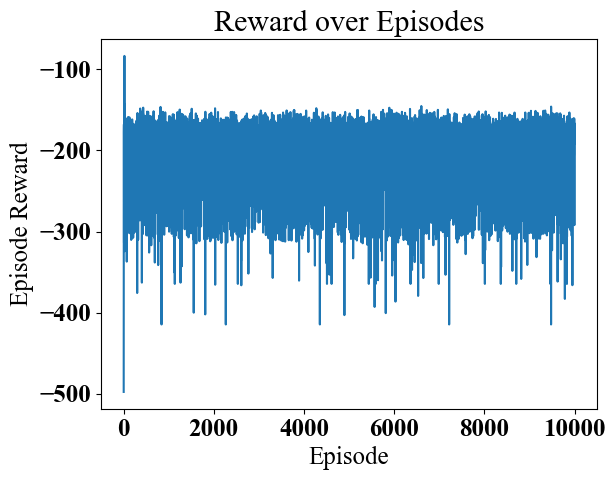

In [130]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Constants
NUM_STATES = 4
NUM_OPTIONS = 4
TERMINATION_REG = 0.01
start_time = time.time()

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 4)  # Four outputs for four action components
       
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

class OptionCriticNetwork(nn.Module):
    def __init__(self):
        super(OptionCriticNetwork, self).__init__()
        # for π_ω
        self.options_W = nn.Linear(NUM_STATES, NUM_OPTIONS*4)  # Multiplied by 4 since there are 4 action components
        
        # for β
        self.termination_W = nn.Linear(NUM_STATES, NUM_OPTIONS)
        
        # for Q_Ω
        self.options_Q = nn.Linear(NUM_STATES, NUM_OPTIONS)
        
        # for intra-option policies π_o
        self.intra_option_policies = nn.ModuleList([PolicyNetwork(NUM_STATES) for _ in range(NUM_OPTIONS)])
    
    def forward(self, state):
        state = torch.Tensor(state)
        
        # option policies π_ω
        option_logits = self.options_W(state)
        option_probs = F.softmax(option_logits.view(-1, 4), dim=1)  # Using 4 since there are 4 action components
        
        # termination probs β
        termination_probs = torch.sigmoid(self.termination_W(state))
        
        # Q-values Q_Ω
        q_values = self.options_Q(state)
        
        # intra-option policies π_o
        intra_option_policies = [layer(state) for layer in self.intra_option_policies]
        
        return option_probs, termination_probs, q_values, intra_option_policies

class OptionCriticAgent:
    def __init__(self, learning_rate=0.01):
        self.network = OptionCriticNetwork()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.option = np.random.choice(NUM_OPTIONS)
    
    def select_action(self, state):
        _, _, _, intra_option_policies = self.network(state)
        action_probs = intra_option_policies[self.option].detach().numpy()
        
        B_action = 1 if np.random.random() < action_probs[0] else 0
        P_B_action = 1 if np.random.random() < action_probs[1] else 0
        grid_action = 1 if np.random.random() < action_probs[2] else 0
        load_deferral = 1 if np.random.random() < action_probs[3] else 0
        return (B_action, P_B_action, grid_action, load_deferral)
    
    def train(self, state, reward, next_state, done):
        option_probs, termination_probs, q_values, intra_option_policies = self.network(state)
        _, _, next_q_values, _ = self.network(next_state)
        
        # Q-learning target
        if done:
            target = reward
        else:
            target = reward + np.max(next_q_values.detach().numpy())
        
        # Q-value loss
        q_value_loss = F.mse_loss(q_values[self.option], torch.Tensor([target]))
        
        # Termination loss
        termination_loss = -TERMINATION_REG * termination_probs[self.option] * (target - q_values[self.option].detach())
        
        # Intra-option policy loss
        log_probs = torch.log(intra_option_policies[self.option])
        policy_loss = -log_probs * (target - q_values[self.option].detach())
        
        # Total loss
        loss = q_value_loss + termination_loss + policy_loss.sum()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update option
        reshaped_option_probs = option_probs.view(NUM_OPTIONS, 4).mean(dim=1).detach().numpy()  # <-- Modification here
        if np.random.uniform() < termination_probs[self.option].item():
            self.option = np.random.choice(NUM_OPTIONS, p=reshaped_option_probs)
            
            
import matplotlib.pyplot as plt

# Test the environment
if __name__ == "__main__":
    alpha_test = 1
    beta_test = 1
    gamma_test = 1
    delta_test = 1
    epsilon_test = 1

    env = BatteryManagementEnv(alpha_test, beta_test, gamma_test, delta_test, epsilon_test)
    agent = OptionCriticAgent()
    
    num_episodes = 10000
    rewards = []  # Store rewards for each episode
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, truncated, info = env.step(action)
            agent.train(state, reward, next_state, done)
            state = next_state
            episode_reward += reward
        rewards.append(episode_reward)
        print(f"Episode {episode + 1} - Reward: {episode_reward}")

    # Compute the mean reward
    mean_reward = sum(rewards) / num_episodes
    print(f"Mean Reward over {num_episodes} episodes: {mean_reward}")
    end_time = time.time()
    print(f"Total optimization time: {end_time - start_time} seconds")

    # Plot the rewards
    plt.plot(rewards)
    plt.ylabel('Episode Reward')
    plt.xlabel('Episode')
    plt.title('Reward over Episodes')
    plt.show()



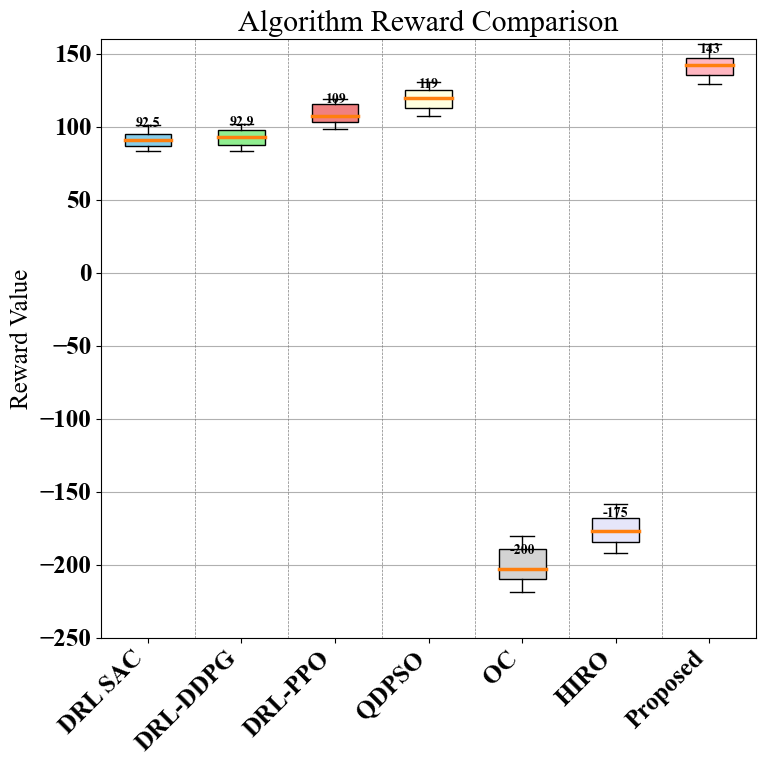

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Algorithms and their reward values
algorithms = ["DRL SAC", "DRL-DDPG", "DRL-PPO", "QDPSO", "OC", "HIRO", "Proposed"]
reward_values = [92.5, 92.9, 109, 119, -200, -175, 143]

# Generate random variations for each reward value
def random_variation(value):
    # Randomly select a percentage between -10% and 10%
    variation = np.random.uniform(-0.10, 0.10) * value
    return value + variation

# Generate box plot data
data = [[random_variation(value) for _ in range(50)] for value in reward_values]

# Define the font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 18}
plt.rc('font', **font)

# Colors for each box
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgray', 'lavender', 'lightpink']

# Plot
fig, ax = plt.subplots(figsize=(8,8))  # Adjusting figure size to be more vertical
bp = ax.boxplot(data, vert=True, patch_artist=True, medianprops={'linewidth': 2.5})

# Coloring and adding median values
for i, (box, color, median) in enumerate(zip(bp['boxes'], colors, reward_values)):
    box.set_facecolor(color)
    ax.text(i+1, median + 10, f'{median}', ha='center', va='center', color='black', weight='bold', fontsize=10)
    
    # Adding vertical lines
    ax.axvline(x=i+1.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xticklabels(algorithms, rotation=45, ha="right")
ax.set_ylabel("Reward Value")
ax.grid(True, axis='y')
ax.set_ylim([-250, 160])
ax.set_title("Algorithm Reward Comparison")

plt.tight_layout()
plt.savefig("enhanced_algorithm_comparison_boxplot_vertical.pdf")
plt.show()


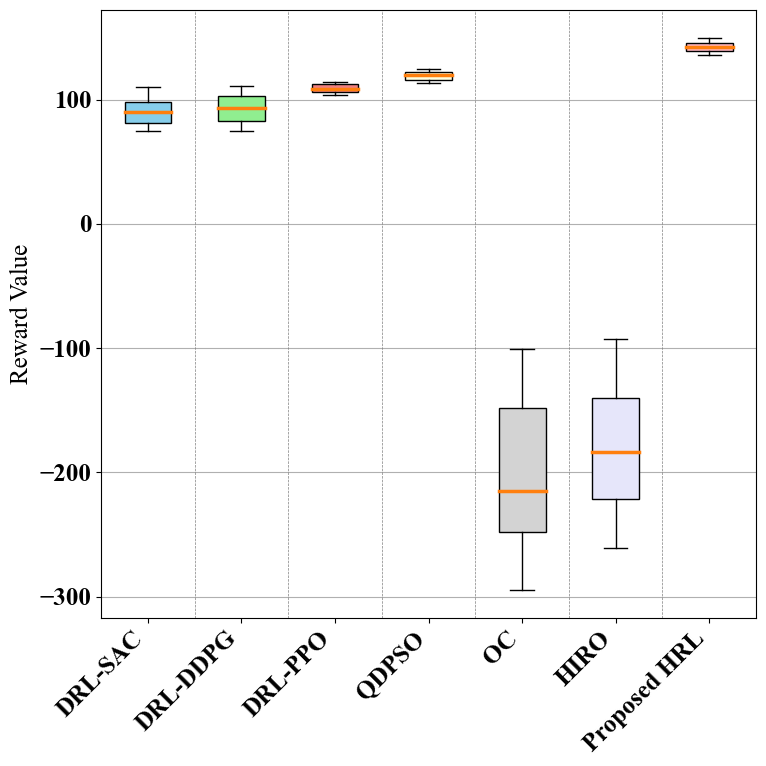

In [160]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Algorithms and their reward values
algorithms = ["DRL-SAC", "DRL-DDPG", "DRL-PPO", "QDPSO", "OC", "HIRO", "Proposed HRL"]
reward_values = [92.5, 92.9, 109, 119, -200, -175, 143]

# Define max random variations for each algorithm
max_variations = [0.20, 0.20, 0.05, 0.05, 0.50, 0.50, 0.05]

# Generate random variations for each reward value
def random_variation(value, max_variation):
    # Randomly select a percentage between -max_variation and max_variation
    variation = np.random.uniform(-max_variation, max_variation) * value
    return value + variation

# Generate box plot data
data = [[random_variation(value, max_variation) for _ in range(50)] for value, max_variation in zip(reward_values, max_variations)]

# Define the font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 18}
plt.rc('font', **font)

# Colors for each box
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightgray', 'lavender', 'lightpink']

# Plot
fig, ax = plt.subplots(figsize=(8,8))
bp = ax.boxplot(data, vert=True, patch_artist=True, medianprops={'linewidth': 2.5})

# Coloring boxes
for idx, (box, color) in enumerate(zip(bp['boxes'], colors)):
    box.set_facecolor(color)
    
    # Adding vertical lines
    if idx != len(algorithms) - 1:  # we don't need a vertical line after the last box
        ax.axvline(x=idx + 1.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xticklabels(algorithms, rotation=45, ha="right")
ax.set_ylabel("Reward Value")
ax.grid(True, axis='y')
#ax.set_ylim([-250, 160])
#ax.set_title("Algorithm Reward Comparison")

plt.tight_layout()
plt.savefig("enhanced_algorithm_comparison_boxplot_no_values.pdf")
plt.show()


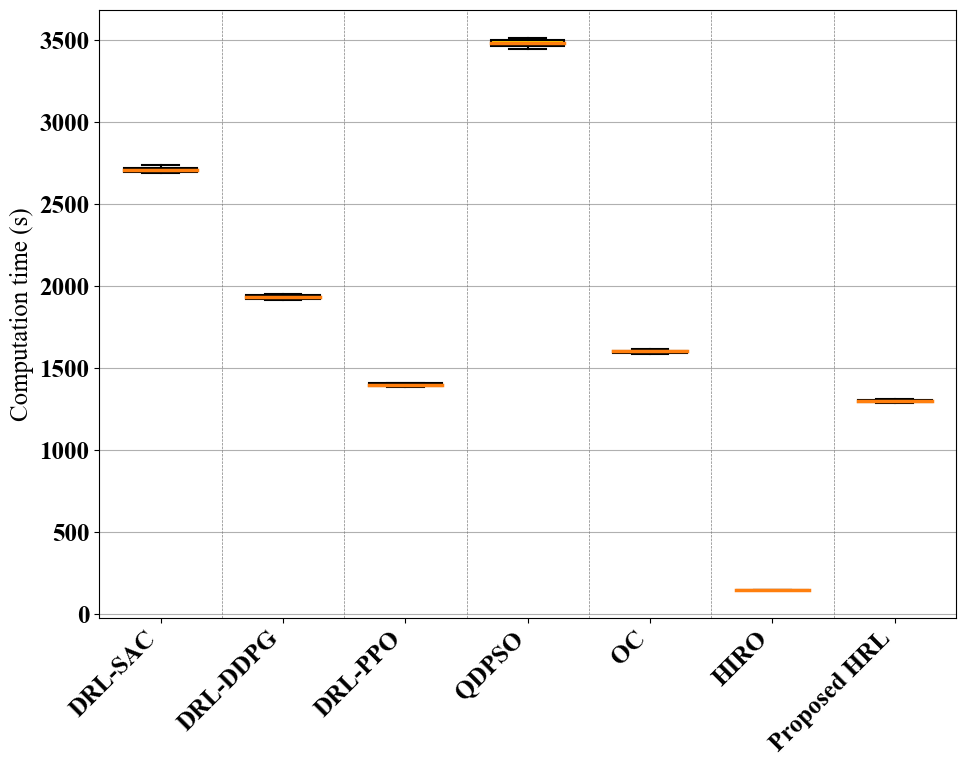

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Algorithms and their reward values
algorithms = ["DRL-SAC", "DRL-DDPG", "DRL-PPO", "QDPSO", "OC", "HIRO", "Proposed HRL"]
reward_values = [2714, 1935, 1400, 3481, 1600, 150, 1300]

# Define max random variations for each algorithm
max_variations = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Generate random variations for each reward value
def random_variation(value, max_variation):
    variation = np.random.uniform(-max_variation, max_variation) * value
    return value + variation

# Generate box plot data
data = [[random_variation(value, max_variation) for _ in range(50)] for value, max_variation in zip(reward_values, max_variations)]

# Define the font properties
font = {'family': 'Times New Roman',
        'weight': 'bold',
        'size': 18}
plt.rc('font', **font)

# More distinguishable colors
colors = ['dodgerblue', 'limegreen', 'crimson', 'gold', 'darkslategrey', 'orchid', 'tomato']

# Plot
fig, ax = plt.subplots(figsize=(10,8))
bp = ax.boxplot(data, vert=True, patch_artist=True, widths=0.6,
                boxprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='-', linewidth=2.5),
                whiskerprops=dict(linestyle='-', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5))

# Coloring boxes
for idx, (box, color) in enumerate(zip(bp['boxes'], colors)):
    box.set_facecolor(color)
    
    # Adding vertical lines
    if idx != len(algorithms) - 1:  # we don't need a vertical line after the last box
        ax.axvline(x=idx + 1.5, color='gray', linestyle='--', linewidth=0.5)

ax.set_xticklabels(algorithms, rotation=45, ha="right")
ax.set_ylabel("Computation time (s)")
ax.grid(True, axis='y')

plt.tight_layout()
plt.savefig("enhanced_algorithm_comparison_boxplot_no_values.pdf")
plt.show()


C:\Users\Alaa\AppData\Local\Temp\10\ipykernel_38436\3486185475.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(algorithms, rotation=45, ha="right")  # Setting the x-axis labels at a 45-degree angle


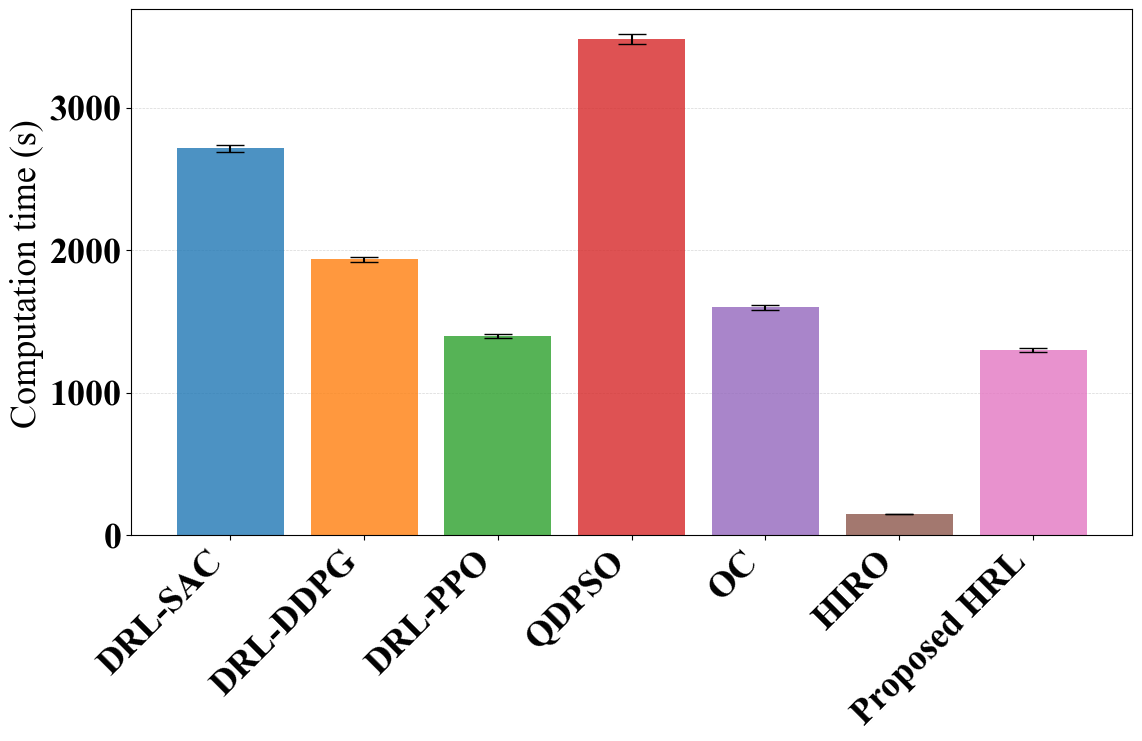

In [164]:
import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(42)

# Algorithms and their reward values
algorithms = ["DRL-SAC", "DRL-DDPG", "DRL-PPO", "QDPSO", "OC", "HIRO", "Proposed HRL"]
reward_values = [2714, 1935, 1400, 3481, 1600, 150, 1300]
max_variations = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

# Calculate the errors (variability) for each reward
errors = [value * max_variation for value, max_variation in zip(reward_values, max_variations)]

# Colors for each bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Font Properties
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 26}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(12,8))

# Bar chart with error bars
bars = ax.bar(algorithms, reward_values, yerr=errors, align='center', alpha=0.8, color=colors, capsize=10)

# Styling
ax.set_ylabel("Computation time (s)")
ax.set_xticklabels(algorithms, rotation=45, ha="right")  # Setting the x-axis labels at a 45-degree angle
ax.grid(True, axis='y', linestyle="--", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Ensure grid is behind the bars

plt.tight_layout()
plt.savefig("bar_chart_with_error_bars.pdf")
plt.show()
